Team Number: 4  

Group Members:
1. BRENDAN EDWARD RAJ,  
2. CHUA ZONG HAN LIONEL,  
3. JASBIR KAUR,  
4. KOH YAO HAO,  
5. TIANG SOON LONG,  
6. TOH ZHEN WEI

---







# Section 1: Introduction

## 1.1 Problem Statement:

Accurately predicting football match outcomes has long been a challenge for analysts, bettors, and sports fans. Traditional prediction models rely on expert opinions, statistical trends, and historical performance, but these methods often fail to capture the complexity and dynamic nature of the game.

This project aims to explore the various machine learning models that predict football match outcomes based on historical match data, team statistics, and other relevant factors. By utilising modeling techniques, the objective is to enhance forecasting reliability and offer useful insights for analysts, teams, and even fans of the game.  



---



### 1.2 About the Dataset:
#### 1.2.1 Dataset 1
The match data dataset contains 5,778 rows and 127 columns, representing match data from the Premier League (2017-2024).   
Each row corresponds to an individual match played by a team, including detailed match statistics, opponent information, and season-wise records.

Sample Columns in the Dataset
- Match Details: Date, Round, Day, Season
- Team Performance: Venue, Result (W/D/L), Goals For, Goals Against, Opponent
- Possession & Passing: Possession %, Passes Attempted, Passes Completed, Progressive Passes
- Shooting & Goals: Shots, Shots on Target, Expected Goals (xG), Goals
- Defensive Actions: Tackles, Interceptions, Blocks, Clearances
- Dribbling & Carrying: Successful Take-Ons, Carries into Final Third, Progressive Carries

---

#### 1.2.2 Dataset 2
The FIFA Team Rating Dataset is sourced from the FIFA video game series, which assigns numerical ratings to teams based on their in-game squad attributes. These ratings are influenced by real-world player performances and are regularly updated by EA Sports through squad updates. These updates reflect player transfers, form changes, ensuring that the ratings stay aligned with real-world football dynamics. This indirectly helps us quantify areas of football that are hard to be represented as values.

The dataset includes several important attributes for each team:
- Overall Rating: A single score summarizing the team's overall strength.
- Attack Rating: A measure of offensive capabilities, including finishing, pace, and dribbling.
- Midfield Rating: Reflects playmaking, passing, and control in the midfield.
- Defense Rating: Evaluates defensive organization, tackling, and positioning.



---


URL Links to Data Sources:
1. https://sofifa.com/teams
2. https://fbref.com/en/comps/9/Premier-League-Stats

# Section 2: Project Set Up
In this section, we will import the relevant libraries and also load the scrapped data we manually collected

### 2.1 Import Libraries and Load Dataset

In [77]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

import time
from datetime import timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For display and utility
from IPython.display import display
from collections import Counter

# Scikit-learn, XGBoost, and Imbalanced-Learn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import (
    cross_val_score,
    KFold,
    GridSearchCV,
    TimeSeriesSplit
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    recall_score
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import (
    AdaBoostClassifier,
    VotingClassifier,
    RandomForestClassifier
)
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# Feature selection and inspection
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance

# Hierarchical clustering
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

# Suppress additional warnings
warnings.filterwarnings('ignore')

In [ ]:
# Define the file path (update based on your file location in Drive)
file_path = '2017-2024 match data.csv'

# Load the dataset
df = pd.read_csv(file_path)

Mounted at /content/drive


In [ ]:
fifa_game_team_rating_df= pd.read_csv('fifa_team_rating.csv')

# Section 3: Data Cleaning
In this section, we will conduct data cleaning and explore our data.

### 3.1 Fix Mismatched Team and Opponent Names

From the website we scrapped our data from, we realised that they had given some of the teams with different names, even though it was the same 1 team.

For example:  
Brighton and Hove Albion vs Brighton  
Manchester United vs Manchester Utd


We will correct the names so that the data is standardised and every team only has one name.

In [80]:
team_names = set(df["Team"].unique())
opponent_names = set(df["Opponent"].unique())

only_in_team = sorted(team_names - opponent_names)
only_in_opponent = sorted(opponent_names - team_names)

print("Names in 'Team' but not in 'Opponent':", only_in_team)
print("Names in 'Opponent' but not in 'Team':", only_in_opponent)

Names in 'Team' but not in 'Opponent': ['Brighton and Hove Albion', 'Huddersfield Town', 'Manchester United', 'Newcastle United', 'Nottingham Forest', 'Sheffield United', 'Tottenham Hotspur', 'West Bromwich Albion', 'West Ham United', 'Wolverhampton Wanderers']
Names in 'Opponent' but not in 'Team': ['Brighton', 'Huddersfield', 'Manchester Utd', 'Newcastle Utd', "Nott'ham Forest", 'Sheffield Utd', 'Tottenham', 'West Brom', 'West Ham', 'Wolves']


In [81]:
team_name_corrections = {
    "Brighton and Hove Albion": "Brighton",
    "Huddersfield Town": "Huddersfield",
    "Manchester United": "Manchester Utd",
    "Newcastle United": "Newcastle Utd",
    "Nottingham Forest": "Nott'ham Forest",
    "Sheffield United": "Sheffield Utd",
    "Tottenham Hotspur": "Tottenham",
    "West Bromwich Albion": "West Brom",
    "West Ham United": "West Ham",
    "Wolverhampton Wanderers": "Wolves",
}

df["Team"] = df["Team"].replace(team_name_corrections)

### 3.2 Checking for Missing Data

In [82]:
print(df.isnull().sum()[df.isnull().sum() > 0])

Attendance    882
SoT%            3
G/Sh            3
G/SoT         184
Dist            3
npxG/Sh         3
Save%         169
dtype: int64


### 3.3 Handling Missing Data for SoT%, G/Sh, Dist and npxG/sh
Next, we investigate the data to understand why there are exactly 3 records missing for the following categories:

1. SoT% (Shots on Target %) = Percentage of shots that are on target  
2. G/Sh = Goals per shot taken  
3. Dist = Average Shot Distance  
4. npxG/sh = Non-Penalty Expected Goals per shot

Upon analysing the data and why there were missing values, we are confident that the website we scrapped the data from had mistakenly left it blank instead of '0.0'.   

How we realised this:

As the team had taken 0 shots, it would be impossible to have SoT% (Shots on Target %) or G/SoT (Goals per Shot on Target) - you can't produce any shot related metrics if a team doesn't take any shots

Thus, we will update the missing values in SoT%, G/Sh, Dist and npxG/Sh with 0

In [83]:
df['SoT%'] = df['SoT%'].fillna(0.0)
df['G/Sh'] = df['G/Sh'].fillna(0.0)
df['Dist'] = df['Dist'].fillna(0.0)
df['npxG/Sh'] = df['npxG/Sh'].fillna(0.0)

### 3.4 Handling Missing Data for Save% and G/SoT
The remaining columns of data to clean regarding missing data were: G/SoT and Save%, with 184 and 169 missing data points respectively.  

Similar to the previous step, we realised that the website we scrapped the data from had mistakenly left G/SoT and Save% blank.

Fixes Made for Save%:  
1. Ensure Save% is 0.0 when no shots were faced  
2. Compute Save% when SoTA > 0

Fixes Made for G/SoT:
1. G/SoT = 0.0 when SoT == 0 (No shots on target → No goals from shots on target)

In [84]:
df.loc[(df['SoTA'] == 0) & (df['Saves'] == 0), 'Save%'] = 0.0
df.loc[df['Save%'].isnull() & (df['SoTA'] > 0), 'Save%'] = (df['Saves'] / df['SoTA']) * 100
df.loc[df['SoT'] == 0, 'G/SoT'] = 0.0

### 3.5 Handling Missing Data for Attendance
Attendance has 882 missing datapoints, which makes up about 15% of our dataset.

Upon analysis and some research,  
2020-2021 Premier League season, many games had no attendance due to COVID-19 restrictions  
The no-fan period in the Premier League due to COVID-19 was mainly from:  
March 2020 – May 2021 (End of 2019-20 season & full 2020-21 season)  

First, we will check if there is any missing attendance outside covid period

In [85]:
# Convert Date column to DateTime
df["Date"] = pd.to_datetime(df["Date"])

covid_start = pd.to_datetime("2020-03-01")
covid_end = pd.to_datetime("2021-05-31")

df[df['Attendance'].isnull() & ~((df['Date'] >= covid_start) & (df['Date'] <= covid_end))]

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Opp Formation,Referee,Sh,SoT,SoT%,G/Sh,G/SoT,Dist,FK,PK,PKatt,npxG,npxG/Sh,G-xG,np:G-xG,SoTA,Saves,Save%,CS,Total_Cmp,Total_Att,Total_Cmp%,Total_TotDist,Total_PrgDist,Short Pass Cmp,Short Pass Att,Short Pass Cmp%,Medium Pass Cmp,Medium Pass Att,Medium Pass Cmp%,Long Pass Cmp,Long Pass Att,Long Pass Cmp%,Ast,xAG,xA,KP,1/3,PPA,CrsPA,PrgP,Passes Attempted,Live-ball Passes,Dead-ball Passes,Passes from Free Kicks,Through Balls,Switches,Crosses,Throw-ins Taken,Corner Kicks,Inswinging Corner Kick,Outswinging Corner Kicks,Straight Corner Kicks,Passes Completed,Passes Offside,Passes Blocked_x,SCA,SCA (Live-ball Pass),SCA (Dead-ball Pass),SCA (Take-On),SCA (Shot),SCA (Fouls Drawn),SCA (Defensive Action),GCA,GCA (Live-ball Pass),GCA (Dead-ball Pass),GCA (Take-On),GCA (Shot),GCA (Fouls Drawn),GCA (Defensive Action),Tackles,Tackles Won,Tackles (Def 3rd),Tackles (Mid 3rd),Tackles (Att 3rd),Dribblers Tackled,Dribbles Challenged,% of Dribblers Tackled,Challenges Lost,Blocks,Shots Blocked,Passes Blocked_y,Interceptions,Tkl+Int,Clearances,Errors,Possession %,Touches,Touches (Def Pen),Touches (Def 3rd),Touches (Mid 3rd),Touches (Att 3rd),Touches (Att Pen),Touches (Live-Ball),Take-Ons Attempted,Successful Take-Ons,Successful Take-On %,Times Tackled During Take-On,Tackled During Take-On Percentage,Carries,Total Carrying Distance,Progressive Carrying Distance,Progressive Carries,Carries into Final Third,Carries into Penalty Area,Miscontrols,Dispossessed,Passes Received,Progressive Passes Rec,Season,Team
4027,2023-05-28,16:30,Premier League,Matchweek 38,Sun,Away,L,1.0,2.0,Aston Villa,1.4,2.8,59.0,NaN,Pascal Groß,4-4-2,4-2-3-1,David Coote,8.0,4.0,50.0,0.13,0.25,18.2,0.0,0,0,1.4,0.17,-0.4,-0.4,5.0,3.0,60.0,0.0,375.0,456.0,82.2,6458.0,2450.0,165.0,192.0,85.9,180.0,201.0,89.6,23.0,34.0,67.6,1.0,1.3,0.9,7.0,22.0,4.0,2.0,33.0,456.0,407.0,43.0,13.0,4.0,1.0,7.0,12.0,3.0,1.0,0.0,0.0,375.0,6.0,12.0,15.0,13.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,13.0,2.0,6.0,5.0,2.0,4.0,19.0,21.1,15.0,7.0,2.0,5.0,3.0,16,15.0,0.0,59.0,549.0,85.0,224.0,234.0,95.0,19.0,549.0,16.0,8.0,50.0,5.0,31.3,298.0,1563.0,818.0,19.0,6.0,9.0,18.0,9.0,365.0,33.0,2022-2023,Brighton
4065,2023-05-28,16:30,Premier League,Matchweek 38,Sun,Home,W,2.0,1.0,Brighton,2.8,1.4,41.0,NaN,John McGinn,4-2-3-1,4-4-2,David Coote,12.0,5.0,41.7,0.17,0.40,18.2,4.0,0,0,2.8,0.24,-0.8,-0.8,4.0,3.0,75.0,0.0,229.0,315.0,72.7,4236.0,1741.0,98.0,109.0,89.9,103.0,128.0,80.5,25.0,61.0,41.0,2.0,2.6,1.8,8.0,24.0,6.0,2.0,27.0,315.0,265.0,50.0,18.0,3.0,2.0,13.0,19.0,3.0,3.0,0.0,0.0,229.0,0.0,5.0,24.0,14.0,2.0,2.0,0.0,5.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,14.0,6.0,5.0,6.0,3.0,5.0,13.0,38.5,8.0,13.0,1.0,12.0,12.0,26,7.0,0.0,41.0,413.0,64.0,153.0,166.0,106.0,19.0,413.0,21.0,15.0,71.4,4.0,19.0,236.0,1400.0,766.0,20.0,18.0,5.0,13.0,9.0,226.0,26.0,2022-2023,Aston Villa


From our code, we realised that there is 1 match with missing attendance data (2 records related to the same match)  
We will update attendance for missing attendance for Aston Villa vs Brighton using another reliable data source

Source: https://www.skysports.com/football/aston-villa-vs-brighton-and-hove-albion/stats/465006#:~:text=Aston%20Villa%20vs%20Brighton%20and,Villa%20ParkAttendance%3A%2042%2C212

In [86]:
df.loc[[4027, 4065], 'Attendance'] = 42212

For the remaining data which is still missing (covid games), we will replace the missing attendance with the team's median for that dataset  
We chose to use the median instead of setting it to 0 as it would mislead the machine learning model to identify false patterns and introduce bias in predictions.

In [87]:
# Step 1: Compute median attendance for each team when playing at home
home_medians = df[df['Venue'] == 'Home'].groupby('Team')['Attendance'].median()

# Step 2: Fill missing attendance for home games using their own home median
df.loc[(df['Attendance'].isnull()) & (df['Venue'] == 'Home'), 'Attendance'] = df['Team'].map(home_medians)

# Step 3: Fill remaining missing attendance for away games using the opponent's median (opponent is the home team)
df.loc[(df['Attendance'].isnull()) & (df['Venue'] == 'Away'), 'Attendance'] = df['Opponent'].map(home_medians)

We do a final check if there are any missing data remaining in the dataset. Empty output meaning no missing data in the dataset left.

In [88]:
print(df.isnull().sum()[df.isnull().sum() > 0])

Series([], dtype: int64)


In [89]:
# Dropping columns which has no direct impact with outcome
df = df.drop(columns=['Captain', 'Formation', 'Opp Formation', 'Referee',"Time", "Day", "Comp", "Attendance"])

# Move 'Season' to index 4
cols = list(df.columns)
cols.insert(4, cols.pop(cols.index('Season')))
df = df[cols]

# Move 'Team' to the index 7
cols = list(df.columns)
cols.insert(7, cols.pop(cols.index('Team')))
df = df[cols]

### 3.6 FIFA Video Game Team Rating Dataset Cleaning

In [90]:
fifa_game_team_rating_df = fifa_game_team_rating_df[['Roster Date', 'Team Name', 'Overall Rating', 'Attack', 'Midfield', 'Defense']]
fifa_game_team_rating_df.head()

,Roster Date,Team Name,Overall Rating,Attack,Midfield,Defense
0,12/3/2025,Manchester City,85,85,85,83
1,12/3/2025,Liverpool,84,84,83,86
2,12/3/2025,Arsenal,83,81,85,81
3,12/3/2025,Aston Villa,81,82,80,80
4,12/3/2025,Chelsea,81,83,82,79


Cleaning the dataset by fixing mismatched team names, as team names will be the primary variable used to merge both datasets together

In [91]:
team_names = set(df["Team"].unique())
fifa_names = set(fifa_game_team_rating_df["Team Name"].unique())

only_in_team = sorted(team_names - fifa_names)
only_in_fifa = sorted(fifa_names - team_names)

print("Names in 'Team' but not in 'Fifa':", only_in_team)
print("Names in 'Fifa' but not in 'Team':", only_in_fifa)

Names in 'Team' but not in 'Fifa': ['Bournemouth', 'Brighton', 'Fulham', 'Huddersfield', 'Manchester Utd', 'Newcastle Utd', "Nott'ham Forest", 'Sheffield Utd', 'Tottenham', 'West Brom', 'West Ham', 'Wolves']
Names in 'Fifa' but not in 'Team': ['AFC Bournemouth', 'Brighton & Hove Albion', 'Fulham FC', 'Huddersfield Town', 'Hull City', 'Manchester United', 'Middlesbrough', 'Newcastle United', 'Nottingham Forest', 'Sheffield United', 'Sunderland', 'Tottenham Hotspur', 'West Bromwich Albion', 'West Ham United', 'Wolverhampton Wanderers']


In [92]:
fifa_team_name_corrections = {
    "AFC Bournemouth": "Bournemouth",
    "Brighton & Hove Albion": "Brighton",
    "Fulham FC": "Fulham",
    "Huddersfield Town": "Huddersfield",
    "Manchester United": "Manchester Utd",
    "Newcastle United": "Newcastle Utd",
    "Nottingham Forest": "Nott'ham Forest",
    "Sheffield United": "Sheffield Utd",
    "Tottenham Hotspur": "Tottenham",
    "West Bromwich Albion": "West Brom",
    "West Ham United": "West Ham",
    "Wolverhampton Wanderers": "Wolves",
}

fifa_game_team_rating_df["Team Name"] = fifa_game_team_rating_df["Team Name"].replace(fifa_team_name_corrections)

# Section 4: Exploratory Data Analysis (EDA)

### 4.1 Goal Distribution

Most matches have low goal counts, with 0, 1, or 2 goals being the most frequent.  
The distribution is right-skewed, meaning high-scoring matches are rare.

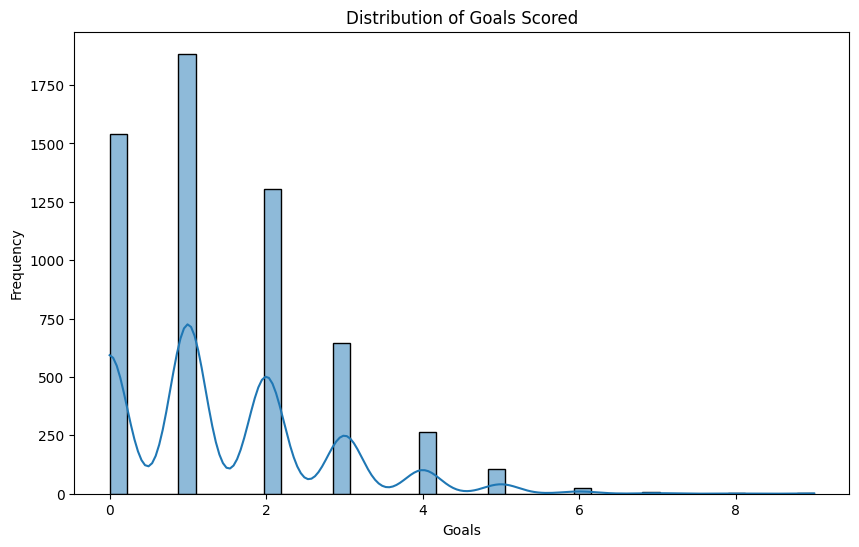

In [93]:
plt.figure(figsize=(10, 6))
sns.histplot(df['GF'], kde=True)
plt.title('Distribution of Goals Scored')
plt.xlabel('Goals')
plt.ylabel('Frequency')
plt.show()

### 4.2 Match Result Distribution  
In this dataset there is much more wins/losses than draws.  
Thus predicting draws may be harder.

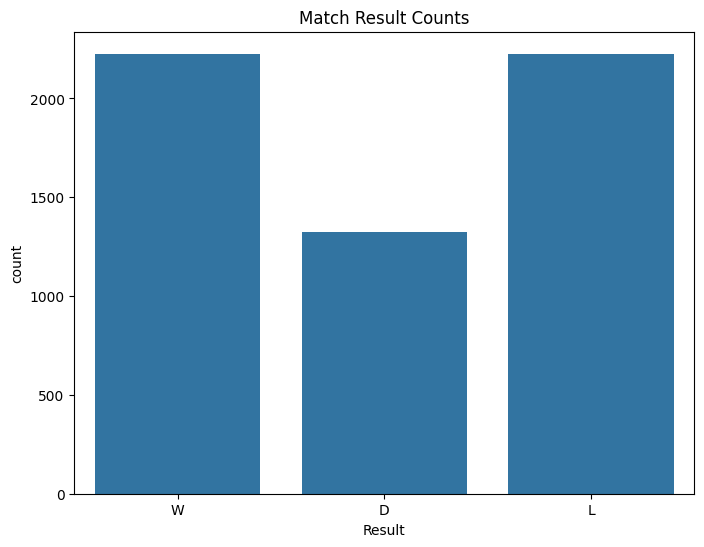

In [94]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Result', data=df)
plt.title('Match Result Counts')
plt.show()

### 4.3 Home vs. Away Performance:

Teams tend to perform better at home, with higher win counts compared to away games.  
Away matches have a higher frequency of losses, reinforcing the home advantage effect in football.

<Axes: xlabel='Venue', ylabel='count'>

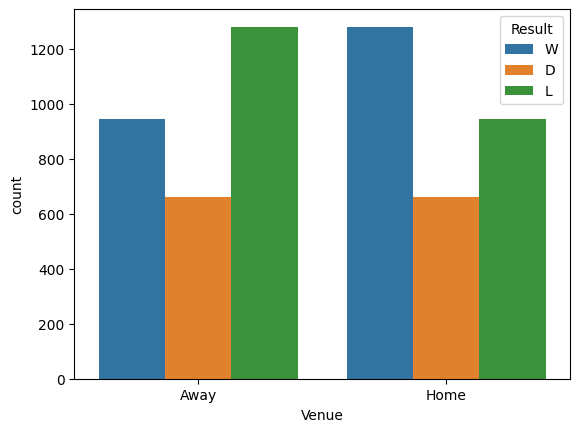

In [95]:
sns.countplot(x="Venue", hue="Result", data=df)

### 4.4 Feature Correlation

In machine learning, feature correlation analysis helps identify redundant or highly related variables to improve model efficiency and prevent overfitting.

When two features are 100% correlated, keeping both adds no additional value, so they can be removed.

Similarly, features with very high correlation (but not identical) often represent similar types of data, making one redundant (e.g., `"Live-ball Passes"` vs. `"Passes Received"`).

Additionally, domain knowledge plays a crucial role in feature selection, as some variables may have little to no impact on predicting football match outcomes (e.g., `"Throw-ins Taken"` and `"Corner Kick Types"`).

By systematically removing highly correlated and irrelevant features, the dataset is refined to include only unique and meaningful predictors, improving model interpretability and performance.

In [96]:
df_numeric_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[df_numeric_cols].corr()

# Identify highly correlated features
threshold = 0.9
high_corr_features = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            high_corr_features.append((col1, col2, corr_matrix.iloc[i, j]))

# Display highly correlated features
print("\nHighly Correlated Feature Pairs (Threshold = {}):".format(threshold))
for col1, col2, corr_value in sorted(high_corr_features, key=lambda x: -abs(x[2])):
    print(f"{col1} ⟷ {col2} | Correlation: {corr_value:.2f}")


Highly Correlated Feature Pairs (Threshold = 0.9):
Passes Attempted ⟷ Total_Att | Correlation: 1.00
Passes Completed ⟷ Total_Cmp | Correlation: 1.00
Possession % ⟷ Poss | Correlation: 1.00
Touches (Live-Ball) ⟷ Touches | Correlation: 1.00
Passes Received ⟷ Total_Cmp | Correlation: 1.00
Passes Received ⟷ Passes Completed | Correlation: 1.00
Progressive Passes Rec ⟷ PrgP | Correlation: 1.00
Live-ball Passes ⟷ Total_Att | Correlation: 1.00
Live-ball Passes ⟷ Passes Attempted | Correlation: 1.00
Short Pass Att ⟷ Short Pass Cmp | Correlation: 1.00
Medium Pass Att ⟷ Medium Pass Cmp | Correlation: 0.99
Live-ball Passes ⟷ Total_Cmp | Correlation: 0.99
Passes Completed ⟷ Live-ball Passes | Correlation: 0.99
Passes Received ⟷ Live-ball Passes | Correlation: 0.99
Touches ⟷ Total_Att | Correlation: 0.99
Touches ⟷ Passes Attempted | Correlation: 0.99
Touches (Live-Ball) ⟷ Total_Att | Correlation: 0.99
Touches (Live-Ball) ⟷ Passes Attempted | Correlation: 0.99
Touches ⟷ Live-ball Passes | Correlati

In [97]:
# Drop columns that have the another column in the df that represents the exact same kind of data (100% correlation)
df = df.drop(columns=['Total_Att', 'Total_Cmp', 'Poss', 'Touches',"Passes Received", "PrgP"])

# Drop columns that have very high correlation to other columns in the DF/ represent very similar data
df = df.drop(columns=['np:G-xG',  'Long Pass Att', 'Medium Pass Att', 'Short Pass Att','Touches (Live-Ball)','Live-ball Passes','Dead-ball Passes','Progressive Carrying Distance','Progressive Carries','GCA','Total_TotDist','Take-Ons Attempted','Passes Blocked_x','Dribblers Tackled'])

# Drop columns based on domain knowledge that these columns have no direct relation to predicting outcome of football matches
df = df.drop(columns=['Switches','Throw-ins Taken','Outswinging Corner Kicks','Inswinging Corner Kick','Straight Corner Kicks', 'SCA','SCA (Live-ball Pass)','SCA (Dead-ball Pass)', 'SCA (Take-On)', 'SCA (Shot)', 'SCA (Fouls Drawn)', 'SCA (Defensive Action)',
                     'Touches (Def Pen)',	'Touches (Def 3rd)',	'Touches (Mid 3rd)','Tackles (Att 3rd)'])


# Section 5: Data and Feature Engineering

### 5.1 Data Engineering: Merging FIFA Game Team Ratings with Match Dataset

In [98]:
# Ensure Date columns are in datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
fifa_game_team_rating_df['Roster Date'] = pd.to_datetime(fifa_game_team_rating_df['Roster Date'], format='%d/%m/%Y')

# Sort data by date (VERY IMPORTANT for merge_asof)
df = df.sort_values(by='Date')
fifa_game_team_rating_df = fifa_game_team_rating_df.sort_values(by='Roster Date')

# Merge FIFA ratings for each team (backward to ensure no future data is leaked)
df = pd.merge_asof(
    df,
    fifa_game_team_rating_df,
    left_on='Date',
    right_on='Roster Date',
    left_by='Team',  # Match Team in df with Team Name in fifa_game_team_rating_df
    right_by='Team Name',
    direction='backward'  # Ensures only past data is used
)

# Rename merged columns for the Team
df = df.rename(columns={
    'Overall Rating': 'FIFA Overall Rating',
    'Attack': 'FIFA Attack Rating',
    'Midfield': 'FIFA Midfield Rating',
    'Defense': 'FIFA Defense Rating'
})

# Merge FIFA ratings for the Opponent (backward to prevent data leakage)
df = pd.merge_asof(
    df,
    fifa_game_team_rating_df,
    left_on='Date',
    right_on='Roster Date',
    left_by='Opponent',  # Match Opponent in df with Team Name in fifa_game_team_rating_df
    right_by='Team Name',
    direction='backward'  # Ensures only past data is used
)

# Rename merged columns for the Opponent
df = df.rename(columns={
    'Overall Rating': 'Opponent FIFA Overall Rating',
    'Attack': 'Opponent FIFA Attack Rating',
    'Midfield': 'Opponent FIFA Midfield Rating',
    'Defense': 'Opponent FIFA Defense Rating'
})

# Drop unnecessary columns
df = df.drop(columns=['Roster Date_x', 'Team Name_x','Roster Date_y', 'Team Name_y'])
df.head()

,Date,Round,Venue,Result,Season,GF,GA,Team,Opponent,xG,xGA,Sh,SoT,SoT%,G/Sh,G/SoT,Dist,FK,PK,PKatt,npxG,npxG/Sh,G-xG,SoTA,Saves,Save%,CS,Total_Cmp%,Total_PrgDist,Short Pass Cmp,Short Pass Cmp%,Medium Pass Cmp,Medium Pass Cmp%,Long Pass Cmp,Long Pass Cmp%,Ast,xAG,xA,KP,1/3,PPA,CrsPA,Passes Attempted,Passes from Free Kicks,Through Balls,Crosses,Corner Kicks,Passes Completed,Passes Offside,GCA (Live-ball Pass),GCA (Dead-ball Pass),GCA (Take-On),GCA (Shot),GCA (Fouls Drawn),GCA (Defensive Action),Tackles,Tackles Won,Tackles (Def 3rd),Tackles (Mid 3rd),Dribbles Challenged,% of Dribblers Tackled,Challenges Lost,Blocks,Shots Blocked,Passes Blocked_y,Interceptions,Tkl+Int,Clearances,Errors,Possession %,Touches (Att 3rd),Touches (Att Pen),Successful Take-Ons,Successful Take-On %,Times Tackled During Take-On,Tackled During Take-On Percentage,Carries,Total Carrying Distance,Carries into Final Third,Carries into Penalty Area,Miscontrols,Dispossessed,Progressive Passes Rec,FIFA Overall Rating,FIFA Attack Rating,FIFA Midfield Rating,FIFA Defense Rating,Opponent FIFA Overall Rating,Opponent FIFA Attack Rating,Opponent FIFA Midfield Rating,Opponent FIFA Defense Rating
0,2017-08-11,Matchweek 1,Home,W,2017-2018,4.0,3.0,Arsenal,Leicester City,2.5,1.5,27.0,10.0,37.0,0.15,0.40,19.7,0.0,0,0,2.5,0.10,1.5,3.0,0.0,0.0,0.0,83.0,3216.0,276.0,88.7,214.0,88.1,58.0,66.7,4.0,2.5,1.7,25.0,55.0,15.0,3.0,681.0,15.0,2.0,20.0,9.0,565.0,5.0,5.0,1.0,0.0,2.0,0.0,0.0,23.0,17.0,12.0,9.0,16.0,68.8,5.0,6.0,0.0,6.0,13.0,36,33.0,1.0,68.0,252.0,30.0,16.0,84.2,3.0,15.8,519.0,3015.0,32.0,7.0,11.0,14.0,61.0,83,81,83,82,78,79,78,76
1,2017-08-11,Matchweek 1,Away,L,2017-2018,3.0,4.0,Leicester City,Arsenal,1.5,2.5,6.0,3.0,50.0,0.50,1.00,10.5,0.0,0,0,1.5,0.25,1.5,10.0,6.0,60.0,0.0,61.0,2006.0,90.0,81.1,51.0,63.8,37.0,41.1,3.0,1.4,1.2,4.0,19.0,4.0,3.0,315.0,14.0,2.0,18.0,4.0,192.0,3.0,3.0,1.0,0.0,1.0,0.0,0.0,17.0,8.0,11.0,4.0,19.0,15.8,16.0,18.0,8.0,10.0,11.0,28,29.0,0.0,32.0,120.0,11.0,5.0,31.3,11.0,68.8,150.0,942.0,7.0,2.0,10.0,12.0,16.0,78,79,78,76,83,81,83,82
2,2017-08-12,Matchweek 1,Away,W,2017-2018,2.0,0.0,Manchester City,Brighton,1.9,0.3,14.0,4.0,28.6,0.07,0.25,19.5,2.0,0,0,1.9,0.17,-0.9,2.0,2.0,100.0,1.0,87.6,3285.0,330.0,91.9,282.0,90.4,60.0,70.6,1.0,1.2,2.4,9.0,70.0,16.0,1.0,820.0,10.0,3.0,27.0,10.0,718.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,10.0,6.0,6.0,4.0,9.0,22.2,7.0,9.0,2.0,7.0,9.0,19,8.0,1.0,77.0,298.0,27.0,6.0,50.0,6.0,50.0,566.0,3154.0,26.0,3.0,14.0,4.0,87.0,83,83,85,81,72,72,73,73
3,2017-08-12,Matchweek 1,Away,W,2017-2018,3.0,2.0,Burnley,Chelsea,0.6,1.5,10.0,5.0,50.0,0.30,0.60,14.5,1.0,0,0,0.6,0.07,2.4,6.0,4.0,66.7,0.0,73.9,2521.0,59.0,73.8,137.0,86.7,61.0,61.0,3.0,0.4,0.6,8.0,22.0,7.0,4.0,348.0,16.0,0.0,16.0,5.0,257.0,1.0,4.0,1.0,1.0,0.0,0.0,0.0,8.0,4.0,6.0,2.0,8.0,37.5,5.0,13.0,7.0,6.0,13.0,21,44.0,0.0,38.0,74.0,11.0,2.0,66.7,1.0,33.3,190.0,942.0,12.0,1.0,10.0,9.0,25.0,74,74,74,76,83,86,84,81
4,2017-08-12,Matchweek 1,Away,D,2017-2018,3.0,3.0,Liverpool,Watford,2.6,2.1,13.0,4.0,30.8,0.15,0.50,13.9,0.0,1,1,1.8,0.14,0.4,4.0,1.0,25.0,0.0,73.2,2909.0,141.0,79.2,197.0,81.1,41.0,48.8,2.0,1.8,0.6,12.0,25.0,10.0,1.0,527.0,15.0,2.0,14.0,3.0,386.0,1.0,3.0,0.0,0.0,1.0,1.0,0.0,20.0,15.0,12.0,7.0,17.0,35.3,11.0,12.0,1.0,11.0,11.0,31,25.0,0.0,54.0,135.0,23.0,6.0,54.5,5.0,45.5,302.0,1860.0,16.0,4.0,16.0,14.0,40.0,81,82,81,81,77,78,78,76


Creating a copy of the cleaned df and assigning it as df_w_features so that it can be used for Feature Engineering

In [99]:
df_w_features= df.copy()

### 5.2 Feature: Home Advantage
Encoding home advantage as a binary variable (1 if the match is played at home, 0 otherwise).   

This feature can be useful for our classification model, as playing at home is often associated with higher chances of winning due to factors like crowd support, familiarity with the pitch, and reduced travel fatigue.

In [100]:
df_w_features['Venue_Home'] = (df_w_features['Venue'] == 'Home').astype(int)

### 5.3 Feature: Performance-Based Comparative Metrics
These features capture a team's dominance over its opponents in various aspects, such as goal difference, expected goals (xG), shots on target (SoT), and possession.

They provide insights into a team's attacking and defensive strengths. However, since they rely on match outcomes, using them directly for predictions could lead to data leakage. Instead, they will be used later on as rolling averages to reflect team trends over time without leaking future results.

In [101]:
def calculate_goal_difference(df):
    df["Goal_Diff"] = df["GF"] - df["GA"]
    return df

def calculate_xg_difference(df):
    df["xG_Difference"] = df["xG"] - df["xGA"]
    return df

def calculate_sot_difference(df):
    df["SoT_Difference"] = df["SoT"] - df["SoTA"]
    return df

def calculate_possession_difference(df):
    df["Opponent_Possession"] = 100 - df["Possession %"]
    df["Poss_Diff"] = df["Possession %"] - df["Opponent_Possession"]
    return df

### 5.4 Feature: Form-Based Features
These features quantify a team's recent performance by tracking past match results, points earned, and streaks. They include rolling average points over the last 5 matches, direct form comparisons with opponents, encoded past match sequences, and unbeaten streaks.

These metrics highlight a team's consistency and momentum, helping predict future performance trends. Since they rely on past results, they are structured to avoid data leakage by using only information available before each match.

Summary of functions:
1. `calculate_form_comparison(df)`  
  - Calculates: The difference in rolling average points (last 5 matches) between a team and its opponent.
  - Feature Value: Captures recent performance trends, helping assess which team has stronger momentum leading into the match.
2. `calculate_form_pattern(df, N=5)`
  - Calculates: A sequence of the team's last N match results (e.g., "WWLDW").
  - Feature Value: Provides historical performance context, helping detect winning/losing streaks or patterns.
  - Works with: `convert_form_pattern_to_numerical(df, N=5)` to transform categorical match sequences into numerical values.
3. `convert_form_pattern_to_numerical(df, N=5)`
  - Calculates: Converts the past N match results from `calculate_form_pattern()` into numerical values (Win = 1, Draw = 0, Loss = -1).
  - Feature Value: Transforms historical performance into a numeric format that machine learning models can interpret effectively.
4. `calculate_unbeaten_streak_before_match(df)`
  - Calculates: The number of consecutive matches a team has gone without losing before a match.
  - Feature Value: Highlights team consistency and resilience, indicating whether a team is on an unbeaten run or struggling.

5. `calculate_clean_sheet_percentage(df, N=5)`
  - Calculates: The percentage of clean sheets in the last N matches before a given match.
  - Feature Value: Captures short-term defensive consistency. Helps measure whether a team is in strong defensive form or struggling to keep clean sheets.

In [102]:
def calculate_form_comparison(df):
    df = df.sort_values(["Team", "Date"])
    df["Points_Earned"] = df["Result"].map({"W": 3, "D": 1, "L": 0})

    df["Team_Last_5_Avg_Points"] = df.groupby("Team")["Points_Earned"].shift(1).rolling(5).mean()

    # Merge with opponent's last 5 avg points
    df = df.merge(df[["Team", "Date", "Team_Last_5_Avg_Points"]],
                  left_on=["Opponent", "Date"],
                  right_on=["Team", "Date"],
                  suffixes=("", "_Opponent")).drop(columns=["Team_Opponent"], errors='ignore')

    df.rename(columns={"Team_Last_5_Avg_Points_Opponent": "Opponent_Last_5_Avg_Points"}, inplace=True)

    df["Last_5_Points_Comparison"] = df["Team_Last_5_Avg_Points"] - df["Opponent_Last_5_Avg_Points"]

    df.drop(columns=["Points_Earned"], inplace=True)

    return df

def calculate_form_pattern(df, N=5):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Date"])

    form_patterns = []

    for team in df["Team"].unique():
        team_results = df[df["Team"] == team]["Result"].tolist()
        team_form = []

        for i in range(len(team_results)):
            if i == 0:
                team_form.append("")  # First match has no history
            else:
                # Extract last N results before current match
                start_idx = max(0, i - N)  # Ensure index doesn't go negative
                form_str = "".join(team_results[start_idx:i])  # Join past results into string
                team_form.append(form_str)

        form_patterns.extend(team_form)

    df["Form_Pattern_Before_Match"] = form_patterns

    return df

def convert_form_pattern_to_numerical(df, N=5):
    # Ensure column exists
    if "Form_Pattern_Before_Match" not in df.columns:
        print("Error: Form_Pattern_Before_Match column not found.")
        return df

    # Convert last N match results into separate numerical features
    for i in range(1, N+1):
        df[f"Form_{i}"] = df["Form_Pattern_Before_Match"].apply(lambda x: x[-i] if len(x) >= i else "None")

    # Map W/D/L to numerical values
    mapping = {"W": 1, "D": 0, "L": -1, "None": 0}
    for i in range(1, N+1):
        df[f"Form_{i}"] = df[f"Form_{i}"].map(mapping)

    df.drop(columns=["Form_Pattern_Before_Match"], inplace=True)

    return df

def calculate_unbeaten_streak_before_match(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Date"])

    unbeaten_streak = []

    for team in df["Team"].unique():
        team_results = df[df["Team"] == team]["Result"].tolist()
        streak = 0
        team_streak = []

        for result in team_results:
            team_streak.append(streak)
            if result in ["W", "D"]:
                streak += 1
            else:
                streak = 0

        unbeaten_streak.extend(team_streak)

    df["Unbeaten_Streak_Before_Match"] = unbeaten_streak

    return df

def calculate_clean_sheet_percentage(df, N=5):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Date"])

    df["Last_5_Clean_Sheet_Percentage"] = (
        df.groupby("Team")["CS"]
        .apply(lambda x: x.shift(1).rolling(N, min_periods=1).mean())
        .reset_index(drop=True)
    )

    return df

### 5.5 Feature: Season Performance Metrics
Understanding a team's long-term performance trends is crucial in predicting match outcomes. These features track a team's progress throughout the season by analyzing cumulative points, ranking, and comparative strength against opponents.  

By incorporating historical data, they provide insights into how consistently a team has performed and whether it is in good form or struggling. These metrics help identify title contenders, relegation risks, or mid-table teams and serve as a baseline for evaluating match expectations.

The following functions calculate seasonal performance indicators that ensure only past match data is considered, avoiding data leakage while providing useful context for predictive modeling.

Summary of functions:
1. `calculate_season_points(df)`
  - Calculates: Cumulative points earned before each match.
  - Feature Value: Represents a team's progress throughout the season.

2. `calculate_opponent_season_points(df)`
  - Calculates: The opponent’s cumulative season points before the match.
  - Feature Value: Helps compare team strength based on season-long performance.

3. `calculate_season_points_comparison(df)`
  - Calculates: The difference in season points before the match, between the team and its opponent.
  - Feature Value: Highlights the relative strength of both teams leading into the match.

4. `calculate_season_ranking(df)`
  - Calculates: Season ranking before each match, based on cumulative points.
  - Feature Value: Provides a dynamic measure of league standing and relative positioning.

5. `calculate_season_goal_difference(df)`
  - Calculates: A team's cumulative goal difference before each match in the season.
  - Feature Value: Reflects attacking and defensive efficiency over the season Also helps to assess whether a team has consistently outscored opponents or struggled defensively, and provides context on long-term performance rather than short-term fluctuations.

In [103]:
# Define a function to calculate season points earned before each match
def calculate_season_points(df):
    points_mapping = {"W": 3, "D": 1, "L": 0}

    df["Match_Points"] = df["Result"].map(points_mapping)
    df["Date"] = pd.to_datetime(df["Date"])

    df = df.sort_values(["Team", "Season", "Date"])
    df["Team_Season_Points_Before_Match"] = df.groupby(["Team", "Season"])["Match_Points"].cumsum().shift(1).fillna(0)
    df.loc[df["Round"] == "Matchweek 1", "Team_Season_Points_Before_Match"] = 0
    df.drop(columns=["Match_Points"], inplace=True)

    return df


def calculate_opponent_season_points(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Season", "Date"])

    df = df.merge(
        df[["Team", "Season", "Date", "Team_Season_Points_Before_Match"]],
        left_on=["Opponent", "Season", "Date"],
        right_on=["Team", "Season", "Date"],
        suffixes=("", "_Opponent")
    )

    df = df.rename(columns={"Team_Season_Points_Before_Match_Opponent": "Opponent_Season_Points_Before_Match"})
    df.drop(columns=["Team_Opponent"], errors='ignore', inplace=True)

    return df

def calculate_season_points_comparison(df):
    df["Season_Points_Comparison_Before_Match"] = df["Team_Season_Points_Before_Match"] - df["Opponent_Season_Points_Before_Match"]

    return df

def calculate_season_ranking(df):
    # Rank teams based on season points before each match (lower rank = higher position)
    df["Team_Season_Rank"] = df.groupby(["Season", "Date"])["Team_Season_Points_Before_Match"].rank(ascending=False, method="min")

    df = df.merge(df[["Team", "Season", "Date", "Team_Season_Rank"]],
                  left_on=["Opponent", "Season", "Date"],
                  right_on=["Team", "Season", "Date"],
                  suffixes=("", "_Opponent")).drop(columns=["Team_Opponent"], errors='ignore')

    df.rename(columns={"Team_Season_Rank_Opponent": "Opponent_Season_Rank"}, inplace=True)
    df["Rank_Comparison"] = df["Opponent_Season_Rank"] - df["Team_Season_Rank"]

    return df

def calculate_season_goal_difference(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Season", "Date"])

    # Compute cumulative goal difference per season for each team (before the match)
    df["Team_Goal_Difference_Before_Match"] = df.groupby(["Team", "Season"])["Goal_Diff"].cumsum().shift(1).fillna(0)

    df.loc[df["Round"] == "Matchweek 1", "Team_Goal_Difference_Before_Match"] = 0

    df = df.merge(
        df[["Team", "Season", "Date", "Team_Goal_Difference_Before_Match"]],
        left_on=["Opponent", "Season", "Date"],
        right_on=["Team", "Season", "Date"],
        suffixes=("", "_Opponent")
    )

    df.rename(columns={"Team_Goal_Difference_Before_Match_Opponent": "Opponent_Goal_Difference_Before_Match"}, inplace=True)
    df["Goal_Difference_Comparison_Before_Match"] = df["Team_Goal_Difference_Before_Match"] - df["Opponent_Goal_Difference_Before_Match"]
    df.drop(columns=["Team_Opponent"], errors='ignore', inplace=True)

    return df

### 5.6 Feature: Venue-Based Performance Trends
`calculate_home_away_performance(df, N=5)` measures how a team performs differently at home vs. away.

  - Calculates: Rolling average points per match at home vs. away.
  - Feature Value: Highlights a team's home advantage or away struggles.

Includes:
- `Home_Points_Per_Match` → Average points earned at home over last N games.
- `Away_Points_Per_Match` → Average points earned away over last N games.
- `Home_Away_Performance_Diff` → Difference between home & away performance.
- `Venue_Adjusted_Points_Per_Match` → Expected points based on venue.

In [104]:
def calculate_home_away_performance(df, N=5):
    df = df.sort_values(["Team", "Date"])
    df["Points_Earned"] = df["Result"].map({"W": 3, "D": 1, "L": 0})

    df["Home_Points_Earned"] = np.where(df["Venue"] == "Home", df["Points_Earned"], np.nan)
    df["Away_Points_Earned"] = np.where(df["Venue"] == "Away", df["Points_Earned"], np.nan)

    df["Home_Points_Per_Match"] = (
      df.groupby("Team")["Home_Points_Earned"]
      .transform(lambda x: x.shift(1).rolling(N, min_periods=1).mean())
      .ffill()
      )

    df["Away_Points_Per_Match"] = (
        df.groupby("Team")["Away_Points_Earned"]
        .transform(lambda x: x.shift(1).rolling(N, min_periods=1).mean())
        .ffill()
    )

    df["Home_Away_Performance_Diff"] = df["Home_Points_Per_Match"] - df["Away_Points_Per_Match"]

    df["Venue_Adjusted_Points_Per_Match"] = np.where(
        df["Venue"] == "Home",
        df["Home_Points_Per_Match"],
        df["Away_Points_Per_Match"]
    )

    return df

### 5.7 Feature: Head-to-Head Performance Metrics
In football, past encounters between two teams can be a strong indicator of future match outcomes. Some teams consistently outperform others due to tactical advantages, psychological factors, or historical dominance. The Head-to-Head (H2H) Performance Metrics capture these trends by analyzing the most recent encounters between two teams. This information helps identify patterns such as a team having a winning streak over a specific opponent, a history of closely contested matches, or frequent draws.


`calculate_head_to_head_record(df, N=4)`
  - Calculates:
    - The number of wins, draws, and losses in the last N matches between two teams.
    - The total number of H2H matches played before the current game.
    - The win percentage against the opponent over the last N encounters.
  - Feature Value:
Identifies historical dominance or weakness against a specific opponent.
Highlights whether a team is on a winning streak or struggling in recent H2H meetings.

In [105]:
def calculate_head_to_head_record(df, N=4):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Date"])

    # Create a copy of the dataframe to hold the results
    result_df = df.copy()

    # Initialize H2H columns
    result_df["H2H_Wins"] = 0
    result_df["H2H_Draws"] = 0
    result_df["H2H_Losses"] = 0
    result_df["H2H_Total_Matches"] = 0
    result_df["H2H_Win_Percentage"] = 0.0

    # Process each match
    for idx, current_match in result_df.iterrows():
        team = current_match["Team"]
        opponent = current_match["Opponent"]
        match_date = current_match["Date"]

        historical_matches = df[
            (df["Date"] < match_date) &
            (df["Team"] == team) &
            (df["Opponent"] == opponent)
        ]

        last_n_matches = historical_matches.tail(N)

        if not last_n_matches.empty:
            h2h_wins = last_n_matches[last_n_matches["Result"] == "W"].shape[0]
            h2h_draws = last_n_matches[last_n_matches["Result"] == "D"].shape[0]
            h2h_losses = last_n_matches[last_n_matches["Result"] == "L"].shape[0]

            h2h_total = h2h_wins + h2h_draws + h2h_losses
            h2h_win_pct = h2h_wins / h2h_total if h2h_total > 0 else 0.0

            result_df.at[idx, "H2H_Wins"] = h2h_wins
            result_df.at[idx, "H2H_Draws"] = h2h_draws
            result_df.at[idx, "H2H_Losses"] = h2h_losses
            result_df.at[idx, "H2H_Total_Matches"] = h2h_total
            result_df.at[idx, "H2H_Win_Percentage"] = h2h_win_pct

    return result_df

### 5.8 Feature: FIFA Game Ratings
The FIFA Game Ratings feature leverages team ratings from the FIFA video game series, which assigns numerical ratings to teams based on their in-game attributes. These ratings reflect real-world player performances, team balance, and squad depth.

This feature extracts rating differences between a team and its opponent, highlighting disparities in overall squad strength, attacking power, midfield control, and defensive solidity. By incorporating these differences, models can assess whether a team has a significant advantage or disadvantage in key areas of the pitch.

`calculate_fifa_rating_diffs(df)`
- Calculates:
  - The overall rating difference between the team and its opponent.
  - The attack rating difference, which measures the disparity in offensive strength.
  - The midfield rating difference, reflecting control in playmaking and ball distribution.
  - The defense rating difference, indicating variations in defensive capabilities.
- Feature Value:
The FIFA rating differences quantify team strength disparities and serve as a predictive indicator of match outcomes. Higher positive values suggest a stronger team relative to its opponent, while negative values indicate a weaker squad.

In [106]:
def create_fifa_features(df):
    # Overall, Attack, Midfield, and Defense rating differences
    df['FIFA Overall Rating Diff'] = df['FIFA Overall Rating'] - df['Opponent FIFA Overall Rating']
    df['FIFA Attack Rating Diff'] = df['FIFA Attack Rating'] - df['Opponent FIFA Attack Rating']
    df['FIFA Midfield Rating Diff'] = df['FIFA Midfield Rating'] - df['Opponent FIFA Midfield Rating']
    df['FIFA Defense Rating Diff'] = df['FIFA Defense Rating'] - df['Opponent FIFA Defense Rating']

    return df

Apply functions of the features we engineered into the dataframe, and encoding the Target Variable ( the `Result` column) for Classification. This is necessary because most ML models only work with numerical data.

In [107]:
# Apply functions
df_w_features = calculate_goal_difference(df_w_features)
df_w_features = calculate_xg_difference(df_w_features)
df_w_features = calculate_sot_difference(df_w_features)
df_w_features = calculate_possession_difference(df_w_features)
df_w_features = calculate_form_comparison(df_w_features)
df_w_features = calculate_form_pattern(df_w_features)
df_w_features = convert_form_pattern_to_numerical(df_w_features)
df_w_features = calculate_unbeaten_streak_before_match(df_w_features)
df_w_features = calculate_season_points(df_w_features)
df_w_features = calculate_opponent_season_points(df_w_features)
df_w_features = calculate_season_points_comparison(df_w_features)
df_w_features = calculate_season_goal_difference(df_w_features)
df_w_features = calculate_head_to_head_record(df_w_features)
df_w_features = calculate_clean_sheet_percentage(df_w_features)
df_w_features = calculate_season_ranking(df_w_features)
df_w_features = calculate_home_away_performance(df_w_features)
df_w_features = create_fifa_features(df_w_features)

# Encode Target Variable
le = LabelEncoder()
df_w_features['Result'] = le.fit_transform(df_w_features['Result'])

df_w_features.tail()

,Date,Round,Venue,Result,Season,GF,GA,Team,Opponent,xG,xGA,Sh,SoT,SoT%,G/Sh,G/SoT,Dist,FK,PK,PKatt,npxG,npxG/Sh,G-xG,SoTA,Saves,Save%,CS,Total_Cmp%,Total_PrgDist,Short Pass Cmp,Short Pass Cmp%,Medium Pass Cmp,Medium Pass Cmp%,Long Pass Cmp,Long Pass Cmp%,Ast,xAG,xA,KP,1/3,PPA,CrsPA,Passes Attempted,Passes from Free Kicks,Through Balls,Crosses,Corner Kicks,Passes Completed,Passes Offside,GCA (Live-ball Pass),GCA (Dead-ball Pass),GCA (Take-On),GCA (Shot),GCA (Fouls Drawn),GCA (Defensive Action),Tackles,Tackles Won,Tackles (Def 3rd),Tackles (Mid 3rd),Dribbles Challenged,% of Dribblers Tackled,Challenges Lost,Blocks,Shots Blocked,Passes Blocked_y,Interceptions,Tkl+Int,Clearances,Errors,Possession %,Touches (Att 3rd),Touches (Att Pen),Successful Take-Ons,Successful Take-On %,Times Tackled During Take-On,Tackled During Take-On Percentage,Carries,Total Carrying Distance,Carries into Final Third,Carries into Penalty Area,Miscontrols,Dispossessed,Progressive Passes Rec,FIFA Overall Rating,FIFA Attack Rating,FIFA Midfield Rating,FIFA Defense Rating,Opponent FIFA Overall Rating,Opponent FIFA Attack Rating,Opponent FIFA Midfield Rating,Opponent FIFA Defense Rating,Venue_Home,Goal_Diff,xG_Difference,SoT_Difference,Opponent_Possession,Poss_Diff,Team_Last_5_Avg_Points,Opponent_Last_5_Avg_Points,Last_5_Points_Comparison,Form_1,Form_2,Form_3,Form_4,Form_5,Unbeaten_Streak_Before_Match,Team_Season_Points_Before_Match,Opponent_Season_Points_Before_Match,Season_Points_Comparison_Before_Match,Team_Goal_Difference_Before_Match,Opponent_Goal_Difference_Before_Match,Goal_Difference_Comparison_Before_Match,H2H_Wins,H2H_Draws,H2H_Losses,H2H_Total_Matches,H2H_Win_Percentage,Last_5_Clean_Sheet_Percentage,Team_Season_Rank,Opponent_Season_Rank,Rank_Comparison,Points_Earned,Home_Points_Earned,Away_Points_Earned,Home_Points_Per_Match,Away_Points_Per_Match,Home_Away_Performance_Diff,Venue_Adjusted_Points_Per_Match,FIFA Overall Rating Diff,FIFA Attack Rating Diff,FIFA Midfield Rating Diff,FIFA Defense Rating Diff
5773,2024-12-29,Matchweek 19,Away,0,2024-2025,2.0,2.0,Wolves,Tottenham,0.7,2.2,11.0,3.0,27.3,0.18,0.67,20.0,1.0,0,0,0.7,0.07,1.3,3.0,0.0,33.3,0.0,78.4,1993.0,208.0,88.9,126.0,86.9,40.0,49.4,2.0,0.6,0.5,8.0,31.0,10.0,0.0,501.0,10.0,2.0,15.0,5.0,393.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,20.0,12.0,7.0,12.0,15.0,60.0,6.0,19.0,3.0,16.0,3.0,23,18.0,2.0,52.0,158.0,20.0,5.0,31.3,7.0,43.8,361.0,1650.0,14.0,3.0,15.0,11.0,37.0,77,76,76,77,81,81,81,79,0,0.0,-1.5,0.0,48.0,4.0,1.2,0.6,0.6,1,1,-1,-1,-1,2,15.0,23.0,-8.0,-11.0,13.0,-24.0,3,0,1,4,0.75,0.4,10.0,6.0,-4.0,1,NaN,1.0,1.5,1.000000,0.500000,1.000000,-4,-5,-5,-2
5774,2025-01-06,Matchweek 20,Home,1,2024-2025,0.0,3.0,Wolves,Nott'ham Forest,1.5,2.1,13.0,5.0,38.5,0.00,0.00,15.3,0.0,0,0,1.5,0.12,-1.5,3.0,0.0,0.0,0.0,81.8,2942.0,190.0,85.2,260.0,88.1,39.0,56.5,0.0,0.7,1.0,9.0,50.0,16.0,5.0,600.0,11.0,2.0,30.0,5.0,491.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,6.0,5.0,5.0,11.0,63.6,4.0,8.0,2.0,6.0,10.0,23,24.0,1.0,60.0,212.0,32.0,4.0,28.6,9.0,64.3,372.0,2438.0,18.0,6.0,13.0,9.0,67.0,77,76,76,77,77,77,77,78,1,-3.0,-0.6,2.0,40.0,20.0,1.4,3.0,-1.6,0,1,1,-1,-1,3,16.0,37.0,-21.0,-11.0,7.0,-18.0,0,4,0,4,0.00,0.4,2.0,1.0,-1.0,0,0.0,NaN,1.5,1.333333,0.166667,1.500000,0,-1,-1,-1
5775,2025-01-15,Matchweek 21,Away,1,2024-2025,0.0,3.0,Wolves,Newcastle Utd,1.6,2.1,13.0,7.0,53.8,0.00,0.00,17.4,0.0,0,0,1.6,0.12,-1.6,5.0,2.0,40.0,0.0,77.7,2182.0,139.0,86.9,133.0,87.5,40.0,53.3,0.0,1.5,0.7,12.0,31.0,13.0,4.0,413.0,13.0,2.0,10.0,2.0,321.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,8.0,16.0,7.0,22.0,27.3,16.0,18.0,6.0,12.0,10.0,35,13.0,0.0,40.0,129.0,22.0,9.0,42.9,8.0,38.1,292.0,1657.0,9.0,5.0,23.0,6.0,31.0,76,77,76,76,80,80,84,79,0,-3.0,-0.5,2.0,60.0,-20.0,1.4,3.0,-1.6,-1,0,1,1,-1,0,16.0,35.0,-19.0,-14.0,12.0,-26.0,0,1,3,4,0.00,0.4,7.0,2.0,-5.0,0,NaN,0.0,1.0,2.000000,-1.000000,2.000000,-4,-3,-8,-3
5776,2025-01-20,Matchweek 22,Away,1,2024-2025,1.0,3.0,Wolves,Chelsea,0.8,3.1,9.0,4.0,44.4,0.11,0.25,16.7,0.0,0,0,0.8,0.09,0.2,6.0,3.0,50.0,0.0,75.9,1590.0,153.0,92.7,

## 5.9 Feature: Calculating the Rolling Averages of in game statistics.
Selecting numeric features from `df_w_features` to apply rolling averages, as rolling averages can’t be applied to categorical/text features.  

The second line of code removes certain features from the rolling averages calculation.
Features like `"Result"`, `"Venue_Home"`, and "`H2H_Wins"` are excluded because:
- Some are categorical (e.g., `"Result"`, `"Venue_Home"`).
- Others are already rolling averages (e.g., `"Last_5_Avg_Points"`).
- Some are pre-calculated metrics that don’t require further smoothing (e.g., `"Rank_Comparsion"`).

Rolling averages help smooth out variations and prevent data leakage by ensuring that only historical data is used for predictions.

In [108]:
# Select numeric columns only as rolling averages can only be done on numeric columns
df_w_features_numeric_cols = df_w_features.select_dtypes(include=np.number).columns

# Specify the features that will have the rolling average function applied to them by dropping the features that do not need rolling averages
rolling_features = df_w_features_numeric_cols.drop(['Result', 'Venue_Home', 'FIFA Overall Rating', 'FIFA Attack Rating','FIFA Midfield Rating', 'FIFA Defense Rating', 'Opponent FIFA Overall Rating','Opponent FIFA Attack Rating','Opponent FIFA Midfield Rating','Opponent FIFA Defense Rating',
                                                    "FIFA Overall Rating Diff", "FIFA Attack Rating Diff", "FIFA Midfield Rating Diff", "FIFA Defense Rating Diff",
                                                    'Team_Last_5_Avg_Points',	'Opponent_Last_5_Avg_Points',	'Last_5_Points_Comparison', 'Form_1', 'Form_2', 'Form_3', 'Form_4', 'Form_5', 'Unbeaten_Streak_Before_Match',	'Team_Season_Points_Before_Match',	'Opponent_Season_Points_Before_Match',
                                                    'Season_Points_Comparison_Before_Match',	'Team_Goal_Difference_Before_Match',	'Opponent_Goal_Difference_Before_Match',	'Goal_Difference_Comparison_Before_Match',	'H2H_Wins',	'H2H_Draws',
                                                    'H2H_Losses',	'H2H_Total_Matches',	'H2H_Win_Percentage',	'Last_5_Clean_Sheet_Percentage',	'Team_Season_Rank',	'Opponent_Season_Rank',	'Rank_Comparison', 'Points_Earned',	'Home_Points_Earned',
                                                    'Away_Points_Earned',	'Home_Points_Per_Match',	'Away_Points_Per_Match',	'Home_Away_Performance_Diff',	'Venue_Adjusted_Points_Per_Match'], errors='ignore')

In [109]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("Date")
    rolling_stats = group[cols].rolling(5, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [110]:
# Use the previously specified columns (rolling_features) to have Rolling Average function applied and set a standard name format for the new columns created
cols = list(rolling_features)
new_cols = [f"{c}_Rolling_Avg" for c in cols]

In [111]:
# Apply Rolling Average Function
df_w_rolling_features = df_w_features.groupby("Team").apply(lambda x: rolling_averages(x, cols, new_cols))
df_w_rolling_features = df_w_rolling_features.droplevel('Team')

# Reset Index
df_w_rolling_features.index = range(df_w_rolling_features.shape[0])

# Drop all rows with NaN for Last_5_Avg_Points_Opponent, due to newly promoted teams with no history
df_w_rolling_features = df_w_rolling_features.dropna(subset=["Opponent_Last_5_Avg_Points"]).reset_index(drop=True)

# Create DF to specify columns that we are not allowed to use, to prevent data leakage
invalid_cols = df_w_features.columns[1:83].tolist()

# Keep 'Result' (index 3)
invalid_cols = [col for col in invalid_cols if col not in [df_w_features.columns[3]]]

#
invalid_cols.extend([df_w_features.columns[92],df_w_features.columns[93],df_w_features.columns[94],df_w_features.columns[95],df_w_features.columns[96],df_w_features.columns[121],df_w_features.columns[122],df_w_features.columns[123]])

# Drop the invalid columns
df_w_rolling_features = df_w_rolling_features.drop(columns=invalid_cols, axis=1)

pd.set_option("display.max_columns", None)
df_w_rolling_features.head(10)

,Date,Result,FIFA Overall Rating,FIFA Attack Rating,FIFA Midfield Rating,FIFA Defense Rating,Opponent FIFA Overall Rating,Opponent FIFA Attack Rating,Opponent FIFA Midfield Rating,Opponent FIFA Defense Rating,Venue_Home,Team_Last_5_Avg_Points,Opponent_Last_5_Avg_Points,Last_5_Points_Comparison,Form_1,Form_2,Form_3,Form_4,Form_5,Unbeaten_Streak_Before_Match,Team_Season_Points_Before_Match,Opponent_Season_Points_Before_Match,Season_Points_Comparison_Before_Match,Team_Goal_Difference_Before_Match,Opponent_Goal_Difference_Before_Match,Goal_Difference_Comparison_Before_Match,H2H_Wins,H2H_Draws,H2H_Losses,H2H_Total_Matches,H2H_Win_Percentage,Last_5_Clean_Sheet_Percentage,Team_Season_Rank,Opponent_Season_Rank,Rank_Comparison,Home_Points_Per_Match,Away_Points_Per_Match,Home_Away_Performance_Diff,Venue_Adjusted_Points_Per_Match,FIFA Overall Rating Diff,FIFA Attack Rating Diff,FIFA Midfield Rating Diff,FIFA Defense Rating Diff,GF_Rolling_Avg,GA_Rolling_Avg,xG_Rolling_Avg,xGA_Rolling_Avg,Sh_Rolling_Avg,SoT_Rolling_Avg,SoT%_Rolling_Avg,G/Sh_Rolling_Avg,G/SoT_Rolling_Avg,Dist_Rolling_Avg,FK_Rolling_Avg,PK_Rolling_Avg,PKatt_Rolling_Avg,npxG_Rolling_Avg,npxG/Sh_Rolling_Avg,G-xG_Rolling_Avg,SoTA_Rolling_Avg,Saves_Rolling_Avg,Save%_Rolling_Avg,CS_Rolling_Avg,Total_Cmp%_Rolling_Avg,Total_PrgDist_Rolling_Avg,Short Pass Cmp_Rolling_Avg,Short Pass Cmp%_Rolling_Avg,Medium Pass Cmp_Rolling_Avg,Medium Pass Cmp%_Rolling_Avg,Long Pass Cmp_Rolling_Avg,Long Pass Cmp%_Rolling_Avg,Ast_Rolling_Avg,xAG_Rolling_Avg,xA_Rolling_Avg,KP_Rolling_Avg,1/3_Rolling_Avg,PPA_Rolling_Avg,CrsPA_Rolling_Avg,Passes Attempted_Rolling_Avg,Passes from Free Kicks_Rolling_Avg,Through Balls_Rolling_Avg,Crosses_Rolling_Avg,Corner Kicks_Rolling_Avg,Passes Completed_Rolling_Avg,Passes Offside_Rolling_Avg,GCA (Live-ball Pass)_Rolling_Avg,GCA (Dead-ball Pass)_Rolling_Avg,GCA (Take-On)_Rolling_Avg,GCA (Shot)_Rolling_Avg,GCA (Fouls Drawn)_Rolling_Avg,GCA (Defensive Action)_Rolling_Avg,Tackles_Rolling_Avg,Tackles Won_Rolling_Avg,Tackles (Def 3rd)_Rolling_Avg,Tackles (Mid 3rd)_Rolling_Avg,Dribbles Challenged_Rolling_Avg,% of Dribblers Tackled_Rolling_Avg,Challenges Lost_Rolling_Avg,Blocks _Rolling_Avg,Shots Blocked_Rolling_Avg,Passes Blocked_y_Rolling_Avg,Interceptions_Rolling_Avg,Tkl+Int_Rolling_Avg,Clearances_Rolling_Avg,Errors_Rolling_Avg,Possession %_Rolling_Avg,Touches (Att 3rd)_Rolling_Avg,Touches (Att Pen)_Rolling_Avg,Successful Take-Ons _Rolling_Avg,Successful Take-On %_Rolling_Avg,Times Tackled During Take-On_Rolling_Avg,Tackled During Take-On Percentage_Rolling_Avg,Carries _Rolling_Avg,Total Carrying Distance_Rolling_Avg,Carries into Final Third_Rolling_Avg,Carries into Penalty Area_Rolling_Avg,Miscontrols_Rolling_Avg,Dispossessed_Rolling_Avg,Progressive Passes Rec_Rolling_Avg,Goal_Diff_Rolling_Avg,xG_Difference_Rolling_Avg,SoT_Difference_Rolling_Avg,Opponent_Possession_Rolling_Avg,Poss_Diff_Rolling_Avg
0,2017-09-25,2,83,86,82,81,77,80,77,76,1,1.4,1.6,-0.2,0,1,-1,-1,1,2,7.0,8.0,-1.0,-1.0,0.0,-1.0,0,0,0,0,0.0,0.4,2.0,1.0,-1.0,3.0,0.333333,2.666667,3.0,6,6,5,5,1.4,1.6,1.64,1.34,16.2,5.4,28.28,0.066,0.146,17.50,0.2,0.0,0.0,1.64,0.104,-0.24,4.6,3.0,67.00,0.4,81.30,3081.6,248.2,88.06,220.8,87.26,42.8,55.36,1.4,1.42,1.18,13.4,40.8,13.0,2.4,644.6,11.2,3.2,14.2,6.4,526.2,3.8,1.8,0.2,0.0,0.4,0.0,0.2,17.2,13.2,7.6,7.6,16.0,40.42,9.6,7.2,2.2,5.0,14.4,31.6,22.8,0.8,60.6,202.6,25.0,11.0,70.78,4.2,29.24,472.6,2411.4,21.4,5.0,13.2,11.6,55.4,-0.2,0.30,0.8,39.4,21.2
1,2017-10-01,2,83,86,82,81,74,75,74,73,1,1.4,1.4,0.0,1,0,1,-1,-1,3,10.0,7.0,3.0,1.0,-2.0,3.0,0,0,0,0,0.0,0.6,2.0,5.0,3.0,3.0,0.333333,2.666667,3.0,9,11,8,8,1.0,1.0,1.58,1.22,13.8,4.4,27.54,0.050,0.106,17.38,0.8,0.2,0.2,1.42,0.102,-0.58,4.4,3.4,87.00,0.6,81.82,3118.8,242.8,88.24,227.8,87.24,40.8,55.54,0.6,1.08,1.12,10.2,39.6,12.0,1.8,640.4,10.8,3.6,13.8,6.0,526.2,2.8,1.0,0.0,0.0,0.2,0.2,0.2,15.6,11.6,6.4,6.8,15.6,32.38,10.6,7.0,2.6,4.4,14.2,29.8,21.2,0.8,60.8,201.8,24.8,10.4,67.62,4.8,32.40,476.8,2335.2,19.8,5.2,15.4,10.8,55.8,0.0,0.3

In [112]:
# This line creates a separate copy of df_w_rolling_features, which will be used specifically for model building.
# Avoids Modifying the Original Processed Data
# Allows Quick Resets for Experimentation in model building, can rerun this cell to reset it. No need to recompute rolling averages—saves time.

df_model_building_all_features = df_w_rolling_features.copy()
print(df_model_building_all_features)

filename = f"/content/df_model_building_all_features.csv"
df_model_building_all_features.to_csv(filename, index=False)
print(f"\nData saved to {filename}")

           Date  Result  FIFA Overall Rating  FIFA Attack Rating  \
0    2017-09-25       2                   83                  86   
1    2017-10-01       2                   83                  86   
2    2017-10-14       1                   83                  86   
3    2017-10-22       2                   82                  85   
4    2017-10-28       2                   82                  85   
...         ...     ...                  ...                 ...   
5563 2024-12-29       0                   77                  76   
5564 2025-01-06       1                   77                  76   
5565 2025-01-15       1                   76                  77   
5566 2025-01-20       1                   76                  77   
5567 2025-01-25       1                   76                  77   

      FIFA Midfield Rating  FIFA Defense Rating  Opponent FIFA Overall Rating  \
0                       82                   81                            77   
1                    

# Section 6: Model Building

## 6.1: Initial AdaBoost Model


### 6.1.1: Model Setup and Training with Cross-Validation

The dataset is divided chronologically into **training** (pre-2023), **development** (2023), and **test** (2024 onward), covering **70.73%**, **14.62%**, and **14.66%** of the data respectively. Thirteen predictors are chosen based on prior feature engineering, then scaled via **StandardScaler**. An **AdaBoost** classifier is configured with a **DecisionTreeClassifier**. A 5-fold **KFold** cross-validation on the training set yields a mean **accuracy** of approximately **49.36%.

In [113]:
# Part 1: Model Setup and Training with Cross-Validation

# Initialize AdaBoost classifier with Decision Tree as base estimator
adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=100,
    learning_rate=0.8,
    random_state=42
)

# Splitting data
train = df_model_building_all_features[df_model_building_all_features["Date"] < '2023-01-01']
dev = df_model_building_all_features[(df_model_building_all_features["Date"] >= '2023-01-01') & (df_model_building_all_features["Date"] < '2024-01-01')]
test = df_model_building_all_features[df_model_building_all_features["Date"] >= '2024-01-01']

# Print dataset sizes
total_samples = len(df_model_building_all_features)
print(f"Number of samples in train: {len(train)} ({(len(train) / total_samples * 100):.2f}%)")
print(f"Number of samples in dev: {len(dev)} ({(len(dev) / total_samples * 100):.2f}%)")
print(f"Number of samples in test: {len(test)} ({(len(test) / total_samples * 100):.2f}%)")
print()

# Define predictors
predictors = [
    'xG_Rolling_Avg', 'xGA_Rolling_Avg', 'Sh_Rolling_Avg', 'Possession %_Rolling_Avg',
    'Venue_Adjusted_Points_Per_Match', 'H2H_Wins', 'H2H_Draws', 'H2H_Losses',
    'H2H_Win_Percentage', 'GF_Rolling_Avg', 'GA_Rolling_Avg', 'CS_Rolling_Avg', 'Venue_Home'
]

# Feature Scaling
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[predictors])  # Fit & transform train set
dev_scaled = scaler.transform(dev[predictors])  # Transform dev set
test_scaled = scaler.transform(test[predictors])  # Transform test set

# Perform 5-fold cross-validation on training data
print("Performing 5-fold cross-validation...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(adaboost, train_scaled, train["Result"], cv=kf)

# Print cross-validation results
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"Individual fold scores: {cv_scores}")
print()

# Train model on full training set
print("Training final model on full training set...")
adaboost.fit(train_scaled, train["Result"])

# Calculate and visualize feature importance
feature_importance = adaboost.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': predictors,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Print top features
print("\nTop 5 Most Important Features:")
for i, (feature, importance) in enumerate(feature_importance_df.head(5).itertuples(index=False)):
    print(f"{i+1}. {feature}: {importance:.4f}")

Number of samples in train: 3938 (70.73%)
Number of samples in dev: 814 (14.62%)
Number of samples in test: 816 (14.66%)

Performing 5-fold cross-validation...
Cross-validation accuracy: 0.4936 (±0.0116)
Individual fold scores: [0.50507614 0.48730964 0.5        0.47395172 0.50190597]

Training final model on full training set...

Top 5 Most Important Features:
1. xG_Rolling_Avg: 0.1831
2. xGA_Rolling_Avg: 0.1817
3. Possession %_Rolling_Avg: 0.1525
4. Sh_Rolling_Avg: 0.0979
5. GF_Rolling_Avg: 0.0969


### 6.1.2: Development Set Evaluation

The **trained AdaBoost model** is applied to the **development set**, generating predictions on the scaled data. While **accuracy** on this set reaches **52.70%**, **draws** remain poorly detected, and **losses** and **wins** receive more reliable **precision** and **recall**.


Dev Set Accuracy: 0.5270

Dev Set Classification Report:
               precision    recall  f1-score   support

        Draw       0.50      0.01      0.02       170
        Loss       0.52      0.70      0.60       322
         Win       0.54      0.62      0.58       322

    accuracy                           0.53       814
   macro avg       0.52      0.45      0.40       814
weighted avg       0.52      0.53      0.47       814



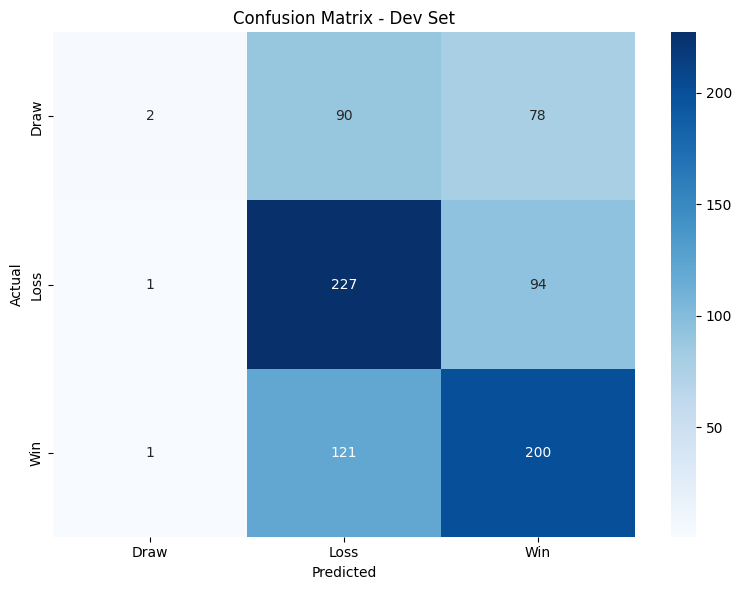

In [114]:
# Part 2: Development Set Evaluation

# Evaluate on dev set
dev_preds = adaboost.predict(dev_scaled)
dev_accuracy = accuracy_score(dev["Result"], dev_preds)
print(f"Dev Set Accuracy: {dev_accuracy:.4f}")
print()
print(f"Dev Set Classification Report:\n", classification_report(dev["Result"], dev_preds, target_names=["Draw", "Loss", "Win"]))

# Create confusion matrix for dev set
cm_dev = confusion_matrix(dev["Result"], dev_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dev, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Draw", "Loss", "Win"],
            yticklabels=["Draw", "Loss", "Win"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Dev Set')
plt.tight_layout()
plt.show()

### 6.1.3: Test Set Evaluation


The **final AdaBoost model** is then evaluated on the **test set** (data from 2024 onward). **Accuracy** declines to **47.79%**, and **draw** predictions remain notably weak, with near-zero **recall**. This outcome highlights the need for further adjustments—such as additional feature refinement, hyperparameter tuning, or class-balancing techniques—to improve overall **predictive** performance.

Test Set Accuracy: 0.4779

Test Set Classification Report:
               precision    recall  f1-score   support

        Draw       0.00      0.00      0.00       208
        Loss       0.47      0.71      0.57       304
         Win       0.50      0.57      0.53       304

    accuracy                           0.48       816
   macro avg       0.32      0.43      0.37       816
weighted avg       0.36      0.48      0.41       816



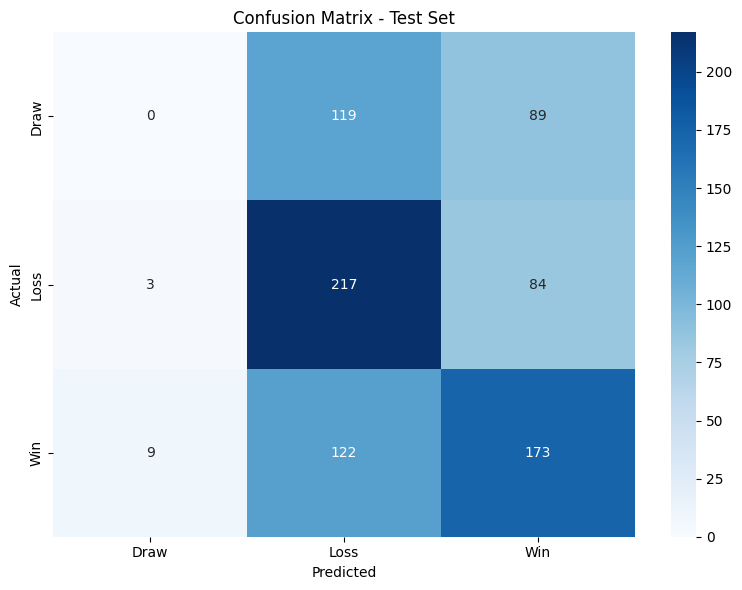


Model Performance Comparison:
AdaBoost - Dev Accuracy: 0.5270, Test Accuracy: 0.4779


In [115]:
# Part 3: Test Set Evaluation

# Evaluate on test set
test_preds = adaboost.predict(test_scaled)
test_accuracy = accuracy_score(test["Result"], test_preds)
print(f"Test Set Accuracy: {test_accuracy:.4f}")
print()
print(f"Test Set Classification Report:\n", classification_report(test["Result"], test_preds, target_names=["Draw", "Loss", "Win"]))

# Create confusion matrix for test set
cm_test = confusion_matrix(test["Result"], test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Draw", "Loss", "Win"],
            yticklabels=["Draw", "Loss", "Win"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.show()

print("\nModel Performance Comparison:")
print(f"AdaBoost - Dev Accuracy: {dev_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

Overall, the **initial AdaBoost model** delivers moderate accuracy but struggles to capture draws. Future efforts may involve **class-balancing** strategies (e.g., **SMOTE**), enhanced feature engineering, and deeper hyperparameter tuning to address these limitations.

## 6.2: **Enhanced AdaBoost Model** with **SMOTE-Based** Class Balancing and Hyperparameter Tuning

### 6.2.1: SMOTE for Class Balancing

The **training portion** of the dataset highlights an imbalance of **890 draws** versus **1524 losses** and **1524 wins**. A **StandardScaler** ensures consistent feature scaling. **SMOTE** then raises the minority class (draw) to **1524**, matching the larger classes and resulting in **4572** total training samples. The output confirms the distribution before and after SMOTE, visualizing this shift via count plots.


Class distribution before SMOTE:
Counter({Draw 890, Loss 1524, Win 1524})


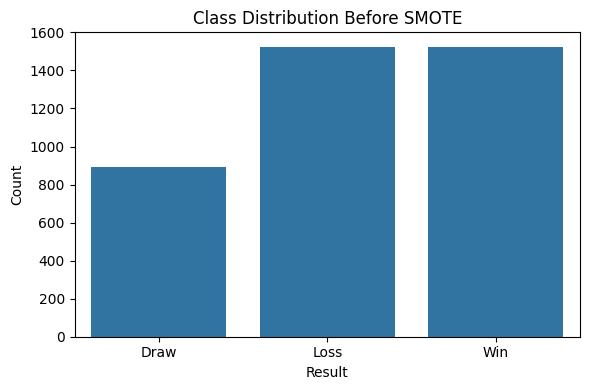


Class distribution after SMOTE:
Counter({Draw 1524, Loss 1524, Win 1524})
Total samples after SMOTE: 4572


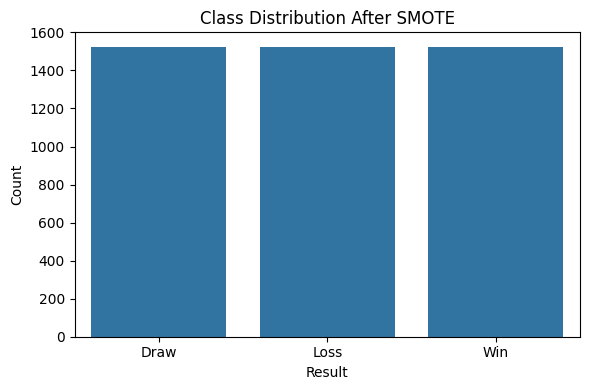

In [116]:
# Part 1: Model Setup with SMOTE for Class Balancing

# Prepare training data
X_train = train[predictors]
y_train = train["Result"]

# --- Check Class Distribution BEFORE SMOTE ---
print("Class distribution before SMOTE:")
class_counts = Counter(y_train)
print(f"Counter({{Draw {class_counts[0]}, Loss {class_counts[1]}, Win {class_counts[2]}}})")

# Visualize class distribution BEFORE SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Result')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['Draw', 'Loss', 'Win'])
plt.tight_layout()
plt.show()

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply SMOTE for balancing classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# --- Check Class Distribution AFTER SMOTE ---
print("\nClass distribution after SMOTE:")
class_counts = Counter(y_train_smote)
print(f"Counter({{Draw {class_counts[0]}, Loss {class_counts[1]}, Win {class_counts[2]}}})")
print(f"Total samples after SMOTE: {len(y_train_smote)}")

# Visualize class distribution AFTER SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_smote)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Result')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['Draw', 'Loss', 'Win'])
plt.tight_layout()
plt.show()

# Transform dev and test sets using the same scaler
X_dev = dev[predictors]
y_dev = dev["Result"]
X_dev_scaled = scaler.transform(X_dev)

X_test = test[predictors]
y_test = test["Result"]
X_test_scaled = scaler.transform(X_test)

### 6.2.2: AdaBoost Tuning with Grid Search

A **grid search** explores combinations of **tree depth**, **number of estimators**, **learning rate**, and **algorithm type (SAMME)** on the **SMOTE-adjusted** training data. This process identifies an **optimal parameter set** for AdaBoost, which is retrained on the balanced samples. The search completes in approximately **137.69 seconds**, producing a tuned model that emphasizes balanced performance across classes.


Fitting 5 folds for each of 36 candidates, totalling 180 fits
SMOTE Grid search completed in 150.92 seconds


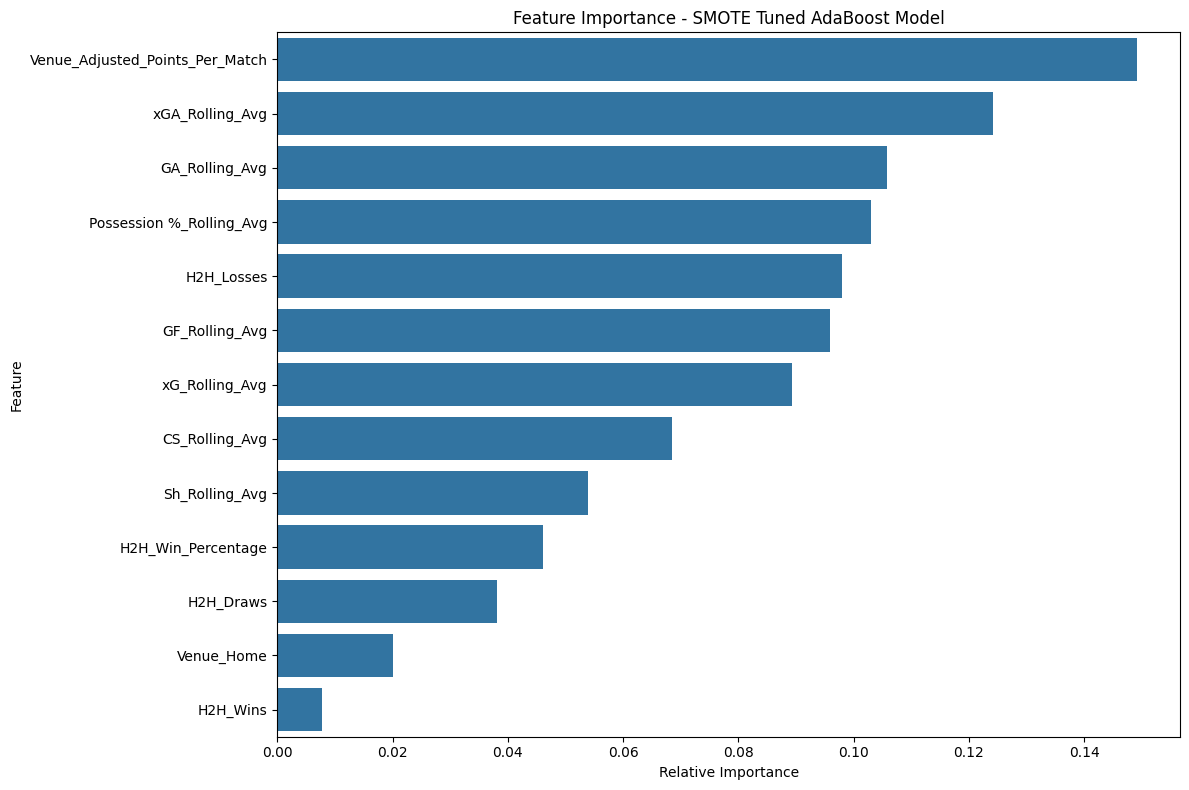

In [117]:
# Part 2: AdaBoost Model Tuning with Grid Search

# Set up grid search parameters for AdaBoost
param_grid = {
    'estimator': [DecisionTreeClassifier(max_depth=d) for d in [1, 2, 3]],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.5, 0.8, 1.0, 1.2],
    'algorithm': ['SAMME']  # Using SAMME to avoid errors with SAMME.R
}

adaboost_base = AdaBoostClassifier(random_state=42)
grid_search = GridSearchCV(estimator=adaboost_base, param_grid=param_grid,
                           scoring='f1_weighted', cv=5, n_jobs=-1, verbose=1)
start_time = time.time()
grid_search.fit(X_train_smote, y_train_smote)
print(f"SMOTE Grid search completed in {time.time() - start_time:.2f} seconds")

best_params_smote = grid_search.best_params_

# Create and train the best AdaBoost model using the best parameters
best_adaboost_smote = AdaBoostClassifier(
    estimator=best_params_smote['estimator'],
    n_estimators=best_params_smote['n_estimators'],
    learning_rate=best_params_smote['learning_rate'],
    algorithm=best_params_smote['algorithm'],
    random_state=42
)
best_adaboost_smote.fit(X_train_smote, y_train_smote)

# Calculate feature importance
feature_importance = best_adaboost_smote.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': predictors,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance - SMOTE Tuned AdaBoost Model')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

### 6.2.3: Development Set Evaluation

The tuned **SMOTE-based AdaBoost** model is tested on the **development set**, achieving an **accuracy** of **49.26%** and a **weighted F1 score** of **48.52%**. Draws improve compared to the heavily skewed original data, but the classification report reveals that **losses** and **wins** still outperform draws, underscoring persistent challenges in capturing the draw class.

Dev Set Accuracy: 0.4926
Dev Set Weighted F1 Score: 0.4852

Dev Set Classification Report:
              precision    recall  f1-score   support

        Draw       0.30      0.22      0.26       170
        Loss       0.51      0.57      0.54       322
         Win       0.55      0.56      0.55       322

    accuracy                           0.49       814
   macro avg       0.45      0.45      0.45       814
weighted avg       0.48      0.49      0.49       814



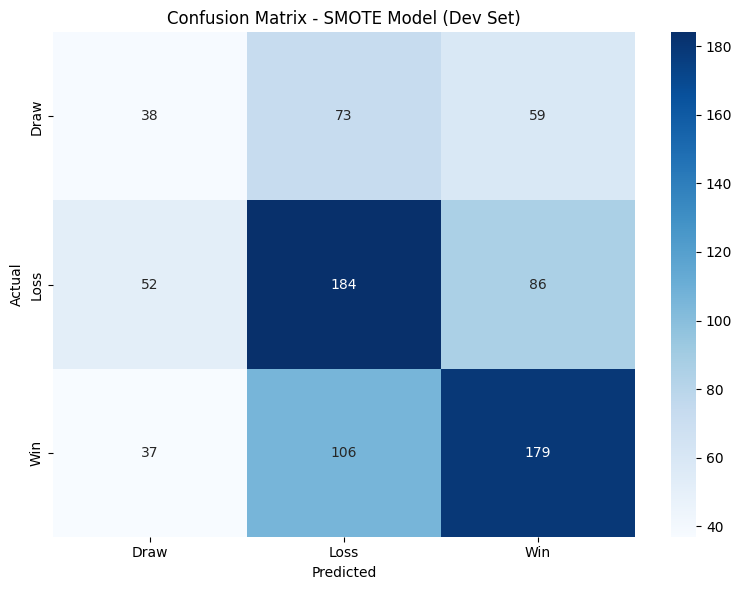

In [118]:
# Part 3: Development Set Evaluation

# Evaluate on the development set
dev_preds_smote = best_adaboost_smote.predict(X_dev_scaled)
dev_accuracy_smote = accuracy_score(y_dev, dev_preds_smote)
dev_f1_smote = f1_score(y_dev, dev_preds_smote, average='weighted')

print(f"Dev Set Accuracy: {dev_accuracy_smote:.4f}")
print(f"Dev Set Weighted F1 Score: {dev_f1_smote:.4f}\n")
print("Dev Set Classification Report:")
print(classification_report(y_dev, dev_preds_smote, target_names=["Draw", "Loss", "Win"]))

# Plot the confusion matrix for the development set
cm_dev_smote = confusion_matrix(y_dev, dev_preds_smote)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dev_smote, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Draw", "Loss", "Win"],
            yticklabels=["Draw", "Loss", "Win"])
plt.title('Confusion Matrix - SMOTE Model (Dev Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### 6.2.4: Test Set Evaluation

The same model is then evaluated on the **test set**, yielding **46.08% accuracy** and a **weighted F1 score** of **45.05%**. Draw predictions improve relative to the original imbalance. However, the draw class remains underrepresented. **Loss** and **win** classes retain higher recall, indicating partial success in balancing but also highlighting a need for further refinement.

Test Set Accuracy: 0.4608
Test Set Weighted F1 Score: 0.4505

Test Set Classification Report:
              precision    recall  f1-score   support

        Draw       0.29      0.21      0.24       208
        Loss       0.49      0.60      0.54       304
         Win       0.51      0.49      0.50       304

    accuracy                           0.46       816
   macro avg       0.43      0.43      0.43       816
weighted avg       0.45      0.46      0.45       816



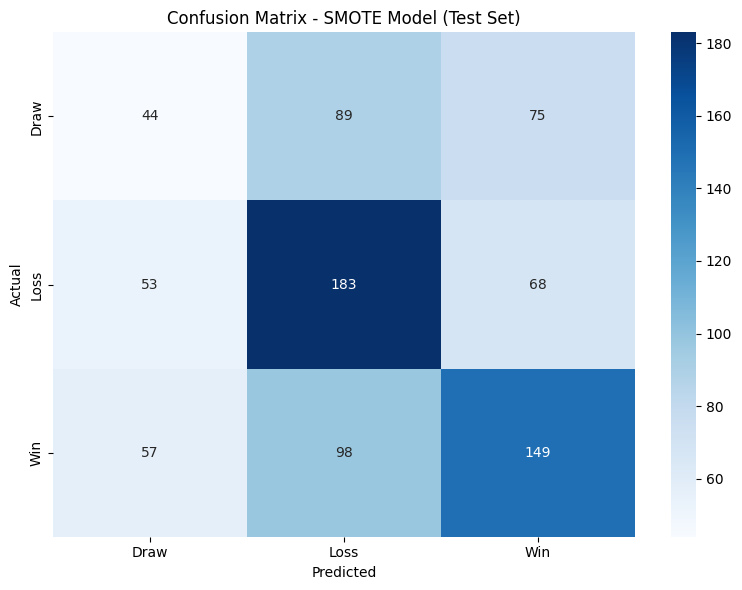

In [119]:
# Part 4: Test Set Evaluation

# Evaluate on the test set
test_preds_smote = best_adaboost_smote.predict(X_test_scaled)
test_accuracy_smote = accuracy_score(y_test, test_preds_smote)
test_f1_smote = f1_score(y_test, test_preds_smote, average='weighted')

print(f"Test Set Accuracy: {test_accuracy_smote:.4f}")
print(f"Test Set Weighted F1 Score: {test_f1_smote:.4f}\n")
print("Test Set Classification Report:")
print(classification_report(y_test, test_preds_smote, target_names=["Draw", "Loss", "Win"]))


# Plot the confusion matrix for the test set
cm_test_smote = confusion_matrix(y_test, test_preds_smote)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_smote, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Draw", "Loss", "Win"],
            yticklabels=["Draw", "Loss", "Win"])
plt.title('Confusion Matrix - SMOTE Model (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


In [120]:
# Storing performance metrics
smote_metrics = {
    'dev_accuracy': dev_accuracy_smote,
    'dev_recall': {
         'Draw': classification_report(y_dev, dev_preds_smote, output_dict=True).get('0', {}).get('recall'),
         'Loss': classification_report(y_dev, dev_preds_smote, output_dict=True).get('1', {}).get('recall'),
         'Win':  classification_report(y_dev, dev_preds_smote, output_dict=True).get('2', {}).get('recall')
    },
    'test_accuracy': test_accuracy_smote,
    'test_recall': {
         'Draw': classification_report(y_test, test_preds_smote, output_dict=True).get('0', {}).get('recall'),
         'Loss': classification_report(y_test, test_preds_smote, output_dict=True).get('1', {}).get('recall'),
         'Win':  classification_report(y_test, test_preds_smote, output_dict=True).get('2', {}).get('recall')
    }
}

### 6.2.5: Conclusion

This **SMOTE-based approach** addresses the **class imbalance** by aligning draw instances with losses and wins. The **grid search** hyperparameter tuning yields moderate gains over the original model, but the **draw** class still lags behind. Additional **feature engineering** and **alternative techniques** may be necessary to secure a more substantial boost in overall predictive accuracy. more substantial increase in overall predictive accuracy.

## 6.3: **AdaBoost Model** with **Class Weights** for Balancing


### 6.3.1: Weighted Class Setup

The training, development, and test sets remain unchanged from previous sections, and **StandardScaler** is applied to the training predictors. **Class weights** are then computed to address the imbalance of **890 draws** versus **1524 losses** and **1524 wins**. Draws receive a weight of **1.4749**, while losses and wins each receive **0.8613**, reflecting their original proportions without oversampling.


In [121]:
# Part 1: Model Setup with Class Weights for Balancing

# Prepare training data
X_train = train[predictors]
y_train = train["Result"]

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Compute balanced class weights
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print("\nComputed class weights:")
class_names = {0: 'Draw', 1: 'Loss', 2: 'Win'}
for cls, weight in class_weight_dict.items():
    print(f"Class {cls} ({class_names[cls]}): {weight:.4f}")

# Transform dev and test sets using the same scaler
X_dev = dev[predictors]
y_dev = dev["Result"]
X_dev_scaled = scaler.transform(X_dev)

X_test = test[predictors]
y_test = test["Result"]
X_test_scaled = scaler.transform(X_test)


Computed class weights:
Class 0 (Draw): 1.4749
Class 1 (Loss): 0.8613
Class 2 (Win): 0.8613


### 6.3.2: Tuning with Grid Search

A **TimeSeriesSplit** with five folds guides a **grid search** over **tree depths**, **number of estimators**, and **learning rates**, incorporating the **class_weight** settings in the **DecisionTreeClassifier**. The best parameters include **max_depth=3**, **learning_rate=0.8**, and **n_estimators=50**, yielding a model that emphasizes draw predictions more than a standard imbalance approach but still relies on a relatively small set of heavily weighted features.

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Class-Weighted Grid search completed in 8.35 seconds

Best parameters from Grid Search:
- max_depth: 3
- learning_rate: 0.8
- n_estimators: 50


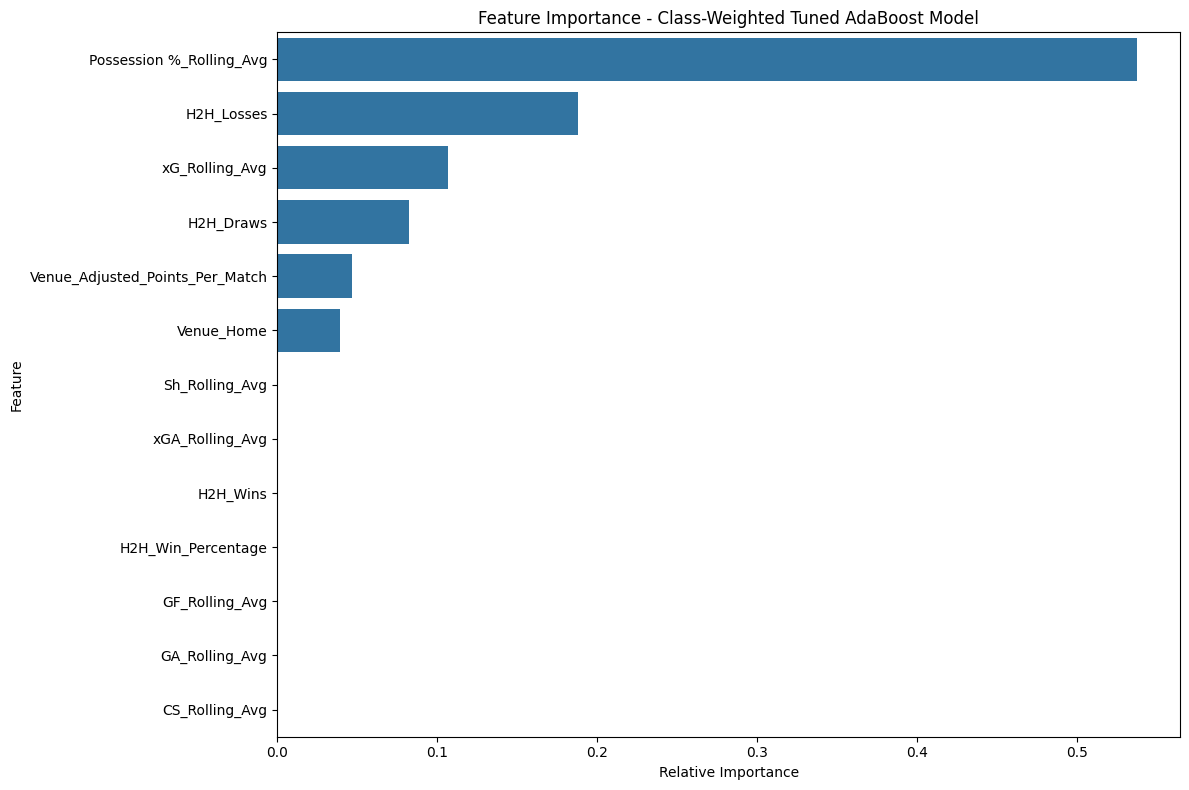

In [122]:
# Part 2: AdaBoost Model Tuning with Grid Search

# Set up grid search parameters for AdaBoost using a TimeSeriesSplit
time_series_cv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'estimator': [DecisionTreeClassifier(max_depth=d, class_weight=class_weight_dict) for d in [1, 2, 3]],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.5, 0.8, 1.0, 1.2],
}

adaboost_base = AdaBoostClassifier(random_state=42)
grid_search = GridSearchCV(estimator=adaboost_base, param_grid=param_grid,
                           scoring='f1_weighted', cv=time_series_cv, n_jobs=-1, verbose=1)
start_time = time.time()
grid_search.fit(X_train_scaled, y_train)
print(f"Class-Weighted Grid search completed in {time.time() - start_time:.2f} seconds")

best_params_cw = grid_search.best_params_
print("\nBest parameters from Grid Search:")
for key, value in best_params_cw.items():
    if key == 'estimator':
        print(f"- max_depth: {value.max_depth}")
    else:
        print(f"- {key}: {value}")

# Create and train the best AdaBoost model for the Class-Weighted approach
best_adaboost_cw = AdaBoostClassifier(
    estimator=best_params_cw['estimator'],
    n_estimators=best_params_cw['n_estimators'],
    learning_rate=best_params_cw['learning_rate'],
    random_state=42
)
best_adaboost_cw.fit(X_train_scaled, y_train)

# Visualize Feature Importance for the Tuned AdaBoost Model

feature_importance = best_adaboost_cw.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': predictors,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance - Class-Weighted Tuned AdaBoost Model')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

### 6.3.3: Development Set Evaluation

The tuned **class-weighted AdaBoost** model is applied to the development set, producing an **accuracy** of **49.14%** and a **weighted F1 score** of **46.18%**. Draw detection improves slightly over the unweighted scenario but still lags behind loss and win classes, indicating ongoing challenges in identifying draws, even when weights are assigned to offset their lower frequency.

Dev Set Accuracy: 0.4914
Dev Set Weighted F1 Score: 0.4618

Dev Set Classification Report:
              precision    recall  f1-score   support

        Draw       0.31      0.09      0.14       170
        Loss       0.52      0.55      0.54       322
         Win       0.49      0.64      0.56       322

    accuracy                           0.49       814
   macro avg       0.44      0.43      0.41       814
weighted avg       0.46      0.49      0.46       814



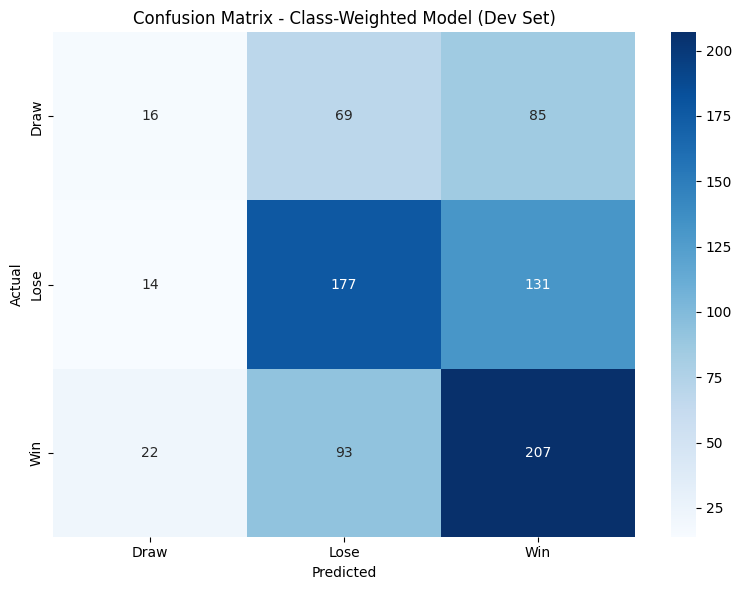

In [123]:
# Part 3: Development Set Evaluation

# Evaluate on the development set
dev_preds_cw = best_adaboost_cw.predict(X_dev_scaled)
dev_accuracy_cw = accuracy_score(y_dev, dev_preds_cw)
dev_f1_cw = f1_score(y_dev, dev_preds_cw, average='weighted')

print(f"Dev Set Accuracy: {dev_accuracy_cw:.4f}")
print(f"Dev Set Weighted F1 Score: {dev_f1_cw:.4f}\n")
print("Dev Set Classification Report:")
print(classification_report(y_dev, dev_preds_cw, target_names=["Draw", "Loss", "Win"]))

# Plot the confusion matrix for the development set
cm_dev_cw = confusion_matrix(y_dev, dev_preds_cw)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dev_cw, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Draw", "Lose", "Win"],
            yticklabels=["Draw", "Lose", "Win"])
plt.title('Confusion Matrix - Class-Weighted Model (Dev Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### 6.3.4: Test Set Evaluation

The same model achieves **44.00% accuracy** on the test set, with a **weighted F1 score** of **39.91%**. Draw predictions remain problematic, while loss and win classes maintain higher recall. Although class weighting shifts more focus to draws, the model still struggles to match the improvements observed with other balancing techniques.

Test Set Accuracy: 0.4400
Test Set Weighted F1 Score: 0.3991

Test Set Classification Report:
              precision    recall  f1-score   support

        Draw       0.22      0.06      0.09       208
        Loss       0.48      0.49      0.48       304
         Win       0.44      0.65      0.53       304

    accuracy                           0.44       816
   macro avg       0.38      0.40      0.37       816
weighted avg       0.40      0.44      0.40       816



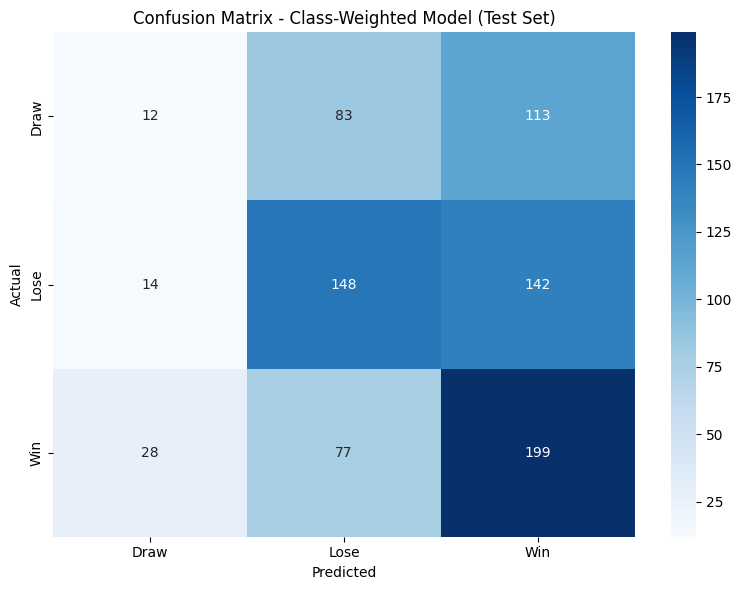

In [124]:
# Part 4: Test Set Evaluation

# Evaluate on the test set
test_preds_cw = best_adaboost_cw.predict(X_test_scaled)
test_accuracy_cw = accuracy_score(y_test, test_preds_cw)
test_f1_cw = f1_score(y_test, test_preds_cw, average='weighted')

print(f"Test Set Accuracy: {test_accuracy_cw:.4f}")
print(f"Test Set Weighted F1 Score: {test_f1_cw:.4f}\n")
print("Test Set Classification Report:")
print(classification_report(y_test, test_preds_cw, target_names=["Draw", "Loss", "Win"]))

# Plot the confusion matrix for the test set
cm_test_cw = confusion_matrix(y_test, test_preds_cw)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_cw, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Draw", "Lose", "Win"],
            yticklabels=["Draw", "Lose", "Win"])
plt.title('Confusion Matrix - Class-Weighted Model (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [125]:
# Storing performance metrics
class_weight_metrics = {
    'dev_accuracy': dev_accuracy_cw,
    'dev_recall': {
         'Draw': classification_report(y_dev, dev_preds_cw, output_dict=True).get('0', {}).get('recall'),
         'Loss': classification_report(y_dev, dev_preds_cw, output_dict=True).get('1', {}).get('recall'),
         'Win':  classification_report(y_dev, dev_preds_cw, output_dict=True).get('2', {}).get('recall')
    },
    'test_accuracy': test_accuracy_cw,
    'test_recall': {
         'Draw': classification_report(y_test, test_preds_cw, output_dict=True).get('0', {}).get('recall'),
         'Loss': classification_report(y_test, test_preds_cw, output_dict=True).get('1', {}).get('recall'),
         'Win':  classification_report(y_test, test_preds_cw, output_dict=True).get('2', {}).get('recall')
    }
}

### 6.3.5: Observations

In the **class-weighted model**, only a few features receive substantial importance because the algorithm reweights classes rather than **resampling** data. Conversely, **SMOTE** compels the model to learn from a larger number of draw instances, distributing feature importance more evenly and typically yielding better draw recall. This difference suggests that **SMOTE** remains a stronger choice for capturing minority classes, despite sometimes reducing accuracy for majority classes. Further **feature engineering**, deeper **hyperparameter tuning**, and more advanced **balancing strategies** could improve consistency across all outcomes.

## 6.4: Comparative Performance Analysis — SMOTE vs. Class-Weighted AdaBoost Models

### 6.4.1: Overview

Two balancing strategies, **SMOTE** and **Class Weights**, were applied to an **AdaBoost** model to measure their impact on **accuracy** and **class-specific recall** for **Draw**, **Loss**, and **Win**. Performance metrics were aggregated into a single framework, and bar charts compared development/test accuracies and recalls.


### 6.4.2: Findings

**SMOTE** achieved approximately **49.26%** accuracy on the development set and **46.08%** on the test set. Draw recall was noticeably higher than in the class-weighted approach, offering a more balanced performance across classes. The **Class-Weighted** model reached about **49.14%** accuracy on the development set but fell to **44.00%** on the test set. While it showed slightly better recall for the Win class, the Draw class remained difficult to detect.

In [126]:
# Combine metrics into a single dictionary for visualization. (Table format would be better)
# Here, we're comparing the SMOTE and Class-Weighted models.
performance_metrics = {
    'SMOTE': {
         'Dev Accuracy': smote_metrics['dev_accuracy'],
         'Test Accuracy': smote_metrics['test_accuracy'],
         'Dev Recall Draw': smote_metrics['dev_recall']['Draw'],
         'Dev Recall Loss': smote_metrics['dev_recall']['Loss'],
         'Dev Recall Win':  smote_metrics['dev_recall']['Win'],
         'Test Recall Draw': smote_metrics['test_recall']['Draw'],
         'Test Recall Loss': smote_metrics['test_recall']['Loss'],
         'Test Recall Win':  smote_metrics['test_recall']['Win']
    },
    'Class-Weighted': {
         'Dev Accuracy': class_weight_metrics['dev_accuracy'],
         'Test Accuracy': class_weight_metrics['test_accuracy'],
         'Dev Recall Draw': class_weight_metrics['dev_recall']['Draw'],
         'Dev Recall Loss': class_weight_metrics['dev_recall']['Loss'],
         'Dev Recall Win':  class_weight_metrics['dev_recall']['Win'],
         'Test Recall Draw': class_weight_metrics['test_recall']['Draw'],
         'Test Recall Loss': class_weight_metrics['test_recall']['Loss'],
         'Test Recall Win':  class_weight_metrics['test_recall']['Win']
    }
}

# Convert the dictionary into a DataFrame for easier plotting
df_perf = pd.DataFrame(performance_metrics).T

# Print the performance metrics in a table for reference
styled_df = df_perf.style.format("{:.4f}")
display(styled_df)

,Dev Accuracy,Test Accuracy,Dev Recall Draw,Dev Recall Loss,Dev Recall Win,Test Recall Draw,Test Recall Loss,Test Recall Win
SMOTE,0.4926,0.4608,0.2235,0.5714,0.5559,0.2115,0.6020,0.4901
Class-Weighted,0.4914,0.4400,0.0941,0.5497,0.6429,0.0577,0.4868,0.6546


### 6.4.3: Chosen Approach: SMOTE

SMOTE **actively re-samples** the minority class (Draw), forcing the model to learn from a larger set of draw instances. This approach **raises draw recall** and promotes more balanced class performance, though it may slightly lower overall accuracy for losses or wins. Class weighting, in contrast, **reweights** the training process without significantly altering the distribution, resulting in less improvement for the draw class. In scenarios where capturing draws is critical, **SMOTE** proves more effective, despite some trade-offs in other classes. Thus, SMOTE is the chosen class-balancing approach for future development

# Section 7: Further Feature Exploration

**In this section, further feature exploration is conducted on the premise of improving overall performance and draw recall of the model.**



## 7.1: Feature Importance Analysis

### 7.1.1: Random Forest Feature Importance

A **Random Forest classifier** with 100 estimators was trained on the scaled training data to evaluate **impurity-based feature importance**. The top predictors reflect both team quality metrics and pre-match performance indicators, with **FIFA Midfield Rating Diff ranking highest, followed by FIFA Overall Rating Diff, Goal_Difference_Comparison_Before_Match, FIFA Defense Rating Diff, and FIFA Attack Rating Diff**. These findings suggest that **rating differences and recent performance measures** hold substantial predictive value. The following output lists the top 10 features, while the accompanying bar chart illustrates the top 20 in descending order of importance:

Calculating Random Forest feature importance...


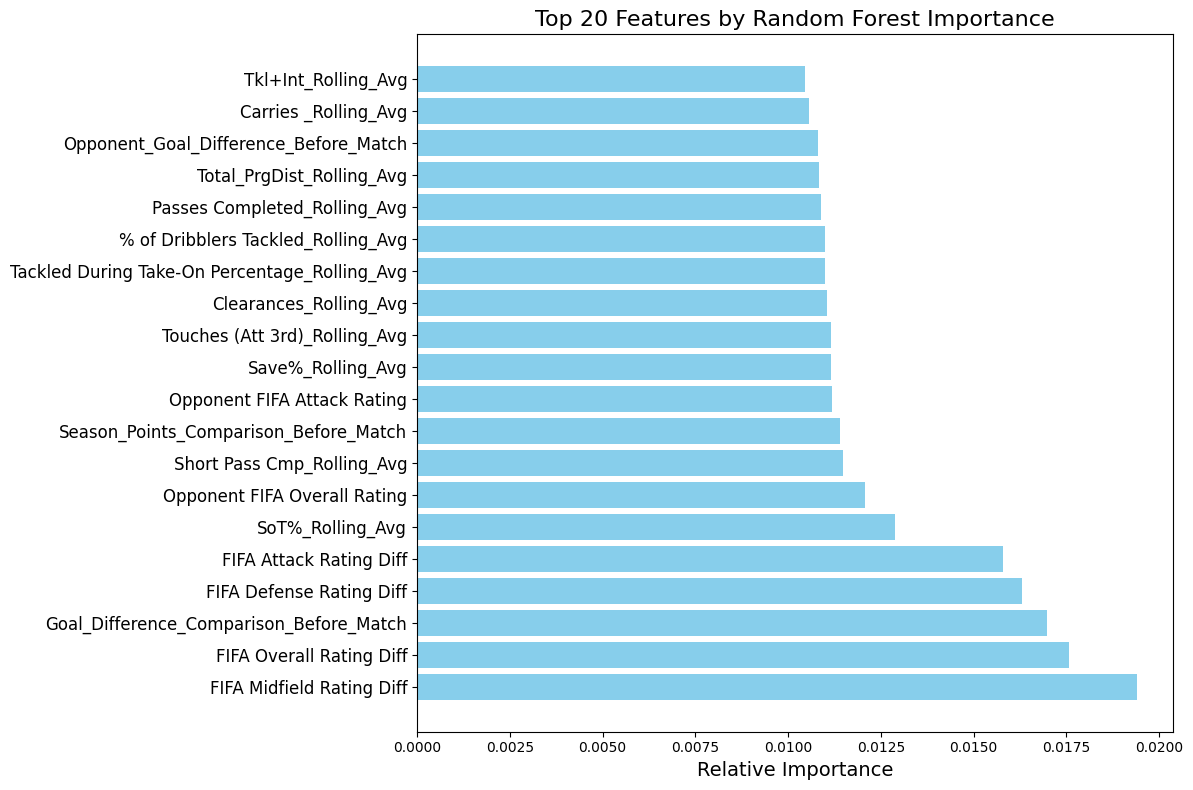


Top 10 Features by Random Forest Importance:
1. FIFA Midfield Rating Diff: 0.0194
2. FIFA Overall Rating Diff: 0.0176
3. Goal_Difference_Comparison_Before_Match: 0.0170
4. FIFA Defense Rating Diff: 0.0163
5. FIFA Attack Rating Diff: 0.0158
6. SoT%_Rolling_Avg: 0.0129
7. Opponent FIFA Overall Rating: 0.0121
8. Short Pass Cmp_Rolling_Avg: 0.0115
9. Season_Points_Comparison_Before_Match: 0.0114
10. Opponent FIFA Attack Rating: 0.0112


In [127]:
# Original feature set (for comparison)
original_features = [
    'xG_Rolling_Avg', 'xGA_Rolling_Avg', 'Sh_Rolling_Avg', 'Possession %_Rolling_Avg',
    'Venue_Adjusted_Points_Per_Match', 'H2H_Wins', 'H2H_Draws', 'H2H_Losses',
    'H2H_Win_Percentage', 'GF_Rolling_Avg', 'GA_Rolling_Avg', 'CS_Rolling_Avg', 'Venue_Home'
]

# Set up data for feature importance analysis
X_train = train.drop(['Date', 'Result'], axis=1)
y_train = train["Result"]
feature_names = X_train.columns

# Random Forest for feature importance
print("Calculating Random Forest feature importance...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Create a DataFrame for feature importance
rf_importance_df = pd.DataFrame({
    'Feature': [feature_names[i] for i in indices],
    'Importance': importances[indices]
})

# Visualize top features by importance
plt.figure(figsize=(12, 8))
plt.title('Top 20 Features by Random Forest Importance', fontsize=16)
plt.barh(range(20), rf_importance_df['Importance'][:20], color='skyblue', align='center')
plt.yticks(range(20), rf_importance_df['Feature'][:20], fontsize=12)
plt.xlabel('Relative Importance', fontsize=14)
plt.tight_layout()
plt.show()

# Print top features
print("\nTop 10 Features by Random Forest Importance:")
for i, (feature, importance) in enumerate(rf_importance_df.head(10).itertuples(index=False)):
    print(f"{i+1}. {feature}: {importance:.4f}")

### 7.1.2: Mutual Information

**Mutual Information** quantifies the degree to which **knowing a feature reduces uncertainty about the outcome**. This model-agnostic measure reinforces the **importance of FIFA rating differences, with FIFA Overall Rating Diff and FIFA Midfield Rating Diff again emerging as the most influential variables**. **Season_Points_Comparison_Before_Match and Goal_Difference_Comparison_Before_Matc**h also appear prominently, underscoring the **significance of historical performance data**. The output below shows the top 10 features, while the bar chart highlights the top 20:

Calculating Mutual Information scores...


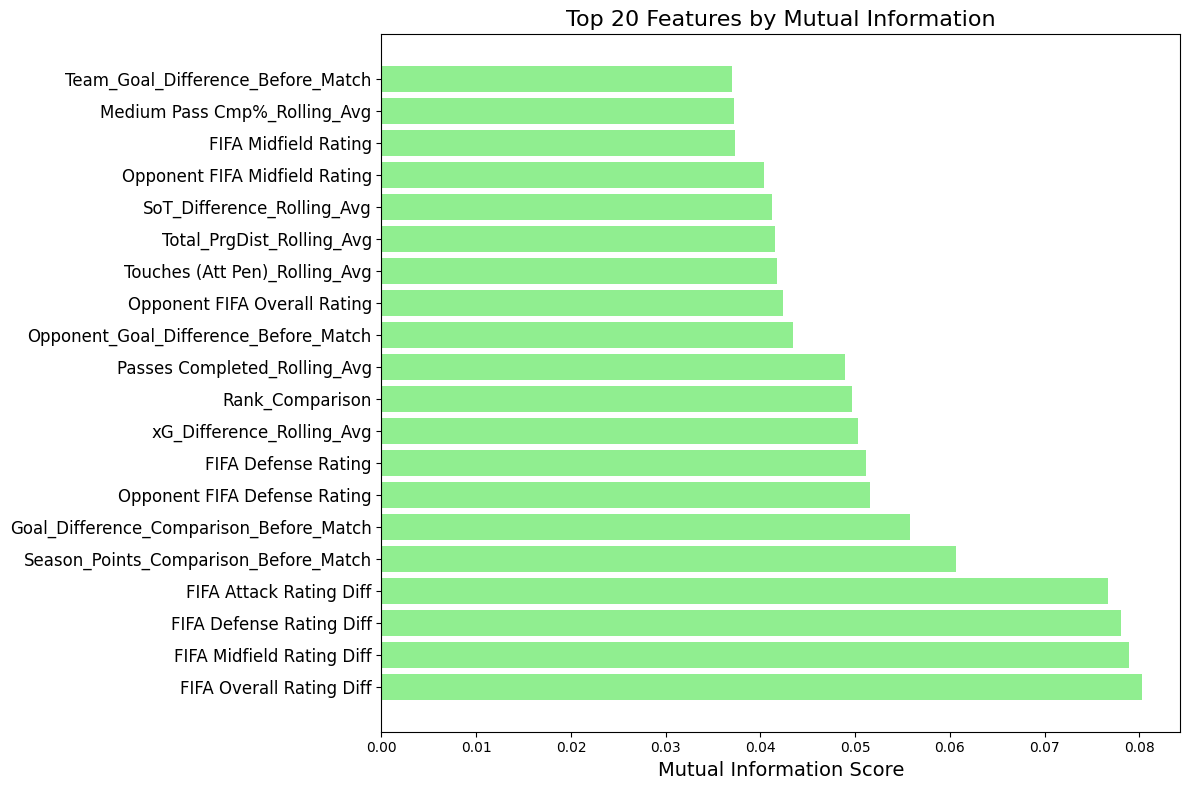


Top 10 Features by Mutual Information:
1. FIFA Overall Rating Diff: 0.0803
2. FIFA Midfield Rating Diff: 0.0789
3. FIFA Defense Rating Diff: 0.0781
4. FIFA Attack Rating Diff: 0.0767
5. Season_Points_Comparison_Before_Match: 0.0606
6. Goal_Difference_Comparison_Before_Match: 0.0558
7. Opponent FIFA Defense Rating: 0.0516
8. FIFA Defense Rating: 0.0511
9. xG_Difference_Rolling_Avg: 0.0503
10. Rank_Comparison: 0.0496


In [128]:
# Mutual Information for feature selection
print("Calculating Mutual Information scores...")
# Scale features for better MI calculation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Calculate mutual information
mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=42)
mi_df = pd.DataFrame({'Feature': feature_names, 'MI Score': mi_scores})
mi_df = mi_df.sort_values('MI Score', ascending=False)

# Visualize top features by mutual information
plt.figure(figsize=(12, 8))
plt.title('Top 20 Features by Mutual Information', fontsize=16)
plt.barh(range(20), mi_df['MI Score'][:20], color='lightgreen', align='center')
plt.yticks(range(20), mi_df['Feature'][:20], fontsize=12)
plt.xlabel('Mutual Information Score', fontsize=14)
plt.tight_layout()
plt.show()

print("\nTop 10 Features by Mutual Information:")
for i, (feature, score) in enumerate(mi_df.head(10).itertuples(index=False)):
    print(f"{i+1}. {feature}: {score:.4f}")

Both methods highlight the consistent impact of **FIFA rating differences** and **historical performance metrics** (such as **goal difference** and **season points**) on match outcomes. Random Forest emphasizes these features through impurity reduction, while Mutual Information confirms their strong predictive influence from a model-agnostic perspective. This convergence suggests that **team quality** (as reflected by FIFA ratings) and **recent form** (as captured by performance comparisons) are critical to accurate match predictions.

## 7.2: **Feature Distributions by Match Outcome**

### 7.2.1: Overview

Selected features are examined to see how their values differ among **Draw (0)**, **Loss (1)**, and **Win (2)**. **Boxplots** and **descriptive statistics** highlight variations in team strength, recent form, and other key match metrics, offering insight into which factors may drive different outcomes.

### 7.2.2: Boxplot Analysis

Each subplot compares the distribution of a feature across the three result categories. The **median** is shown by the horizontal line in each box, while the **interquartile range (IQR)** and **outliers** provide additional context on variability. These plots suggest that higher values for certain metrics (e.g., **FIFA Overall Rating Diff**, **xG_Rolling_Avg**) often align with **wins** (result=2), whereas lower or negative values are more common in **draws** (result=0) or **losses** (result=1).

- **FIFA Overall Rating Diff**: Teams with larger positive differences tend to record wins, indicating a stronger comparative rating.  
- **Team_Season_Rank and Opponent_Season_Rank**: Better (lower) ranks favor wins, whereas facing a higher-ranked opponent can lead to a less favorable outcome.  
- **xG_Rolling_Avg and xGA_Rolling_Avg**: Strong offensive play (high xG) and robust defense (low xGA) correlate with wins.  
- **Unbeaten_Streak_Before_Match**: Longer streaks indicate positive momentum, generally aligning with more wins.  
- **Possession %_Rolling_Avg**: Teams that control possession are more likely to secure wins.  
- **Venue_Adjusted_Points_Per_Match**: Higher values indicate consistent performance across different venues, also favoring winning outcomes.

### 7.2.3: Descriptive Statistics

The code computes **mean** and **standard deviation** for each feature by outcome. **Draw (0)** typically exhibits more moderate values, **Loss (1)** often shows lower or negative rating differences and weaker offensive metrics, and **Win (2)** tends to display higher ratings, stronger offensive performance, and better overall form.

- **FIFA Overall Rating Diff**: Higher means for wins, lower or negative for draws and losses.  
- **Rank Metrics**: Lower (better) ranks correlate with more wins; higher (worse) ranks skew toward losses or draws.  
- **Offensive/Defensive Metrics (xG, xGA)**: Winning teams maintain higher xG means and lower xGA means, emphasizing the value of both attack and defense.  
- **Unbeaten Streak**: Wins often coincide with longer average unbeaten runs, reflecting momentum.  
- **Possession & Venue-Adjusted Points**: Higher possession percentages and stronger venue-adjusted points align with winning outcomes, suggesting overall control and consistency.

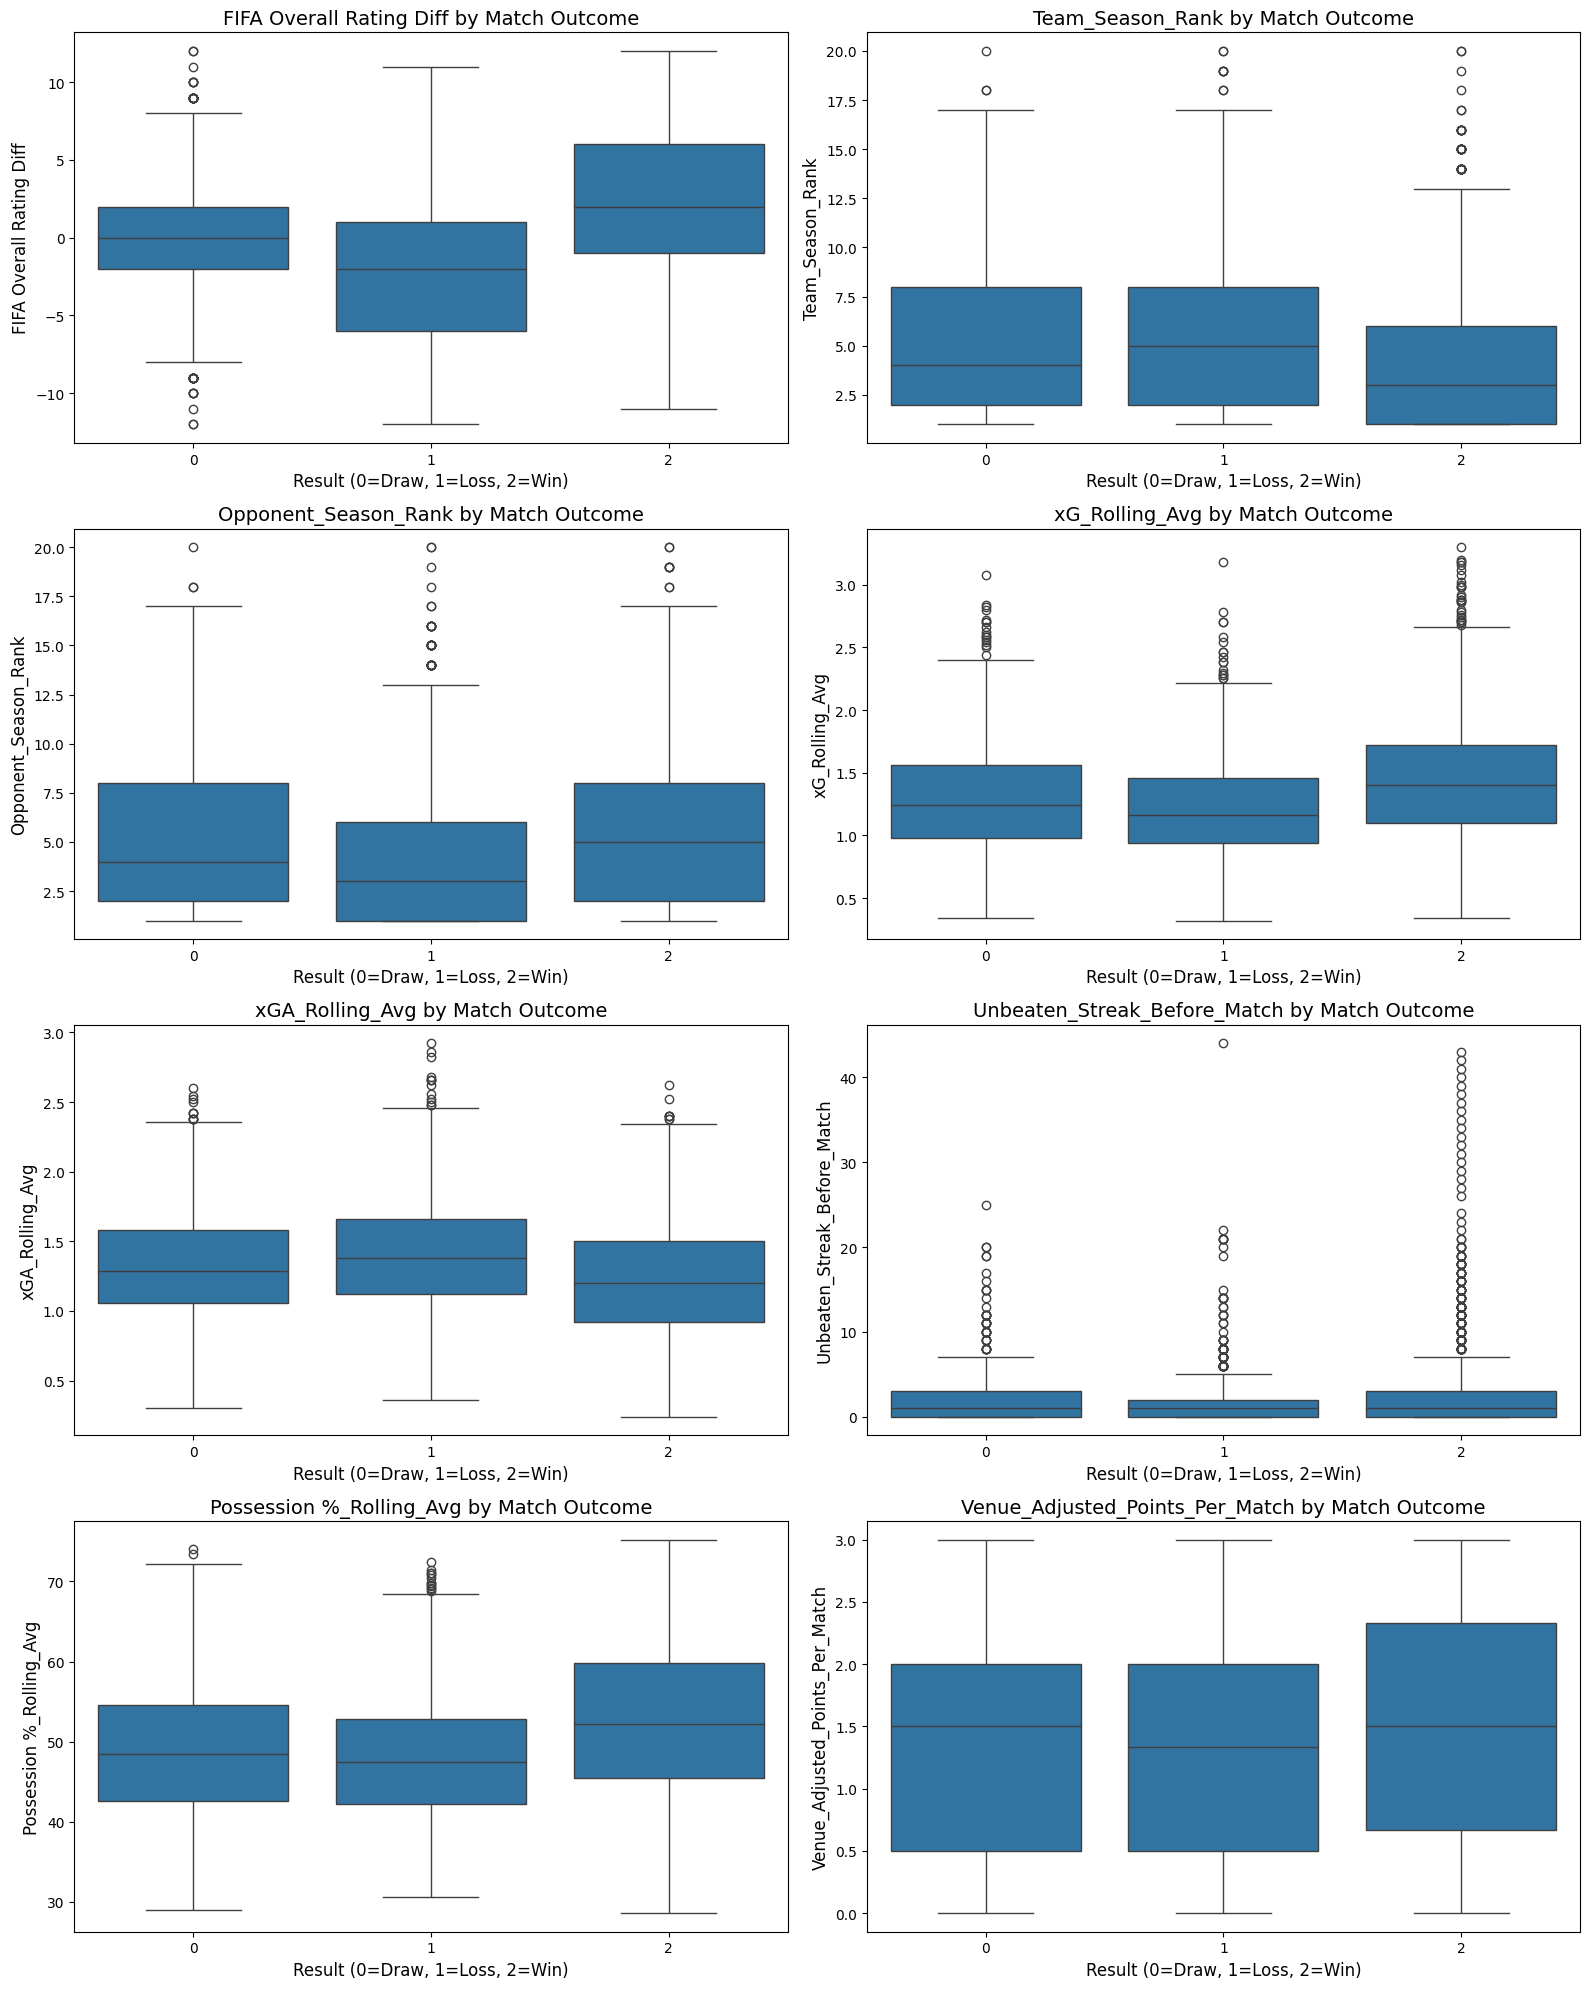


Feature distributions by match outcome:

FIFA Overall Rating Diff:
  Draw: Mean = 0.00, StdDev = 4.08
  Loss: Mean = -2.22, StdDev = 4.47
  Win: Mean = 2.22, StdDev = 4.47

Team_Season_Rank:
  Draw: Mean = 5.29, StdDev = 3.87
  Loss: Mean = 5.73, StdDev = 3.94
  Win: Mean = 4.28, StdDev = 3.63

Opponent_Season_Rank:
  Draw: Mean = 5.29, StdDev = 3.87
  Loss: Mean = 4.28, StdDev = 3.63
  Win: Mean = 5.73, StdDev = 3.94

xG_Rolling_Avg:
  Draw: Mean = 1.29, StdDev = 0.44
  Loss: Mean = 1.21, StdDev = 0.39
  Win: Mean = 1.45, StdDev = 0.49

xGA_Rolling_Avg:
  Draw: Mean = 1.33, StdDev = 0.41
  Loss: Mean = 1.40, StdDev = 0.40
  Win: Mean = 1.22, StdDev = 0.41

Unbeaten_Streak_Before_Match:
  Draw: Mean = 1.92, StdDev = 2.90
  Loss: Mean = 1.58, StdDev = 2.69
  Win: Mean = 3.07, StdDev = 5.22

Possession %_Rolling_Avg:
  Draw: Mean = 49.16, StdDev = 8.52
  Loss: Mean = 48.00, StdDev = 7.80
  Win: Mean = 52.65, StdDev = 9.27

Venue_Adjusted_Points_Per_Match:
  Draw: Mean = 1.36, StdDev = 0

In [129]:
# Analyze how key features are distributed by match outcome
key_features = [
    'FIFA Overall Rating Diff', 'Team_Season_Rank', 'Opponent_Season_Rank',
    'xG_Rolling_Avg', 'xGA_Rolling_Avg', 'Unbeaten_Streak_Before_Match',
    'Possession %_Rolling_Avg', 'Venue_Adjusted_Points_Per_Match'
]

# Create feature distribution visualizations
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    sns.boxplot(x='Result', y=feature, data=train, ax=axes[i])
    axes[i].set_title(f'{feature} by Match Outcome', fontsize=14)
    axes[i].set_xlabel('Result (0=Draw, 1=Loss, 2=Win)', fontsize=12)
    axes[i].set_ylabel(feature, fontsize=12)

plt.tight_layout()
plt.show()

# Print mean values by outcome for key features
print("\nFeature distributions by match outcome:")
for feature in key_features:
    print(f"\n{feature}:")
    for result in [0, 1, 2]:
        result_name = {0: "Draw", 1: "Loss", 2: "Win"}[result]
        mean_val = train[train['Result'] == result][feature].mean()
        std_val = train[train['Result'] == result][feature].std()
        print(f"  {result_name}: Mean = {mean_val:.2f}, StdDev = {std_val:.2f}")

### 7.2.4: Conclusion

These distributions confirm that **team quality** (via FIFA rating differences), **recent form** (unbeaten streak, season rank), and **key match metrics** (xG, xGA, possession) exhibit distinct patterns across draws, losses, and wins. Incorporating these insights into predictive models can improve **accuracy** by emphasizing features that best differe

## 7.3: **Feature Correlation Analysis**

### 7.3.1: Overview

A set of **top features** is drawn from Random Forest importance, Mutual Information scores, and the original predictor list. A **correlation matrix** is then calculated and visualized, highlighting how each feature relates to the others. This process helps identify where overlapping information might exist, potentially inflating model complexity without improving predictive performance.

### 7.3.2: Correlation Matrix

A heatmap displays pairwise correlations among these features, masking the upper triangle for clarity. **Red** cells indicate strong positive associations, while **blue** cells denote strong negative relationships. The code also prints any feature pairs whose correlation exceeds **±0.80**, revealing potential redundancy. Examples include **FIFA Midfield Rating Diff** and **FIFA Overall Rating Diff** at 0.95, **Possession %_Rolling_Avg** and **Total_PrgDist_Rolling_Avg** at 0.88, and **xG_Rolling_Avg** with **xG_Difference_Rolling_Avg** at 0.88. Such pairs convey largely the same information and may not all be necessary for modeling.

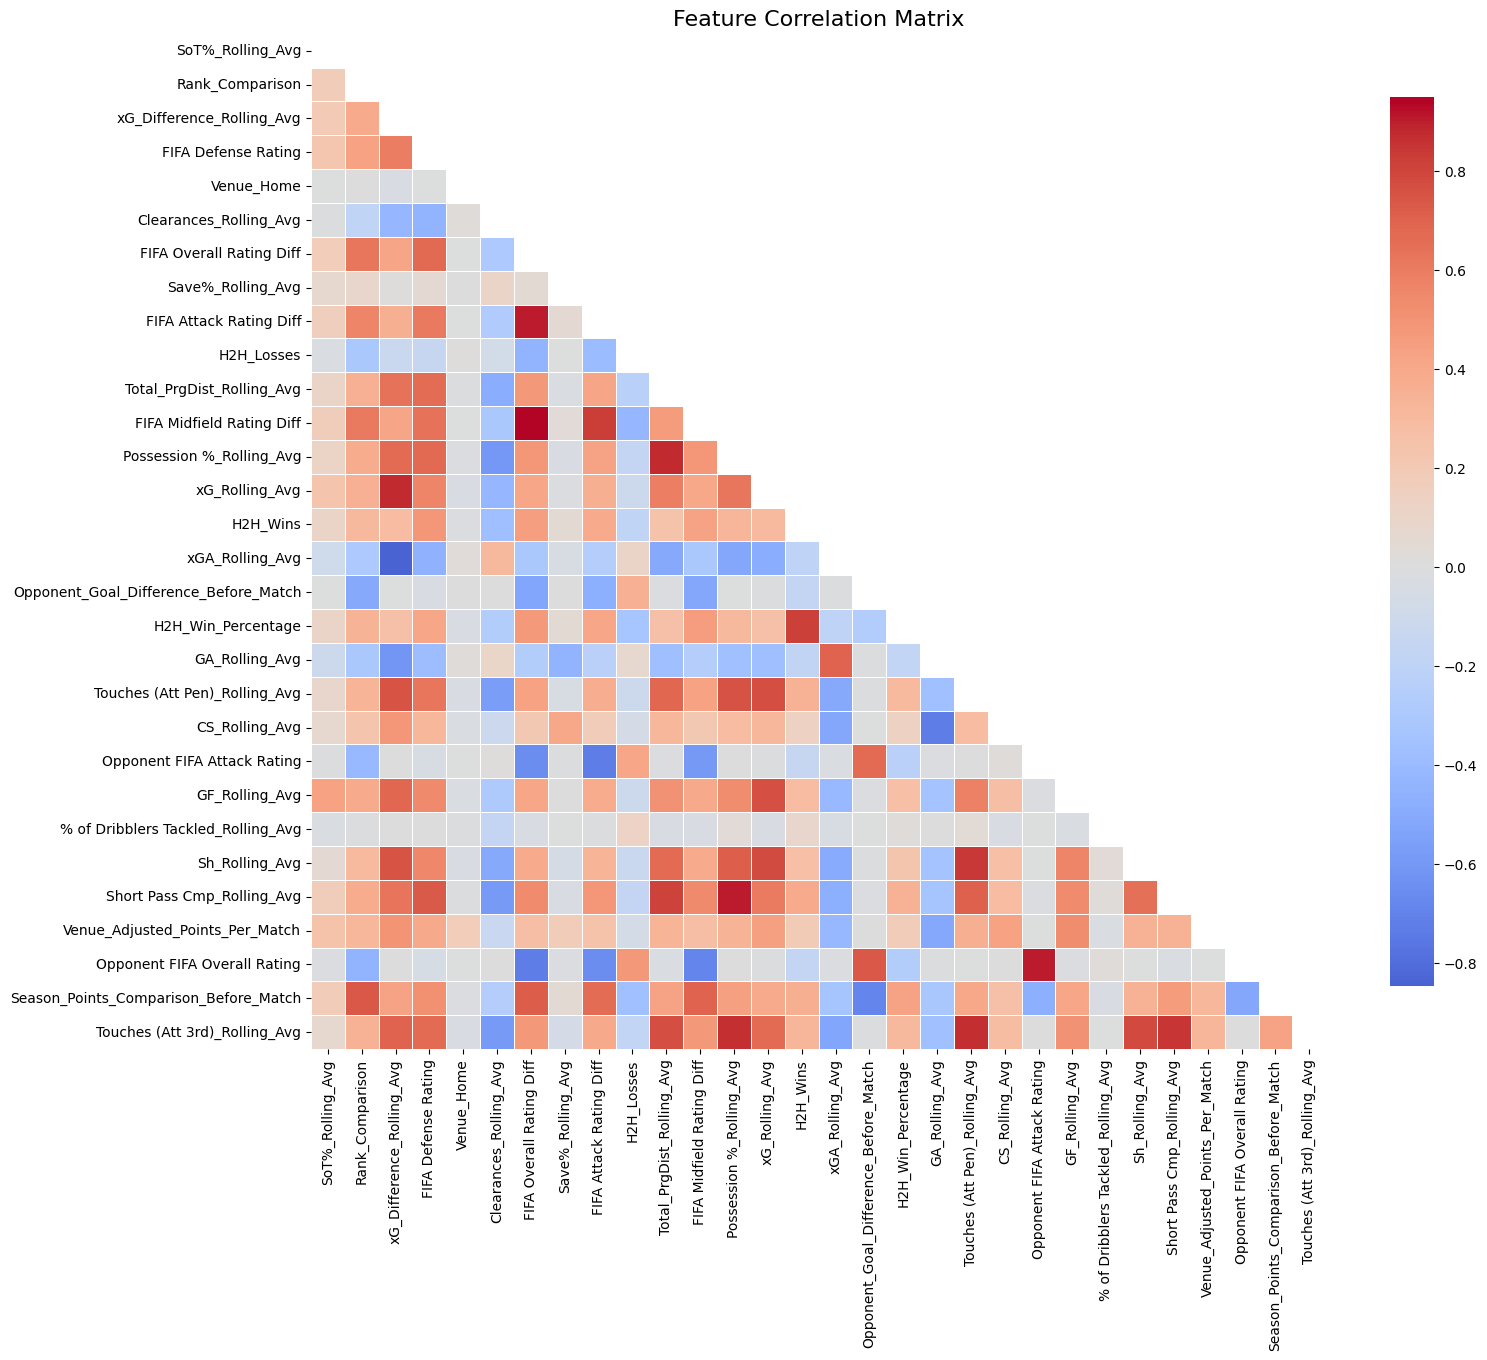


Highly correlated feature pairs (|correlation| > 0.8):
FIFA Attack Rating Diff & FIFA Overall Rating Diff: 0.90
FIFA Midfield Rating Diff & FIFA Overall Rating Diff: 0.95
FIFA Midfield Rating Diff & FIFA Attack Rating Diff: 0.83
Possession %_Rolling_Avg & Total_PrgDist_Rolling_Avg: 0.88
xG_Rolling_Avg & xG_Difference_Rolling_Avg: 0.88
xGA_Rolling_Avg & xG_Difference_Rolling_Avg: -0.85
H2H_Win_Percentage & H2H_Wins: 0.82
Sh_Rolling_Avg & Touches (Att Pen)_Rolling_Avg: 0.84
Short Pass Cmp_Rolling_Avg & Total_PrgDist_Rolling_Avg: 0.80
Short Pass Cmp_Rolling_Avg & Possession %_Rolling_Avg: 0.90
Opponent FIFA Overall Rating & Opponent FIFA Attack Rating: 0.90
Touches (Att 3rd)_Rolling_Avg & Possession %_Rolling_Avg: 0.86
Touches (Att 3rd)_Rolling_Avg & Touches (Att Pen)_Rolling_Avg: 0.87
Touches (Att 3rd)_Rolling_Avg & Short Pass Cmp_Rolling_Avg: 0.85


In [130]:
# Select top features for correlation analysis
top_features = list(set(
    rf_importance_df['Feature'][:15].tolist() +
    mi_df['Feature'][:15].tolist() +
    original_features
))[:30]  # Limit to top 30 unique features

# Calculate correlation matrix
corr_matrix = X_train[top_features].corr()

# Visualize correlation matrix
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=16)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Find highly correlated feature pairs
print("\nHighly correlated feature pairs (|correlation| > 0.8):")
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            print(f"{corr_matrix.columns[i]} & {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.2f}")

### 7.3.3: Key Observations
Based on the threshold (|ρ|> 0.80), the following feature pairs exhibit **strong correlations**:

| **Feature Pair**                                                      | **Correlation** |
|:-----------------------------------------------------------------------|----------------:|
| **Possession %_Rolling_Avg** & **Total_PrgDist_Rolling_Avg**          | 0.88            |
| **Short Pass Cmp_Rolling_Avg** & **Total_PrgDist_Rolling_Avg**        | 0.80            |
| **Short Pass Cmp_Rolling_Avg** & **Possession %_Rolling_Avg**         | 0.90            |
| **Opponent FIFA Attack Rating** & **Opponent FIFA Defense Rating**     | 0.84            |
| **Touches (Att Pen)_Rolling_Avg** & **Sh_Rolling_Avg**                | 0.84            |
| **FIFA Defense Rating Diff** & **FIFA Attack Rating Diff**            | 0.85            |
| **Touches (Att 3rd)_Rolling_Avg** & **Possession %_Rolling_Avg**      | 0.86            |
| **Touches (Att 3rd)_Rolling_Avg** & **Short Pass Cmp_Rolling_Avg**    | 0.85            |
| **Touches (Att 3rd)_Rolling_Avg** & **Touches (Att Pen)_Rolling_Avg** | 0.87            |
| **FIFA Midfield Rating Diff** & **FIFA Attack Rating Diff**           | 0.83            |
| **FIFA Midfield Rating Diff** & **FIFA Defense Rating Diff**          | 0.89            |
| **Opponent FIFA Overall Rating** & **Opponent FIFA Defense Rating**    | 0.94            |
| **Opponent FIFA Overall Rating** & **Opponent FIFA Attack Rating**     | 0.90            |
| **H2H_Wins** & **H2H_Win_Percentage**                                  | 0.82            |
| **Season_Points_Comparison_Before_Match** & **Goal_Difference_Comparison_Before_Match** | 0.95 |
| **Passes Completed_Rolling_Avg** & **Total_PrgDist_Rolling_Avg**      | 0.89            |
| **Passes Completed_Rolling_Avg** & **Possession %_Rolling_Avg**       | 0.95            |
| **Passes Completed_Rolling_Avg** & **Short Pass Cmp_Rolling_Avg**     | 0.97            |
| **Passes Completed_Rolling_Avg** & **Touches (Att 3rd)_Rolling_Avg**  | 0.85            |

**Observations**  
- **Passing Metrics and Possession:** Several passing statistics (e.g., short pass completion, passes completed) show high correlation with **possession** and **progressive distance**.  
- **FIFA Ratings:** **FIFA Midfield**, **Defense**, and **Attack Rating Differences** often correlate strongly with one another, suggesting overlapping information on team strength.  
- **Opponent Ratings:** **Opponent FIFA Overall**, **Attack**, and **Defense Ratings** similarly exhibit strong correlations, indicating they may be partially interchangeable for predictive purposes.  
- **Historical Metrics:** Features like **Season_Points_Comparison_Before_Match** and **Goal_Difference_Comparison_Before_Match** are also highly correlated, suggesting they capture similar aspects of prior performance.

### 7.3.4: Conclusion

High correlations exceeding **±0.80** point to potential duplication in predictive power. Eliminating or consolidating these features can simplify the model, reduce overfitting risk, and improve overall efficiency. Monitoring predictive performance after feature removal is essential to ensure accuracy remains consistent.

## 7.4 Iterative Correlation Removal

**Overview**  
This script iteratively removes features whose pairwise correlations exceed a specified threshold. By always discarding the **less important** feature (according to a precomputed Random Forest ranking), it preserves the more influential variable in each highly correlated pair.

**Key Steps**  
1. **Correlation Matrix Computation**: The script calculates the absolute correlation among the candidate features.  
2. **High-Correlation Detection**: Pairs exceeding the threshold (e.g., 0.8) are flagged for pruning.  
3. **Rank-Based Removal**: From each over-correlated pair, the feature with the **higher** (i.e., worse) importance rank is dropped.  
4. **Iteration**: The process repeats until no remaining feature pair exceeds the threshold.  
5. **Summary & Final Set**: It prints each removal, indicating which feature was kept, and optionally displays how each retained feature correlates with the target.

**Outcome**  
- A **pruned list** of features that are **less likely** to be redundant.  
- Each removal is justified by the **importance ranking**, ensuring the more impactful feature is retained.  
- The final set often helps improve model **efficiency** and **interpretability** by reducing collinearity.


In [131]:
# Iterative Removal Approach

# 1) Create a dictionary mapping each feature to its Random Forest rank.
rf_importance_rank = {}
for idx, row in rf_importance_df.iterrows():
    rf_importance_rank[row['Feature']] = idx

def iterative_corr_removal(X, features, importance_rank, threshold=0.8, y=None):

    pruned_features = features.copy()
    removed_features = []

    while True:
        # Compute the correlation matrix for current features
        corr_matrix = X[pruned_features].corr().abs()

        # Find all pairs that exceed the threshold
        high_corr_pairs = []
        for i in range(len(pruned_features)):
            for j in range(i + 1, len(pruned_features)):
                if corr_matrix.iloc[i, j] > threshold:
                    f1 = pruned_features[i]
                    f2 = pruned_features[j]
                    high_corr_pairs.append((f1, f2, corr_matrix.iloc[i, j]))

        if not high_corr_pairs:
            break

        # Select the pair with the highest correlation
        f1, f2, corr_val = max(high_corr_pairs, key=lambda x: x[2])

        # Determine which feature is less important (has higher rank index)
        f1_rank = importance_rank.get(f1, 999)  # default rank if not found
        f2_rank = importance_rank.get(f2, 999)

        # Remove the feature with the higher rank (less important)
        if f1_rank > f2_rank:
            print(f"Removing {f1} (correlated with {f2}, correlation={corr_val:.2f})")
            pruned_features.remove(f1)
            removed_features.append((f1, f2, corr_val))
        else:
            print(f"Removing {f2} (correlated with {f1}, correlation={corr_val:.2f})")
            pruned_features.remove(f2)
            removed_features.append((f2, f1, corr_val))

    # Print a summary of removed features and correlations
    if removed_features:
        print("\nSummary of removed features:")
        for (f_removed, f_kept, corr_val) in removed_features:
            print(f" - Removed {f_removed} (kept {f_kept}, correlation={corr_val:.2f})")

    # Compute correlation of final features with the target
    if y is not None:
        print("\nCorrelation of final features with the target:")
        for feat in pruned_features:
            feat_corr = X[feat].corr(y)
            print(f"  {feat}: {feat_corr:.2f}")

    return pruned_features

final_features_iterative = iterative_corr_removal(
    X_train,
    top_features,
    rf_importance_rank,
    threshold=0.8,
    y=y_train
)

print("\nFinal features after iterative correlation removal:")
print(final_features_iterative)


Removing FIFA Overall Rating Diff (correlated with FIFA Midfield Rating Diff, correlation=0.95)
Removing Opponent FIFA Attack Rating (correlated with Opponent FIFA Overall Rating, correlation=0.90)
Removing Possession %_Rolling_Avg (correlated with Short Pass Cmp_Rolling_Avg, correlation=0.90)
Removing xG_Rolling_Avg (correlated with xG_Difference_Rolling_Avg, correlation=0.88)
Removing Touches (Att Pen)_Rolling_Avg (correlated with Touches (Att 3rd)_Rolling_Avg, correlation=0.87)
Removing Touches (Att 3rd)_Rolling_Avg (correlated with Short Pass Cmp_Rolling_Avg, correlation=0.85)
Removing xGA_Rolling_Avg (correlated with xG_Difference_Rolling_Avg, correlation=0.85)
Removing FIFA Attack Rating Diff (correlated with FIFA Midfield Rating Diff, correlation=0.83)
Removing H2H_Wins (correlated with H2H_Win_Percentage, correlation=0.82)
Removing Total_PrgDist_Rolling_Avg (correlated with Short Pass Cmp_Rolling_Avg, correlation=0.80)

Summary of removed features:
 - Removed FIFA Overall Ratin

## 7.5 Clustering-Based Correlation Removal

**Overview**  
This code uses **hierarchical clustering** to group features that are highly correlated. Each cluster is then represented by the single **most important** feature (again based on a Random Forest ranking), thereby removing redundant features in one pass.

**Key Steps**  
1. **Correlation to Distance**: It converts the absolute correlation matrix to a distance matrix using d= 1 - ∣ρ∣.  
2. **Hierarchical Clustering**: The condensed distance matrix is fed into a linkage function (e.g., `'complete'`), producing a dendrogram of features.  
3. **Cluster Assignment**: A distance threshold (e.g., 0.2) merges features with correlation ≥ 0.8 into the same cluster.  
4. **Feature Selection**: Within each cluster, features are sorted by importance, and only the top-ranked one is retained.  
5. **Summary & Final Set**: It prints cluster contents and the final selection, optionally including correlation with the target.

**Outcome**  
- A **cluster-based approach** that eliminates entire groups of correlated features in a single procedure.  
- Each cluster yields exactly **one** representative, typically the highest-importance feature.  
- The final subset is **smaller**, with fewer overlapping variables, often enhancing model stability and reducing redundancy.

In [132]:
#Clustering-Based Correlation Removal

def cluster_based_corr_removal(X, features, rf_importance_df, method='complete',
                               threshold=0.2, y=None):

    # 1. Compute absolute correlation matrix for the selected features
    corr_matrix = X[features].corr().abs()

    # 2. Convert correlation to distance: distance = 1 - correlation
    distance_matrix = 1 - corr_matrix

    # 3. Convert the upper-triangular distance matrix to condensed form
    dist_condensed = squareform(distance_matrix.values, checks=False)

    # 4. Hierarchical clustering
    Z = linkage(dist_condensed, method=method)

    # 5. Assign cluster labels based on 'threshold' distance
    cluster_labels = fcluster(Z, t=threshold, criterion='distance')

    # Build a dictionary of cluster -> list of features
    clusters = {}
    for i, label in enumerate(cluster_labels):
        feat_name = features[i]
        clusters.setdefault(label, []).append(feat_name)

    feature_importance_dict = dict(zip(rf_importance_df['Feature'],
                                       rf_importance_df['Importance']))

    final_features = []

    print(f"\n=== Clustering-Based Correlation Removal (threshold={threshold}) ===")
    for cluster_id, feat_list in clusters.items():
        print(f"\nCluster {cluster_id}:")
        for feat in feat_list:
            if y is not None:
                target_corr = X[feat].corr(y)
                print(f"  {feat} (corr w/ target={target_corr:.2f})")
            else:
                print(f"  {feat}")

        # Sort the cluster’s features by importance (descending),
        feat_list_sorted = sorted(
            feat_list,
            key=lambda f: feature_importance_dict.get(f, 0),
            reverse=True
        )

        # Keep the top feature from this cluster
        best_feature = feat_list_sorted[0]
        final_features.append(best_feature)
        print(f"-> Keeping: {best_feature} (highest importance in cluster)")


    return final_features

selected_features = cluster_based_corr_removal(
    X_train,
    features=top_features,
    rf_importance_df=rf_importance_df,
    method='complete',
    threshold=0.2,
    y=y_train
)

print("\n=== Final Selected Features after Cluster-based correlation removal ===")
print(selected_features)



=== Clustering-Based Correlation Removal (threshold=0.2) ===

Cluster 19:
  SoT%_Rolling_Avg (corr w/ target=0.04)
-> Keeping: SoT%_Rolling_Avg (highest importance in cluster)

Cluster 4:
  Rank_Comparison (corr w/ target=0.17)
-> Keeping: Rank_Comparison (highest importance in cluster)

Cluster 12:
  xG_Difference_Rolling_Avg (corr w/ target=0.17)
  xG_Rolling_Avg (corr w/ target=0.16)
-> Keeping: xG_Difference_Rolling_Avg (highest importance in cluster)

Cluster 17:
  FIFA Defense Rating (corr w/ target=0.20)
-> Keeping: FIFA Defense Rating (highest importance in cluster)

Cluster 21:
  Venue_Home (corr w/ target=0.07)
-> Keeping: Venue_Home (highest importance in cluster)

Cluster 18:
  Clearances_Rolling_Avg (corr w/ target=-0.12)
-> Keeping: Clearances_Rolling_Avg (highest importance in cluster)

Cluster 3:
  FIFA Overall Rating Diff (corr w/ target=0.23)
  FIFA Attack Rating Diff (corr w/ target=0.21)
  FIFA Midfield Rating Diff (corr w/ target=0.22)
-> Keeping: FIFA Midfield Ra

# Section 8: Final Model Configurations

In this section, we **evaluate** two feature subsets, **iterative-based** (18 features) and **cluster-based** (20 features), across two final model configurations: **with and without SMOTE**. Both configurations **leverage** a **soft-voting ensemble** (AdaBoost + XGBoost), with SMOTE **actively addressing** the draw class imbalance. The code **trains, tunes, and tests** each approach, **measuring** accuracy, F1, and class-specific recall. This **comprehensive comparison** **clarifies** how feature selection and class-balancing strategies **shape** predictive outcomes.

## 8.1. **Ensemble Model without SMOTE**

This section compares **clustering-based** and **iterative-based** feature subsets in a **soft-voting ensemble** composed of **AdaBoost** and **XGBoost**, trained via **TimeSeriesSplit**. The evaluation focuses on **accuracy**, **weighted F1**, and **class-specific recall** for **draws**, **losses**, and **wins**.

### 8.1.1: **Data & Feature Sets**

Two distinct feature lists guide model construction. The **clustering-based** subset includes **20 features**, each representing a group of correlated predictors, while the **iterative-based** subset contains **18 features**, removing one feature from each correlated pair. Both subsets draw on the same training, development, and test partitions, with **Result** (0=Draw, 1=Loss, 2=Win) as the target.

In [133]:
# Part 1: Data & Feature Sets

# Final features after iterative correlation removal:
final_features_iterative = [
    'Short Pass Cmp_Rolling_Avg', 'FIFA Midfield Rating Diff', 'Opponent FIFA Overall Rating',
    'H2H_Draws', 'H2H_Win_Percentage', 'Goal_Difference_Comparison_Before_Match',
    'Tackled During Take-On Percentage_Rolling_Avg', 'GF_Rolling_Avg',
    'Clearances_Rolling_Avg', 'Rank_Comparison', 'GA_Rolling_Avg', 'SoT%_Rolling_Avg',
    'Venue_Adjusted_Points_Per_Match', 'Venue_Home', 'Save%_Rolling_Avg',
    'xG_Difference_Rolling_Avg', 'CS_Rolling_Avg', 'Opponent_Goal_Difference_Before_Match'
]

# Final features after cluster-based correlation removal:
final_features_clustering = [
    'Short Pass Cmp_Rolling_Avg', 'FIFA Midfield Rating Diff', 'Opponent FIFA Overall Rating',
    'H2H_Draws', 'H2H_Win_Percentage', 'xG_Difference_Rolling_Avg',
    'Goal_Difference_Comparison_Before_Match', 'Touches (Att 3rd)_Rolling_Avg',
    'Tackled During Take-On Percentage_Rolling_Avg', 'GF_Rolling_Avg',
    'Clearances_Rolling_Avg', 'Rank_Comparison', 'GA_Rolling_Avg', 'SoT%_Rolling_Avg',
    'Venue_Adjusted_Points_Per_Match', 'Venue_Home', 'Save%_Rolling_Avg',
    'CS_Rolling_Avg', 'xGA_Rolling_Avg', 'Opponent_Goal_Difference_Before_Match'
]

# Prepare target arrays (0=Draw, 1=Loss, 2=Win)
y_train = train["Result"]
y_dev   = dev["Result"]
y_test  = test["Result"]

RANDOM_STATE = 42

### 8.1.2: **Helper Functions**

The pipeline relies on three core functions:

- **prepare_data_and_split**: Subsets and scales features, then visualizes the 5-fold **TimeSeriesSplit**.  
- **build_and_tune_models**: Conducts a **GridSearchCV** on **AdaBoost** and **XGBoost** using *f1_weighted* as the scoring metric, then forms a **soft-voting ensemble**.  
- **evaluate_on_dev_test**: Predicts on development and test sets, computing accuracy, weighted F1, recall for each class, and confusion matrices. It also compares individual model performance (AdaBoost, XGBoost) with the ensemble’s.


In [134]:
# Part 2: Helper Functions

def prepare_data_and_split(feature_list, model_label=""):

    print(f"\n=== {model_label}: Data Preparation ===")
    print(f"Using {len(feature_list)} features: {feature_list}\n")

    # Subset features
    X_train_optimized = train[feature_list]
    X_dev_optimized   = dev[feature_list]
    X_test_optimized  = test[feature_list]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_optimized)
    X_dev_scaled   = scaler.transform(X_dev_optimized)
    X_test_scaled  = scaler.transform(X_test_optimized)

    # TimeSeriesSplit
    time_series_split = TimeSeriesSplit(n_splits=5)

    # visualize TSCV
    plt.figure(figsize=(10, 4))
    for i, (tr_idx, val_idx) in enumerate(time_series_split.split(X_train_scaled)):
        plt.scatter(tr_idx, [i + 0.5]*len(tr_idx), c='blue', marker='_', lw=6,
                    label='Train Split' if i == 0 else "")
        plt.scatter(val_idx, [i + 0.5]*len(val_idx), c='red', marker='_', lw=6,
                    label='Val Split' if i == 0 else "")
    plt.title(f'Time Series Cross-Validation ({model_label})')
    plt.xlabel('Sample Index')
    plt.ylabel('Split')
    plt.yticks(np.arange(5) + 0.5, [f'Split {i+1}' for i in range(5)])
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    return X_train_scaled, X_dev_scaled, X_test_scaled, time_series_split

def build_and_tune_models(X_train_scaled, y_train, time_series_split):

    print("\n=== Model Setup & Hyperparameter Tuning ===")

    # 1. AdaBoost
    ada_model = AdaBoostClassifier(random_state=RANDOM_STATE)
    ada_param_grid = {
        'n_estimators': [50, 100],
        'learning_rate': [0.5, 1.0],
        'algorithm': ['SAMME']
    }

    # 2. XGBoost
    xgb_model = xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='mlogloss')
    xgb_param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.3],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    def optimize_model(model, param_grid, name):
        print(f"\nTuning {name} with TimeSeriesSplit...")
        grid = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=time_series_split,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_train_scaled, y_train)

        print(f"Best {name} parameters:")
        print(grid.best_params_)
        print(f"Best {name} CV score: {grid.best_score_:.4f}")

        return grid.best_estimator_

    # Optimize each model
    best_models = {}
    best_models['ada'] = optimize_model(ada_model, ada_param_grid, "AdaBoost")
    best_models['xgb'] = optimize_model(xgb_model, xgb_param_grid, "XGBoost")

    # 3. Ensemble Model (AdaBoost + XGBoost)
    from sklearn.ensemble import VotingClassifier
    voting_clf = VotingClassifier(estimators=[
        ('ada', best_models['ada']),
        ('xgb', best_models['xgb'])
    ], voting='soft')

    print("\nTraining the ensemble voting classifier with best estimators (AdaBoost & XGBoost only)...")
    voting_clf.fit(X_train_scaled, y_train)

    return best_models, voting_clf

def evaluate_on_dev_test(voting_clf, best_models, X_dev_scaled, y_dev, X_test_scaled, y_test, model_label=""):

    print(f"\n=== {model_label}: Development Set Evaluation ===")
    dev_preds = voting_clf.predict(X_dev_scaled)
    dev_accuracy = accuracy_score(y_dev, dev_preds)
    dev_f1 = f1_score(y_dev, dev_preds, average='weighted')

    # Class-specific recalls (0=Draw, 1=Loss, 2=Win)
    dev_recall_draw = recall_score(y_dev, dev_preds, labels=[0], average=None)[0]
    dev_recall_loss = recall_score(y_dev, dev_preds, labels=[1], average=None)[0]
    dev_recall_win  = recall_score(y_dev, dev_preds, labels=[2], average=None)[0]

    print(f"Dev Accuracy: {dev_accuracy:.4f}")
    print(f"Dev Weighted F1: {dev_f1:.4f}")
    print(f"Dev Draw Recall: {dev_recall_draw:.4f}, Dev Loss Recall: {dev_recall_loss:.4f}, Dev Win Recall: {dev_recall_win:.4f}")

    dev_report = classification_report(y_dev, dev_preds)
    print("\nDev Classification Report:")
    print(dev_report)

    # Confusion Matrix - Dev
    cm_dev = confusion_matrix(y_dev, dev_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_dev, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Draw', 'Loss', 'Win'],
                yticklabels=['Draw', 'Loss', 'Win'])
    plt.title(f"{model_label}: Confusion Matrix - Dev Set")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    print(f"\n=== {model_label}: Test Set Evaluation ===")
    test_preds = voting_clf.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_f1 = f1_score(y_test, test_preds, average='weighted')

    # Class-specific recalls (0=Draw, 1=Loss, 2=Win)
    test_recall_draw = recall_score(y_test, test_preds, labels=[0], average=None)[0]
    test_recall_loss = recall_score(y_test, test_preds, labels=[1], average=None)[0]
    test_recall_win  = recall_score(y_test, test_preds, labels=[2], average=None)[0]

    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Weighted F1: {test_f1:.4f}")
    print(f"Test Draw Recall: {test_recall_draw:.4f}, Test Loss Recall: {test_recall_loss:.4f}, Test Win Recall: {test_recall_win:.4f}")

    test_report = classification_report(y_test, test_preds)
    print("\nTest Classification Report:")
    print(test_report)

    # Confusion Matrix - Test
    cm_test = confusion_matrix(y_test, test_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Draw', 'Loss', 'Win'],
                yticklabels=['Draw', 'Loss', 'Win'])
    plt.title(f"{model_label}: Confusion Matrix - Test Set")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Compare individual models vs. ensemble
    def evaluate_individual_model(model, X_d, y_d, X_t, y_t, label):
        d_preds = model.predict(X_d)
        t_preds = model.predict(X_t)

        # Dev metrics
        dev_acc       = accuracy_score(y_d, d_preds)
        dev_f1_score_ = f1_score(y_d, d_preds, average='weighted')

        # For dev set: label 0=Draw, 1=Loss, 2=Win
        dev_recall_draw_ = recall_score(y_d, d_preds, labels=[0], average=None)[0]
        dev_recall_loss_ = recall_score(y_d, d_preds, labels=[1], average=None)[0]
        dev_recall_win_  = recall_score(y_d, d_preds, labels=[2], average=None)[0]

        # Test metrics
        test_acc       = accuracy_score(y_t, t_preds)
        test_f1_score_ = f1_score(y_t, t_preds, average='weighted')

        # For test set: label 0=Draw, 1=Loss, 2=Win
        test_recall_draw_ = recall_score(y_t, t_preds, labels=[0], average=None)[0]
        test_recall_loss_ = recall_score(y_t, t_preds, labels=[1], average=None)[0]
        test_recall_win_  = recall_score(y_t, t_preds, labels=[2], average=None)[0]

        return {
            'Model': label,
            'Dev Accuracy': dev_acc,
            'Dev F1': dev_f1_score_,
            'Dev Draw Recall': dev_recall_draw_,
            'Dev Loss Recall': dev_recall_loss_,
            'Dev Win Recall': dev_recall_win_,
            'Test Accuracy': test_acc,
            'Test F1': test_f1_score_,
            'Test Draw Recall': test_recall_draw_,
            'Test Loss Recall': test_recall_loss_,
            'Test Win Recall': test_recall_win_
        }

    results = []
    # Evaluate AdaBoost individually
    results.append(evaluate_individual_model(best_models['ada'], X_dev_scaled, y_dev,
                                             X_test_scaled, y_test, 'AdaBoost'))
    # Evaluate XGBoost individually
    results.append(evaluate_individual_model(best_models['xgb'], X_dev_scaled, y_dev,
                                             X_test_scaled, y_test, 'XGBoost'))
    # Evaluate the Ensemble
    results.append(evaluate_individual_model(voting_clf, X_dev_scaled, y_dev,
                                             X_test_scaled, y_test, 'Ensemble'))

    comparison_df = pd.DataFrame(results)
    print(f"\n=== {model_label}: Individual vs Ensemble Model Comparison ===")
    print(comparison_df.to_string(index=False))

    return comparison_df

### 8.1.3: **Clustering-Based Features**

The **clustering-based** approach selects **20 features** by grouping correlated variables and choosing a representative from each cluster.

**Data Preparation & Tuning**  
The code applies **prepare_data_and_split** to scale these 20 features and illustrate **TimeSeriesSplit** folds. **build_and_tune_models** then runs **GridSearchCV** for **AdaBoost** and **XGBoost**, returning optimal hyperparameters and constructing a **soft-voting ensemble**.


=== Clustering-Based Features: Data Preparation ===
Using 20 features: ['Short Pass Cmp_Rolling_Avg', 'FIFA Midfield Rating Diff', 'Opponent FIFA Overall Rating', 'H2H_Draws', 'H2H_Win_Percentage', 'xG_Difference_Rolling_Avg', 'Goal_Difference_Comparison_Before_Match', 'Touches (Att 3rd)_Rolling_Avg', 'Tackled During Take-On Percentage_Rolling_Avg', 'GF_Rolling_Avg', 'Clearances_Rolling_Avg', 'Rank_Comparison', 'GA_Rolling_Avg', 'SoT%_Rolling_Avg', 'Venue_Adjusted_Points_Per_Match', 'Venue_Home', 'Save%_Rolling_Avg', 'CS_Rolling_Avg', 'xGA_Rolling_Avg', 'Opponent_Goal_Difference_Before_Match']



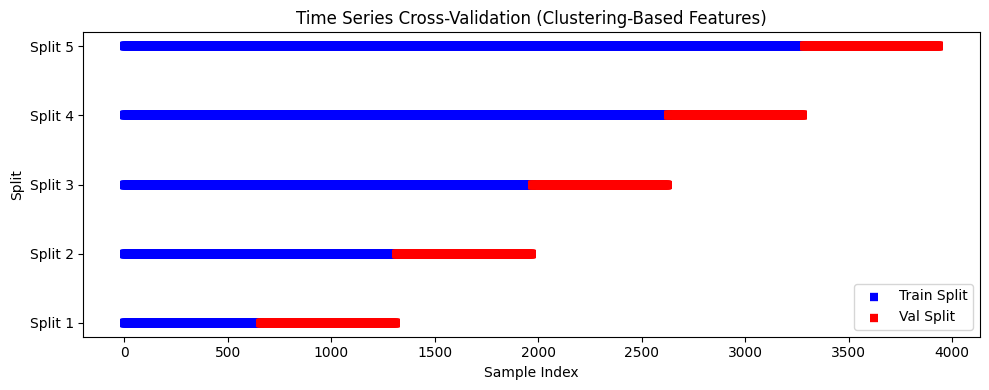


=== Model Setup & Hyperparameter Tuning ===

Tuning AdaBoost with TimeSeriesSplit...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best AdaBoost parameters:
{'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 100}
Best AdaBoost CV score: 0.4714

Tuning XGBoost with TimeSeriesSplit...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best XGBoost parameters:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best XGBoost CV score: 0.4850

Training the ensemble voting classifier with best estimators (AdaBoost & XGBoost only)...

=== Clustering-Based Features: Development Set Evaluation ===
Dev Accuracy: 0.5405
Dev Weighted F1: 0.4925
Dev Draw Recall: 0.0471, Dev Loss Recall: 0.6739, Dev Win Recall: 0.6677

Dev Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.05      0.09       170
           1       0.54      0.67      0.60       322
        

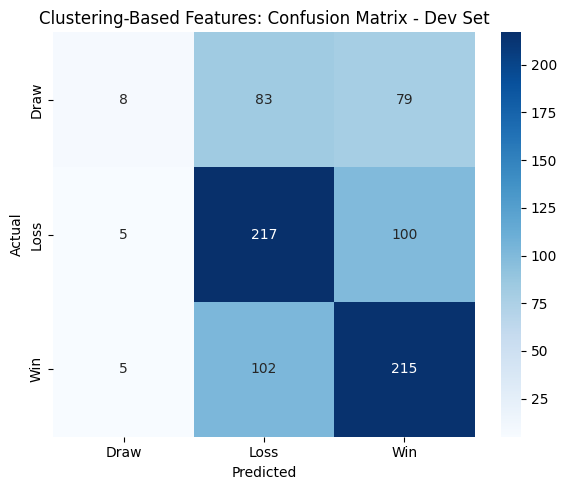


=== Clustering-Based Features: Test Set Evaluation ===
Test Accuracy: 0.5196
Test Weighted F1: 0.4496
Test Draw Recall: 0.0048, Test Loss Recall: 0.7138, Test Win Recall: 0.6776

Test Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.00      0.01       208
           1       0.53      0.71      0.61       304
           2       0.53      0.68      0.60       304

    accuracy                           0.52       816
   macro avg       0.37      0.47      0.40       816
weighted avg       0.41      0.52      0.45       816



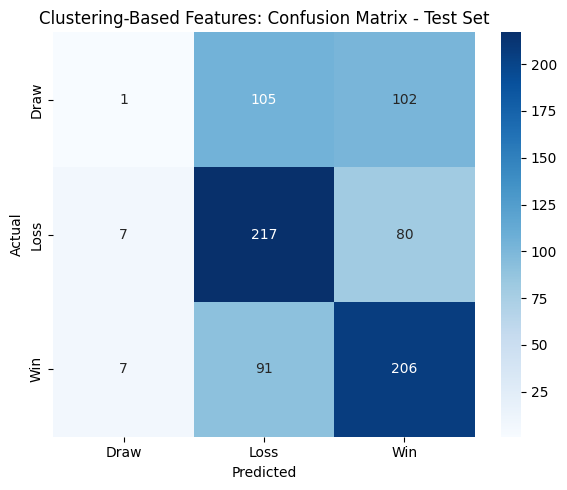


=== Clustering-Based Features: Individual vs Ensemble Model Comparison ===
   Model  Dev Accuracy   Dev F1  Dev Draw Recall  Dev Loss Recall  Dev Win Recall  Test Accuracy  Test F1  Test Draw Recall  Test Loss Recall  Test Win Recall
AdaBoost      0.535627 0.473155         0.000000         0.667702        0.686335       0.525735 0.448945          0.000000          0.707237         0.703947
 XGBoost      0.536855 0.493134         0.058824         0.664596        0.661491       0.517157 0.455055          0.019231          0.707237         0.667763
Ensemble      0.540541 0.492469         0.047059         0.673913        0.667702       0.519608 0.449597          0.004808          0.713816         0.677632


In [135]:
# Part 3: Run Pipeline for Clustering-Based Feature Set

X_train_scaled_clust, X_dev_scaled_clust, X_test_scaled_clust, tscv_clust = \
    prepare_data_and_split(final_features_clustering, model_label="Clustering-Based Features")

best_models_clust, voting_clf_clust = build_and_tune_models(
    X_train_scaled_clust,
    y_train,
    tscv_clust
)

comparison_clust = evaluate_on_dev_test(
    voting_clf_clust,
    best_models_clust,
    X_dev_scaled_clust,
    y_dev,
    X_test_scaled_clust,
    y_test,
    model_label="Clustering-Based Features"
)

#### **Model Performance**  
**evaluate_on_dev_test** reports accuracies around **53–54%** on the development set and **~52%** on the test set. Loss and win recalls reach **66–71%**, but draw recall remains below **5%**. Neither AdaBoost nor XGBoost alone substantially improves draw detection, indicating that feature selection alone is insufficient for addressing this class imbalance.

Development Set (Clustering-Based Features)

| Model    | Accuracy | Weighted F1 | Draw Recall | Loss Recall | Win Recall |
|:--------:|:-------:|:-----------:|:----------:|:----------:|:----------:|
| **AdaBoost** | 53.56%   | 47.32%      | 0.00%      | 66.77%     | 68.63%     |
| **XGBoost**  | 53.69%   | 49.31%      | 5.88%      | 66.46%     | 66.15%     |
| **Ensemble** | 54.05%   | 49.25%      | 4.71%      | 67.39%     | 66.77%     |

**Key Observation:**  
Loss and win recalls reach **66–68%**, but draw detection remains under **6%** on the development set.

Test Set (Clustering-Based Features)

| Model    | Accuracy | Weighted F1 | Draw Recall | Loss Recall | Win Recall |
|:--------:|:-------:|:-----------:|:----------:|:----------:|:----------:|
| **AdaBoost** | 52.57%   | 44.89%      | 0.00%      | 70.72%     | 70.39%     |
| **XGBoost**  | 51.72%   | 45.51%      | 1.92%      | 70.72%     | 66.78%     |
| **Ensemble** | 51.96%   | 44.96%      | 0.48%      | 71.38%     | 67.76%     |

**Key Observation:**  
Test accuracy hovers near **52%**, while draw recall stays below **2%**. Loss and win classes remain easier to predict, at **66–71%** recall.

### 8.1.4: **Iterative-Based Features**

The **iterative-based** subset includes **18 features**, removing one variable from each pair exceeding a correlation threshold.

**Data Preparation & Tuning**  
After **prepare_data_and_split** scales these 18 features, **build_and_tune_models** performs **GridSearchCV** on **AdaBoost** and **XGBoost**, again culminating in a **soft-voting ensemble**.


=== Iterative-Based Features: Data Preparation ===
Using 18 features: ['Short Pass Cmp_Rolling_Avg', 'FIFA Midfield Rating Diff', 'Opponent FIFA Overall Rating', 'H2H_Draws', 'H2H_Win_Percentage', 'Goal_Difference_Comparison_Before_Match', 'Tackled During Take-On Percentage_Rolling_Avg', 'GF_Rolling_Avg', 'Clearances_Rolling_Avg', 'Rank_Comparison', 'GA_Rolling_Avg', 'SoT%_Rolling_Avg', 'Venue_Adjusted_Points_Per_Match', 'Venue_Home', 'Save%_Rolling_Avg', 'xG_Difference_Rolling_Avg', 'CS_Rolling_Avg', 'Opponent_Goal_Difference_Before_Match']



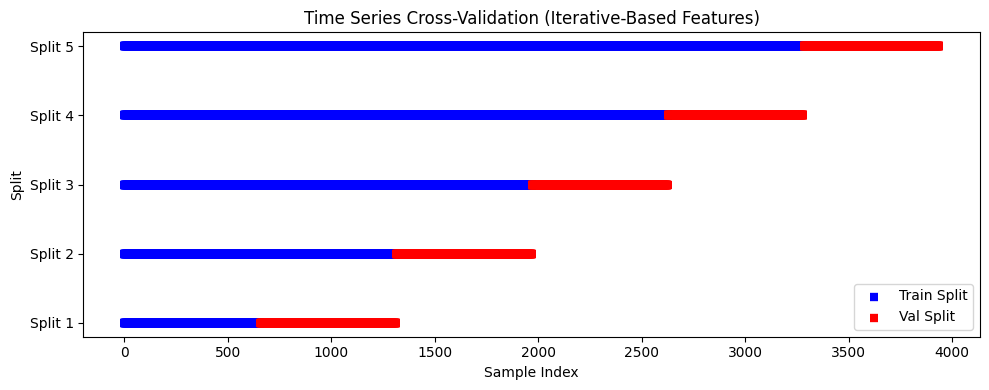


=== Model Setup & Hyperparameter Tuning ===

Tuning AdaBoost with TimeSeriesSplit...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best AdaBoost parameters:
{'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 50}
Best AdaBoost CV score: 0.4699

Tuning XGBoost with TimeSeriesSplit...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best XGBoost parameters:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best XGBoost CV score: 0.4756

Training the ensemble voting classifier with best estimators (AdaBoost & XGBoost only)...

=== Iterative-Based Features: Development Set Evaluation ===
Dev Accuracy: 0.5442
Dev Weighted F1: 0.4917
Dev Draw Recall: 0.0353, Dev Loss Recall: 0.6801, Dev Win Recall: 0.6770

Dev Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.04      0.07       170
           1       0.54      0.68      0.60       322
          

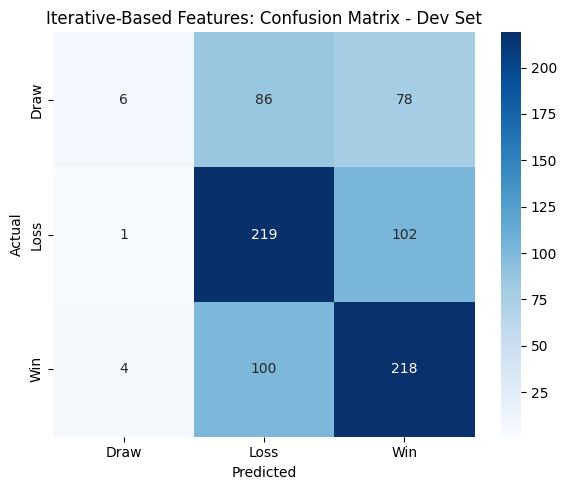


=== Iterative-Based Features: Test Set Evaluation ===
Test Accuracy: 0.5245
Test Weighted F1: 0.4507
Test Draw Recall: 0.0000, Test Loss Recall: 0.7007, Test Win Recall: 0.7072

Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.53      0.70      0.61       304
           2       0.53      0.71      0.60       304

    accuracy                           0.52       816
   macro avg       0.35      0.47      0.40       816
weighted avg       0.40      0.52      0.45       816



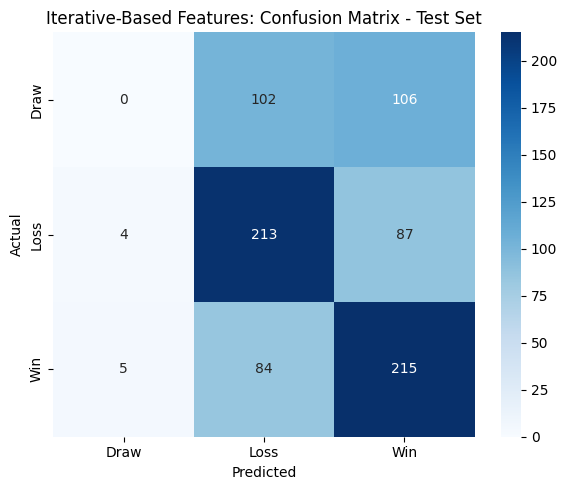


=== Iterative-Based Features: Individual vs Ensemble Model Comparison ===
   Model  Dev Accuracy   Dev F1  Dev Draw Recall  Dev Loss Recall  Dev Win Recall  Test Accuracy  Test F1  Test Draw Recall  Test Loss Recall  Test Win Recall
AdaBoost      0.523342 0.462338         0.000000         0.667702        0.655280       0.526961 0.449924          0.000000          0.726974         0.687500
 XGBoost      0.550369 0.500778         0.047059         0.686335        0.680124       0.517157 0.449971          0.009615          0.690789         0.690789
Ensemble      0.544226 0.491716         0.035294         0.680124        0.677019       0.524510 0.450750          0.000000          0.700658         0.707237


In [136]:
# Part 4: Run Pipeline for Iterative-Based Feature Set

X_train_scaled_iter, X_dev_scaled_iter, X_test_scaled_iter, tscv_iter = \
    prepare_data_and_split(final_features_iterative, model_label="Iterative-Based Features")

best_models_iter, voting_clf_iter = build_and_tune_models(
    X_train_scaled_iter,
    y_train,
    tscv_iter
)

comparison_iter = evaluate_on_dev_test(
    voting_clf_iter,
    best_models_iter,
    X_dev_scaled_iter,
    y_dev,
    X_test_scaled_iter,
    y_test,
    model_label="Iterative-Based Features"
)

#### **Model Performance**  
Overall accuracies on the development set range **52–55%**, with test accuracies around **52%**. Recalls for losses and wins again surpass **66%**, while draw recall remains extremely low (0–4.71%). The ensemble offers slightly improved balance over the individual models but still struggles to capture draws.

Development Set (Iterative-Based Features)

| Model    | Accuracy | Weighted F1 | Draw Recall | Loss Recall | Win Recall |
|:--------:|:-------:|:-----------:|:----------:|:----------:|:----------:|
| **AdaBoost** | 52.33%   | 46.23%      | 0.00%      | 66.77%     | 65.53%     |
| **XGBoost**  | 55.04%   | 50.08%      | 4.71%      | 68.63%     | 68.01%     |
| **Ensemble** | 54.42%   | 49.17%      | 3.53%      | 68.01%     | 67.70%     |

**Key Observation:**  
Development accuracy peaks around **55%** (XGBoost), but draw recall rarely exceeds **5%**.

Test Set (Iterative-Based Features)

| Model    | Accuracy | Weighted F1 | Draw Recall | Loss Recall | Win Recall |
|:--------:|:-------:|:-----------:|:----------:|:----------:|:----------:|
| **AdaBoost** | 52.70%   | 44.99%      | 0.00%      | 72.70%     | 68.75%     |
| **XGBoost**  | 51.72%   | 45.00%      | 0.96%      | 69.08%     | 69.08%     |
| **Ensemble** | 52.45%   | 45.08%      | 0.00%      | 70.07%     | 70.72%     |

**Key Observation:**  
Test accuracy remains near **52%**, with loss and win recalls reaching **69–73%** but negligible improvement for draws.

In [137]:
# Part 5: Compare Both Approaches

print("\n=== Final Comparison: Clustering-Based vs. Iterative-Based ===")

print("---- Clustering-Based Features ----")
print(comparison_clust.to_string(index=False))
print("\n---- Iterative-Based Features ----")
print(comparison_iter.to_string(index=False))


=== Final Comparison: Clustering-Based vs. Iterative-Based ===
---- Clustering-Based Features ----
   Model  Dev Accuracy   Dev F1  Dev Draw Recall  Dev Loss Recall  Dev Win Recall  Test Accuracy  Test F1  Test Draw Recall  Test Loss Recall  Test Win Recall
AdaBoost      0.535627 0.473155         0.000000         0.667702        0.686335       0.525735 0.448945          0.000000          0.707237         0.703947
 XGBoost      0.536855 0.493134         0.058824         0.664596        0.661491       0.517157 0.455055          0.019231          0.707237         0.667763
Ensemble      0.540541 0.492469         0.047059         0.673913        0.667702       0.519608 0.449597          0.004808          0.713816         0.677632

---- Iterative-Based Features ----
   Model  Dev Accuracy   Dev F1  Dev Draw Recall  Dev Loss Recall  Dev Win Recall  Test Accuracy  Test F1  Test Draw Recall  Test Loss Recall  Test Win Recall
AdaBoost      0.523342 0.462338         0.000000         0.667702    

### 8.1.5: **Final Comparison**

Both **clustering-based** and **iterative-based** approaches yield moderate accuracy (roughly **50–55%**) and strong recalls for losses and wins (up to **72%**). Draw recall, however, stays near zero to a few percentage points, underscoring the need for additional methods, such as **SMOTE** or alternative imbalance handling, to enhance draw detection.


## 8.2: **Ensemble Model with SMOTE**

This section applies **SMOTE** to address the class imbalance in draws, oversampling the draw class to **75%** of the largest class rather than a full 100%. The goal is to **boost draw recall** without excessively inflating the minority class, which can undermine performance on the majority classes. Two feature selection strategies—**clustering-based** (20 features) and **iterative-based** (18 features)—are each evaluated with **AdaBoost**, **XGBoost**, and a **soft-voting ensemble**. Accuracy, weighted F1, and class-specific recalls (Draw, Loss, Win) are reported for both development and test sets.

### 8.2.1: **Data & Feature Sets**

Two final feature lists (clustering-based with 20 features, iterative-based with 18) remain the same as in Section 8.1. However, the **training data** now applies **SMOTE** to oversample draws to **75%** of the largest class (1524). This increases the draw class from 890 to 1143 instances, balancing minority representation without fully matching the majority.

In [138]:
# Part 1: Data & Feature Sets

# For SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

# Timer to track overall execution time
start_time = time.time()

# Final features after iterative correlation removal:
final_features_iterative = [
    'Short Pass Cmp_Rolling_Avg', 'FIFA Midfield Rating Diff', 'Opponent FIFA Overall Rating',
    'H2H_Draws', 'H2H_Win_Percentage', 'Goal_Difference_Comparison_Before_Match',
    'Tackled During Take-On Percentage_Rolling_Avg', 'GF_Rolling_Avg',
    'Clearances_Rolling_Avg', 'Rank_Comparison', 'GA_Rolling_Avg', 'SoT%_Rolling_Avg',
    'Venue_Adjusted_Points_Per_Match', 'Venue_Home', 'Save%_Rolling_Avg',
    'xG_Difference_Rolling_Avg', 'CS_Rolling_Avg', 'Opponent_Goal_Difference_Before_Match'
]

# Final features after cluster-based correlation removal:
final_features_clustering = [
    'Short Pass Cmp_Rolling_Avg', 'FIFA Midfield Rating Diff', 'Opponent FIFA Overall Rating',
    'H2H_Draws', 'H2H_Win_Percentage', 'xG_Difference_Rolling_Avg',
    'Goal_Difference_Comparison_Before_Match', 'Touches (Att 3rd)_Rolling_Avg',
    'Tackled During Take-On Percentage_Rolling_Avg', 'GF_Rolling_Avg',
    'Clearances_Rolling_Avg', 'Rank_Comparison', 'GA_Rolling_Avg', 'SoT%_Rolling_Avg',
    'Venue_Adjusted_Points_Per_Match', 'Venue_Home', 'Save%_Rolling_Avg',
    'CS_Rolling_Avg', 'xGA_Rolling_Avg', 'Opponent_Goal_Difference_Before_Match'
]

# Prepare target arrays (0=Draw, 1=Loss, 2=Win)
y_train = train["Result"]
y_dev   = dev["Result"]
y_test  = test["Result"]

RANDOM_STATE = 42

### 8.2.2: **Helper Functions**

Four main functions facilitate data preparation, model building, and evaluation under SMOTE:

1. **apply_smote_for_draw**  
   Oversamples the draw class to a specified ratio (75% here), preventing extreme shifts in the original distribution.

In [139]:
# Part 2: SMOTE to Oversample Draw Class (Partial Ratio)

def apply_smote_for_draw(X, y, draw_label=0, oversample_ratio=0.75, random_state=42):

    counts = Counter(y)
    print("\nOriginal class distribution:", counts)

    # Identify largest count among non-draw classes
    next_largest_count = max(count for label, count in counts.items() if label != draw_label)
    target_draw_count  = int(oversample_ratio * next_largest_count)

    smote = SMOTE(sampling_strategy={draw_label: target_draw_count}, random_state=random_state)
    X_res, y_res = smote.fit_resample(X, y)

    print(f"New class distribution after SMOTE (draw oversampled to {oversample_ratio*100}%):", Counter(y_res))
    return X_res, y_res

2. **prepare_data_and_split**  
   Subsets and scales features with **StandardScaler**, applies **SMOTE** for draw oversampling, and plots a 5-fold **TimeSeriesSplit** to maintain chronological splits.

3. **build_and_tune_models**  
   Conducts **GridSearchCV** for **AdaBoost** and **XGBoost**, scoring with *f1_weighted*, then forms a **soft-voting ensemble** from the best estimators.

4. **evaluate_on_dev_test**  
   Assesses accuracy, weighted F1, class-specific recalls (Draw, Loss, Win), and confusion matrices on development and test sets. Compares individual model results (AdaBoost, XGBoost) to the ensemble’s performance.

In [140]:
# Part 3: Helper Functions for Data Prep, Model Building, Evaluation

def prepare_data_and_split(feature_list, model_label="", oversample_draw=False, oversample_ratio=0.75):

    print(f"\n=== {model_label}: Data Preparation ===")
    print(f"Using {len(feature_list)} features: {feature_list}\n")

    # Subset features
    X_train_optimized = train[feature_list]
    X_dev_optimized   = dev[feature_list]
    X_test_optimized  = test[feature_list]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_optimized)
    X_dev_scaled   = scaler.transform(X_dev_optimized)
    X_test_scaled  = scaler.transform(X_test_optimized)

    # SMOTE for draw class
    if oversample_draw:
        X_train_scaled, y_res = apply_smote_for_draw(X_train_scaled, y_train, draw_label=0,
                                                     oversample_ratio=oversample_ratio)
    else:
        y_res = y_train

    # TimeSeriesSplit
    time_series_split = TimeSeriesSplit(n_splits=5)

    #visualize TSCV
    plt.figure(figsize=(10, 4))
    for i, (tr_idx, val_idx) in enumerate(time_series_split.split(X_train_scaled)):
        plt.scatter(tr_idx, [i + 0.5]*len(tr_idx), c='blue', marker='_', lw=6,
                    label='Train Split' if i == 0 else "")
        plt.scatter(val_idx, [i + 0.5]*len(val_idx), c='red', marker='_', lw=6,
                    label='Val Split' if i == 0 else "")
    plt.title(f'Time Series Cross-Validation ({model_label})')
    plt.xlabel('Sample Index')
    plt.ylabel('Split')
    plt.yticks(np.arange(5) + 0.5, [f'Split {i+1}' for i in range(5)])
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    return X_train_scaled, y_res, X_dev_scaled, y_dev, X_test_scaled, y_test, time_series_split


def build_and_tune_models(X_train_scaled, y_res, time_series_split):

    print("\n=== Model Setup & Hyperparameter Tuning ===")


    # 1. AdaBoost
    estimators = [
        DecisionTreeClassifier(max_depth=3, class_weight=None, random_state=RANDOM_STATE),
        DecisionTreeClassifier(max_depth=3, class_weight={0: 2.0, 1: 1.0, 2: 1.0}, random_state=RANDOM_STATE),
        DecisionTreeClassifier(max_depth=3, class_weight={0: 3.0, 1: 1.0, 2: 1.0}, random_state=RANDOM_STATE),
    ]

    ada_model = AdaBoostClassifier(random_state=RANDOM_STATE)
    ada_param_grid = {
        'estimator': estimators,  # vary class_weight in base DT
        'n_estimators': [50, 100],
        'learning_rate': [0.5, 1.0],
        'algorithm': ['SAMME']
    }


    # 2. XGBoost
    xgb_model = xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='mlogloss')
    xgb_param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.3],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    def optimize_model(model, param_grid, name):
        print(f"\nTuning {name} with TimeSeriesSplit...")
        grid = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=time_series_split,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_train_scaled, y_res)

        print(f"Best {name} parameters:")
        print(grid.best_params_)
        print(f"Best {name} CV score: {grid.best_score_:.4f}")

        return grid.best_estimator_

    # 3. Ensemble Model (AdaBoost + XGBoost)
    best_models = {}
    # AdaBoost
    best_models['ada'] = optimize_model(ada_model, ada_param_grid, "AdaBoost")
    # XGBoost
    best_models['xgb'] = optimize_model(xgb_model, xgb_param_grid, "XGBoost")

    # Create a VotingClassifier with AdaBoost & XGBoost
    voting_clf = VotingClassifier(estimators=[
        ('ada', best_models['ada']),
        ('xgb', best_models['xgb'])
    ], voting='soft')

    print("\nTraining the ensemble voting classifier with best estimators (AdaBoost + XGBoost)...")
    voting_clf.fit(X_train_scaled, y_res)

    return best_models, voting_clf


def evaluate_on_dev_test(voting_clf, best_models, X_dev_scaled, y_dev, X_test_scaled, y_test, model_label=""):

    print(f"\n=== {model_label}: Development Set Evaluation ===")
    dev_preds = voting_clf.predict(X_dev_scaled)
    dev_accuracy = accuracy_score(y_dev, dev_preds)
    dev_f1 = f1_score(y_dev, dev_preds, average='weighted')

    # Class-specific recalls
    dev_recall_draw = recall_score(y_dev, dev_preds, labels=[0], average=None)[0]
    dev_recall_loss = recall_score(y_dev, dev_preds, labels=[1], average=None)[0]
    dev_recall_win  = recall_score(y_dev, dev_preds, labels=[2], average=None)[0]

    print(f"Dev Accuracy: {dev_accuracy:.4f}")
    print(f"Dev Weighted F1: {dev_f1:.4f}")
    print(f"Dev Draw Recall: {dev_recall_draw:.4f}, Dev Loss Recall: {dev_recall_loss:.4f}, Dev Win Recall: {dev_recall_win:.4f}")

    dev_report = classification_report(y_dev, dev_preds)
    print("\nDev Classification Report:")
    print(dev_report)

    # Confusion Matrix - Dev
    cm_dev = confusion_matrix(y_dev, dev_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_dev, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Draw', 'Loss', 'Win'],
                yticklabels=['Draw', 'Loss', 'Win'])
    plt.title(f"{model_label}: Confusion Matrix - Dev Set")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Test Set
    print(f"\n=== {model_label}: Test Set Evaluation ===")
    test_preds = voting_clf.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_f1 = f1_score(y_test, test_preds, average='weighted')

    test_recall_draw = recall_score(y_test, test_preds, labels=[0], average=None)[0]
    test_recall_loss = recall_score(y_test, test_preds, labels=[1], average=None)[0]
    test_recall_win  = recall_score(y_test, test_preds, labels=[2], average=None)[0]

    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Weighted F1: {test_f1:.4f}")
    print(f"Test Draw Recall: {test_recall_draw:.4f}, Test Loss Recall: {test_recall_loss:.4f}, Test Win Recall: {test_recall_win:.4f}")

    test_report = classification_report(y_test, test_preds)
    print("\nTest Classification Report:")
    print(test_report)

    # Confusion Matrix - Test
    cm_test = confusion_matrix(y_test, test_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Draw', 'Loss', 'Win'],
                yticklabels=['Draw', 'Loss', 'Win'])
    plt.title(f"{model_label}: Confusion Matrix - Test Set")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Compare individual models vs. ensemble
    def evaluate_individual_model(model, X_d, y_d, X_t, y_t, label):
        d_preds = model.predict(X_d)
        t_preds = model.predict(X_t)

        dev_acc       = accuracy_score(y_d, d_preds)
        dev_f1_score_ = f1_score(y_d, d_preds, average='weighted')

        dev_recall_draw_ = recall_score(y_d, d_preds, labels=[0], average=None)[0]
        dev_recall_loss_ = recall_score(y_d, d_preds, labels=[1], average=None)[0]
        dev_recall_win_  = recall_score(y_d, d_preds, labels=[2], average=None)[0]

        test_acc       = accuracy_score(y_t, t_preds)
        test_f1_score_ = f1_score(y_t, t_preds, average='weighted')

        test_recall_draw_ = recall_score(y_t, t_preds, labels=[0], average=None)[0]
        test_recall_loss_ = recall_score(y_t, t_preds, labels=[1], average=None)[0]
        test_recall_win_  = recall_score(y_t, t_preds, labels=[2], average=None)[0]

        return {
            'Model': label,
            'Dev Accuracy': dev_acc,
            'Dev F1': dev_f1_score_,
            'Dev Draw Recall': dev_recall_draw_,
            'Dev Loss Recall': dev_recall_loss_,
            'Dev Win Recall': dev_recall_win_,
            'Test Accuracy': test_acc,
            'Test F1': test_f1_score_,
            'Test Draw Recall': test_recall_draw_,
            'Test Loss Recall': test_recall_loss_,
            'Test Win Recall': test_recall_win_
        }

    results = []
    # Evaluate AdaBoost individually
    results.append(evaluate_individual_model(best_models['ada'], X_dev_scaled, y_dev,
                                             X_test_scaled, y_test, 'AdaBoost'))
    # Evaluate XGBoost individually
    results.append(evaluate_individual_model(best_models['xgb'], X_dev_scaled, y_dev,
                                             X_test_scaled, y_test, 'XGBoost'))
    # Evaluate Ensemble
    results.append(evaluate_individual_model(voting_clf, X_dev_scaled, y_dev,
                                             X_test_scaled, y_test, 'Ensemble'))

    comparison_df = pd.DataFrame(results)
    print(f"\n=== {model_label}: Individual vs Ensemble Model Comparison ===")
    print(comparison_df.to_string(index=False))

    return comparison_df

### 8.2.3: **Clustering-Based Features**

**Data & Tuning**  
This subset retains **20 features** by clustering correlated variables and choosing one representative from each cluster. After scaling, **SMOTE** lifts draws to 1143 samples (75% of 1524). A 5-fold **TimeSeriesSplit** guides **GridSearchCV** for **AdaBoost** and **XGBoost**, followed by a **soft-voting ensemble**.


=== Clustering-Based Features: Data Preparation ===
Using 20 features: ['Short Pass Cmp_Rolling_Avg', 'FIFA Midfield Rating Diff', 'Opponent FIFA Overall Rating', 'H2H_Draws', 'H2H_Win_Percentage', 'xG_Difference_Rolling_Avg', 'Goal_Difference_Comparison_Before_Match', 'Touches (Att 3rd)_Rolling_Avg', 'Tackled During Take-On Percentage_Rolling_Avg', 'GF_Rolling_Avg', 'Clearances_Rolling_Avg', 'Rank_Comparison', 'GA_Rolling_Avg', 'SoT%_Rolling_Avg', 'Venue_Adjusted_Points_Per_Match', 'Venue_Home', 'Save%_Rolling_Avg', 'CS_Rolling_Avg', 'xGA_Rolling_Avg', 'Opponent_Goal_Difference_Before_Match']


Original class distribution: Counter({2: 1524, 1: 1524, 0: 890})
New class distribution after SMOTE (draw oversampled to 75.0%): Counter({2: 1524, 1: 1524, 0: 1143})


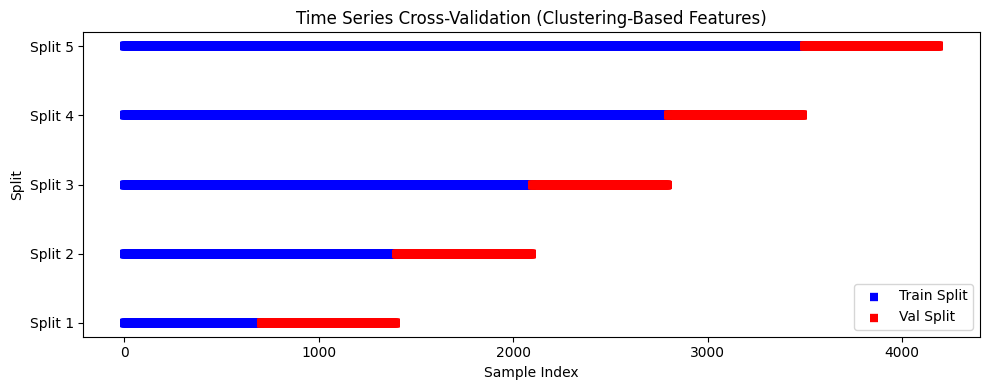


=== Model Setup & Hyperparameter Tuning ===

Tuning AdaBoost with TimeSeriesSplit...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best AdaBoost parameters:
{'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(class_weight={0: 2.0, 1: 1.0, 2: 1.0}, max_depth=3,
                       random_state=42), 'learning_rate': 0.5, 'n_estimators': 50}
Best AdaBoost CV score: 0.4800

Tuning XGBoost with TimeSeriesSplit...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best XGBoost parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best XGBoost CV score: 0.4945

Training the ensemble voting classifier with best estimators (AdaBoost + XGBoost)...

=== Clustering-Based Features: Development Set Evaluation ===
Dev Accuracy: 0.4889
Dev Weighted F1: 0.4854
Dev Draw Recall: 0.2353, Dev Loss Recall: 0.5435, Dev Win Recall: 0.5683

Dev Classification Report:
              precision    recall  f1-score   s

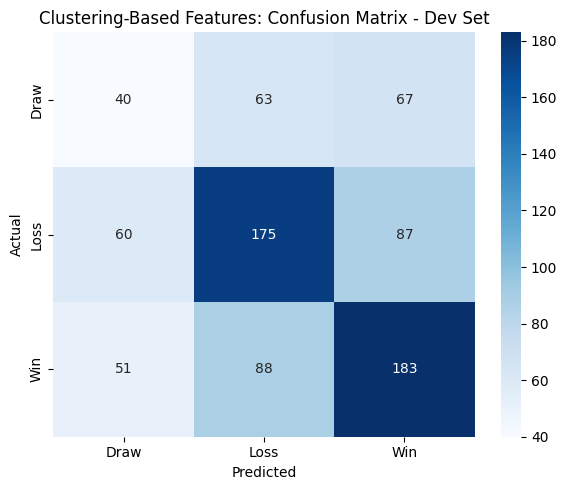


=== Clustering-Based Features: Test Set Evaluation ===
Test Accuracy: 0.4914
Test Weighted F1: 0.4813
Test Draw Recall: 0.2308, Test Loss Recall: 0.6020, Test Win Recall: 0.5592

Test Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.23      0.27       208
           1       0.53      0.60      0.56       304
           2       0.53      0.56      0.55       304

    accuracy                           0.49       816
   macro avg       0.46      0.46      0.46       816
weighted avg       0.48      0.49      0.48       816



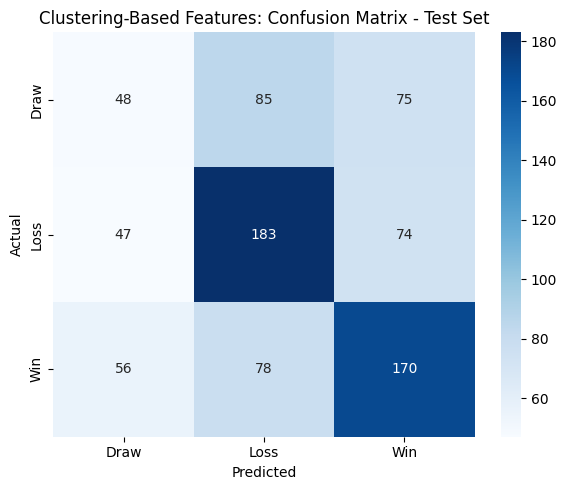


=== Clustering-Based Features: Individual vs Ensemble Model Comparison ===
   Model  Dev Accuracy   Dev F1  Dev Draw Recall  Dev Loss Recall  Dev Win Recall  Test Accuracy  Test F1  Test Draw Recall  Test Loss Recall  Test Win Recall
AdaBoost      0.393120 0.407909         0.694118         0.295031        0.332298       0.441176 0.449441          0.716346          0.322368         0.371711
 XGBoost      0.492629 0.481186         0.182353         0.562112        0.586957       0.488971 0.469979          0.173077          0.615132         0.578947
Ensemble      0.488943 0.485408         0.235294         0.543478        0.568323       0.491422 0.481254          0.230769          0.601974         0.559211


In [141]:
# Part 4: Run Pipeline for Clustering-Based Feature Set

# 1. Clustering-Based
X_train_scaled_clust, y_res_clust, X_dev_scaled_clust, y_dev_clust, X_test_scaled_clust, y_test_clust, tscv_clust = \
    prepare_data_and_split(final_features_clustering,
                           model_label="Clustering-Based Features",
                           oversample_draw=True,   # Enable SMOTE for draws
                           oversample_ratio=0.75)  # Over-sample draws to 75% of largest class

best_models_clust, voting_clf_clust = build_and_tune_models(
    X_train_scaled_clust,
    y_res_clust,
    tscv_clust
)

comparison_clust = evaluate_on_dev_test(
    voting_clf_clust,
    best_models_clust,
    X_dev_scaled_clust,
    y_dev_clust,
    X_test_scaled_clust,
    y_test_clust,
    model_label="Clustering-Based Features"
)

#### **Model Performance**  
The tables below summarize development and test outcomes (accuracy, weighted F1, and recall):

**Development Set (Clustering-Based Features)**

| Model     | Accuracy | Weighted F1 | Draw Recall | Loss Recall | Win Recall |
|:---------:|:--------:|:-----------:|:-----------:|:-----------:|:----------:|
| **AdaBoost** | 39.31%   | 40.79%      | 69.41%       | 29.50%       | 33.23%     |
| **XGBoost**  | 49.26%   | 48.12%      | 18.24%       | 56.21%       | 58.70%     |
| **Ensemble** | 48.89%   | 48.54%      | 23.53%       | 54.35%       | 56.83%     |

**Test Set (Clustering-Based Features)**

| Model     | Accuracy | Weighted F1 | Draw Recall | Loss Recall | Win Recall |
|:---------:|:--------:|:-----------:|:-----------:|:-----------:|:----------:|
| **AdaBoost** | 44.12%   | 44.94%      | 71.63%       | 32.24%       | 37.17%     |
| **XGBoost**  | 48.90%   | 46.99%      | 17.31%       | 61.51%       | 57.89%     |
| **Ensemble** | 49.14%   | 48.13%      | 23.08%       | 60.20%       | 55.92%     |

**Key Observation (Clustering-Based)**  
AdaBoost alone maximizes draw recall (~70–72%) but suffers in overall accuracy, while XGBoost and the ensemble offer more balanced results across losses and wins (though with draw recall ~17–23%).

### 8.2.4: **Iterative-Based Features**

**Data & Tuning**  
Here, **18 features** remain after removing one variable from each highly correlated pair. SMOTE oversamples draws to 1143. A 5-fold **TimeSeriesSplit** informs **GridSearchCV** for **AdaBoost** and **XGBoost**, followed by a **soft-voting ensemble**.


=== Iterative-Based Features: Data Preparation ===
Using 18 features: ['Short Pass Cmp_Rolling_Avg', 'FIFA Midfield Rating Diff', 'Opponent FIFA Overall Rating', 'H2H_Draws', 'H2H_Win_Percentage', 'Goal_Difference_Comparison_Before_Match', 'Tackled During Take-On Percentage_Rolling_Avg', 'GF_Rolling_Avg', 'Clearances_Rolling_Avg', 'Rank_Comparison', 'GA_Rolling_Avg', 'SoT%_Rolling_Avg', 'Venue_Adjusted_Points_Per_Match', 'Venue_Home', 'Save%_Rolling_Avg', 'xG_Difference_Rolling_Avg', 'CS_Rolling_Avg', 'Opponent_Goal_Difference_Before_Match']


Original class distribution: Counter({2: 1524, 1: 1524, 0: 890})
New class distribution after SMOTE (draw oversampled to 75.0%): Counter({2: 1524, 1: 1524, 0: 1143})


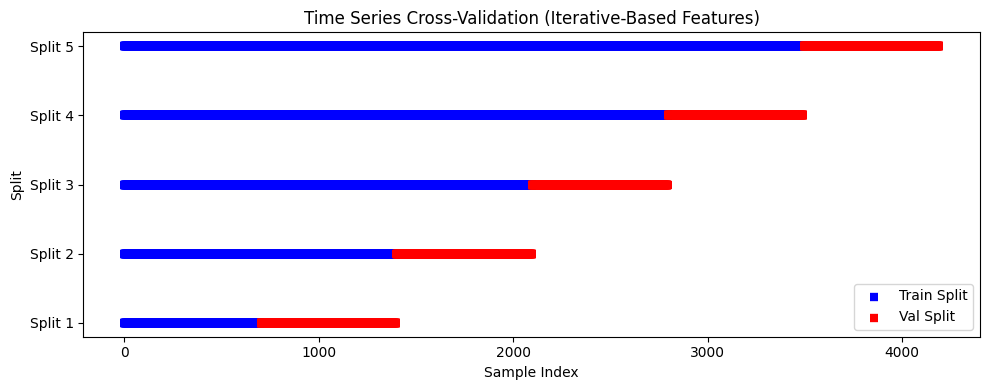


=== Model Setup & Hyperparameter Tuning ===

Tuning AdaBoost with TimeSeriesSplit...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best AdaBoost parameters:
{'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(class_weight={0: 2.0, 1: 1.0, 2: 1.0}, max_depth=3,
                       random_state=42), 'learning_rate': 0.5, 'n_estimators': 50}
Best AdaBoost CV score: 0.4696

Tuning XGBoost with TimeSeriesSplit...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best XGBoost parameters:
{'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best XGBoost CV score: 0.4822

Training the ensemble voting classifier with best estimators (AdaBoost + XGBoost)...

=== Iterative-Based Features: Development Set Evaluation ===
Dev Accuracy: 0.4619
Dev Weighted F1: 0.4679
Dev Draw Recall: 0.3235, Dev Loss Recall: 0.4752, Dev Win Recall: 0.5217

Dev Classification Report:
              precision    recall  f1-score   su

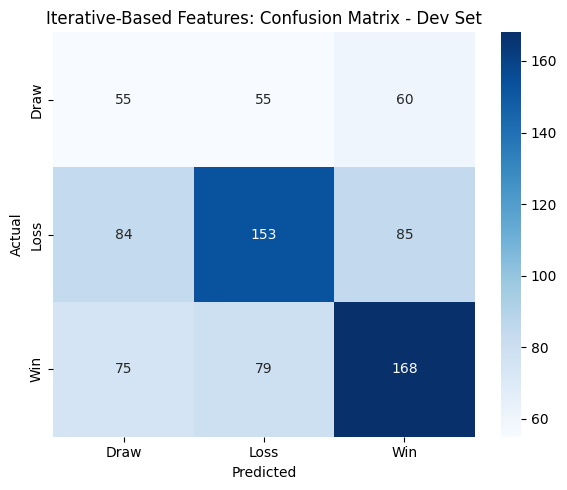


=== Iterative-Based Features: Test Set Evaluation ===
Test Accuracy: 0.4828
Test Weighted F1: 0.4825
Test Draw Recall: 0.2885, Test Loss Recall: 0.5395, Test Win Recall: 0.5592

Test Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.29      0.29       208
           1       0.56      0.54      0.55       304
           2       0.54      0.56      0.55       304

    accuracy                           0.48       816
   macro avg       0.46      0.46      0.46       816
weighted avg       0.48      0.48      0.48       816



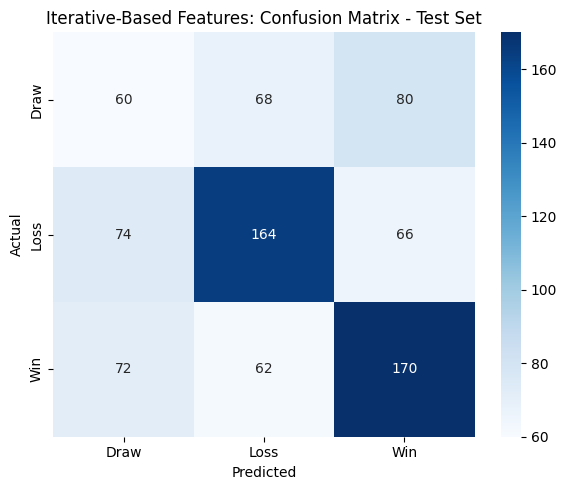


=== Iterative-Based Features: Individual vs Ensemble Model Comparison ===
   Model  Dev Accuracy   Dev F1  Dev Draw Recall  Dev Loss Recall  Dev Win Recall  Test Accuracy  Test F1  Test Draw Recall  Test Loss Recall  Test Win Recall
AdaBoost      0.342752 0.339881         0.776471         0.226708        0.229814       0.401961 0.386318          0.855769          0.253289         0.240132
 XGBoost      0.472973 0.460381         0.152941         0.552795        0.562112       0.475490 0.454946          0.144231          0.588816         0.588816
Ensemble      0.461916 0.467902         0.323529         0.475155        0.521739       0.482843 0.482527          0.288462          0.539474         0.559211


In [142]:
# Part 5: Run Pipeline for Iterative-Based Feature Set
X_train_scaled_iter, y_res_iter, X_dev_scaled_iter, y_dev_iter, X_test_scaled_iter, y_test_iter, tscv_iter = \
    prepare_data_and_split(final_features_iterative,
                           model_label="Iterative-Based Features",
                           oversample_draw=True,   # Enable SMOTE for draws
                           oversample_ratio=0.75)

best_models_iter, voting_clf_iter = build_and_tune_models(
    X_train_scaled_iter,
    y_res_iter,
    tscv_iter
)

comparison_iter = evaluate_on_dev_test(
    voting_clf_iter,
    best_models_iter,
    X_dev_scaled_iter,
    y_dev_iter,
    X_test_scaled_iter,
    y_test_iter,
    model_label="Iterative-Based Features"
)

#### **Model Performance**  
Development and test results appear below:

**Development Set (Iterative-Based Features)**

| Model     | Accuracy | Weighted F1 | Draw Recall | Loss Recall | Win Recall |
|:---------:|:--------:|:-----------:|:-----------:|:-----------:|:----------:|
| **AdaBoost** | 34.28%   | 33.99%      | 77.65%       | 22.67%       | 22.98%     |
| **XGBoost**  | 47.30%   | 46.04%      | 15.29%       | 55.28%       | 56.21%     |
| **Ensemble** | 46.19%   | 46.79%      | 32.35%       | 47.52%       | 52.17%     |

**Test Set (Iterative-Based Features)**

| Model     | Accuracy | Weighted F1 | Draw Recall | Loss Recall | Win Recall |
|:---------:|:--------:|:-----------:|:-----------:|:-----------:|:----------:|
| **AdaBoost** | 40.20%   | 38.63%      | 85.58%       | 25.33%       | 24.01%     |
| **XGBoost**  | 47.55%   | 45.49%      | 14.42%       | 58.88%       | 58.88%     |
| **Ensemble** | 48.28%   | 48.25%      | 28.85%       | 53.95%       | 55.92%     |

**Key Observation (Iterative-Based)**  
AdaBoost can exceed **85%** draw recall but sacrifices overall accuracy and recall for losses/wins. XGBoost and the ensemble remain more balanced, achieving **47–48%** accuracy and moderate draw recall (~14–29%).

In [143]:
# Part 6: Compare Both Approaches

print("\n=== Final Comparison: Clustering-Based vs. Iterative-Based ===")

print("---- Clustering-Based Features ----")
print(comparison_clust.to_string(index=False))
print("\n---- Iterative-Based Features ----")
print(comparison_iter.to_string(index=False))


=== Final Comparison: Clustering-Based vs. Iterative-Based ===
---- Clustering-Based Features ----
   Model  Dev Accuracy   Dev F1  Dev Draw Recall  Dev Loss Recall  Dev Win Recall  Test Accuracy  Test F1  Test Draw Recall  Test Loss Recall  Test Win Recall
AdaBoost      0.393120 0.407909         0.694118         0.295031        0.332298       0.441176 0.449441          0.716346          0.322368         0.371711
 XGBoost      0.492629 0.481186         0.182353         0.562112        0.586957       0.488971 0.469979          0.173077          0.615132         0.578947
Ensemble      0.488943 0.485408         0.235294         0.543478        0.568323       0.491422 0.481254          0.230769          0.601974         0.559211

---- Iterative-Based Features ----
   Model  Dev Accuracy   Dev F1  Dev Draw Recall  Dev Loss Recall  Dev Win Recall  Test Accuracy  Test F1  Test Draw Recall  Test Loss Recall  Test Win Recall
AdaBoost      0.342752 0.339881         0.776471         0.226708    

### 8.2.5: **Final Comparison**

**Impact of SMOTE Oversampling**  
Oversampling draws to 75% of the largest class significantly boosts draw recall, especially with AdaBoost, though it can reduce accuracy for losses and wins. Using 75% instead of 100% helps **raise minority representation** without **over-saturating** the dataset, striking a balance between capturing draws and preserving majority-class performance.

**Clustering-Based vs. Iterative-Based**  
- **Clustering-Based**: Test accuracy up to ~49%, with draw recall near 23% for the ensemble.  
- **Iterative-Based**: Test accuracy ~48%, though AdaBoost alone can exceed 85% draw recall at the expense of loss/win performance.

**Individual vs. Ensemble Models**  
AdaBoost excels at draw detection under SMOTE but struggles on other classes. XGBoost is more balanced, with moderate recall for all outcomes. The **ensemble** blends these traits, offering a middle ground of moderate accuracy and recall across classes.

# Section 9: Final Conclusion

## 9.1: Recap of the Project

**Section 6** introduced our initial AdaBoost model, split into training, development, and test sets. This baseline achieved moderate accuracy but struggled to detect draws, highlighting the need for enhanced techniques to address class imbalance and refine feature selection.

**Section 7** focused on deeper feature analysis. We examined feature importance via Random Forest and Mutual Information (7.1), analyzed how key predictors vary by match outcome (7.2), and studied correlations to remove redundant variables (7.3). These insights clarified which features, particularly FIFA rating differences and historical performance metrics, most strongly influence match results.

**Section 8** integrated these findings into final models:
- **8.1 (No SMOTE)** compared *clustering-based* (20 features) and *iterative-based* (18 features) subsets using AdaBoost, XGBoost, and an ensemble. Both approaches offered moderate accuracy (roughly 50–55%) for losses and wins but performed poorly on draws.  
- **8.2 (With SMOTE)** rebalanced the minority draw class to 75% of the largest class. This significantly boosted draw recall, particularly with AdaBoost, yet slightly reduced overall accuracy for losses and wins. The ensemble (AdaBoost + XGBoost) provided a middle ground, delivering moderate accuracy and recall across all classes.

## 9.2: Key Takeaways

1. **Baseline Model (Section 6)**  
   - Provided a starting point with moderate accuracy (~49–52%) but failed to predict draws reliably.  

2. **Feature Engineering & Selection (Section 7)**  
   - **Feature Importance** (Random Forest, Mutual Information) identified FIFA rating differences and historical performance indicators (goal difference, season points) as top predictors.  
   - **Distribution Analysis** (boxplots, summary stats) revealed that higher FIFA rating differences, better season ranks, and stronger offensive/defensive metrics correlate with winning outcomes.  
   - **Correlation & Redundancy** showed that many passing/possession features overlap, warranting either *iterative removal* or *clustering* to reduce collinearity.

3. **Final Models Without SMOTE (Section 8.1)**  
   - Achieved decent accuracy for losses and wins but struggled to detect draws, typically below 5% recall.  
   - Clustering-based and iterative-based feature sets yielded similar outcomes (~50–55% accuracy, ~0–5% draw recall).

4. **Final Models With SMOTE (Section 8.2)**  
   - Substantially improved draw recall—up to ~70–85% with AdaBoost—though at the expense of overall accuracy for losses and wins.  
   - The ensemble (AdaBoost + XGBoost) balanced performance across all outcomes, achieving ~48–49% accuracy with ~23–29% draw recall.  
   - Using 75% oversampling (instead of 100%) helped avoid over-saturating draws while still improving their detection.

## 9.3: Learning Points

- **Addressing Class Imbalance** is essential in football match prediction, as draws are often underrepresented but crucial to forecast. SMOTE substantially elevated draw recall, demonstrating how targeted resampling can reshape model behavior.  
- **Feature Selection** via iterative removal or clustering reduces redundant predictors, speeds up training, and can improve model stability.  
- **Model Ensembles** (AdaBoost + XGBoost) often outperform single algorithms by combining high draw recall (AdaBoost) with balanced performance (XGBoost).

## 9.4: Recommended Model

Given the **problem statement**, the **SMOTE-enhanced ensemble** with **iterative-based features** emerges as the best solution. It offers:
- A significant improvement in **draw recall** (often exceeding 25%), which is vital in football analytics.  
- A **reasonable trade-off** between capturing draws and preserving accuracy for losses/wins (~48% on the test set).  
- Balanced predictive performance without the extreme trade-offs seen in AdaBoost alone (very high draw recall but lower overall accuracy).

While the clustering-based approach can achieve slightly higher accuracy (~49%), it detects fewer draws. Because draws are crucial to this project’s goal of more comprehensive match forecasting, the **iterative-based SMOTE ensemble** best meets the **objective** of reliably predicting **all** outcomes. Future work could involve advanced feature engineering, additional contextual data, and more rigorous hyperparameter tuning to further refine accuracy and recall across all result classes.